<a href="https://colab.research.google.com/github/alejandracardonavelasco/ML-/blob/main/Lab10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Homework Lab 10**


## Task 1 - CNN Dreams: Last Homework Assignment Revisited

In [2]:
import torch
import torchvision
from matplotlib import pyplot

transform = torchvision.transforms.Compose(
    [ torchvision.transforms.ToTensor(), #Converts a PIL Image or numpy.ndarray (H x W x C) in the range [0, 255] to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0]
      torchvision.transforms.Normalize((0.1307), (0.3081))])

trainset = torchvision.datasets.MNIST(root='./data',
                                      train=True,
                                      download=True,
                                      transform=transform)

trainloader = torch.utils.data.DataLoader(trainset,
                                          batch_size=2048,
                                          shuffle=True)   #we do shuffle it to give more randomizations to training epochs

testset = torchvision.datasets.MNIST(root='./data',
                                     train=False,
                                     download=True,
                                     transform=transform)

testloader = torch.utils.data.DataLoader(testset,
                                         batch_size=1,
                                         shuffle=False)

100%|██████████| 9.91M/9.91M [00:00<00:00, 18.3MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 489kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.53MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.67MB/s]


In [3]:
import torch.nn as nn
import torch.nn.functional as F

class LeNet5(torch.nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.pool = nn.AvgPool2d(2, 2)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

        self.dropout = torch.nn.Dropout(0.05)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        x = self.dropout(x)
        return x

In [4]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Working on {device}")

net = LeNet5().to(device)
optimizer = torch.optim.Adam(net.parameters(), 0.001)   #initial and fixed learning rate of 0.001.

net.train()    #it notifies the network layers (especially batchnorm or dropout layers, which we don't use in this example) that we are doing traning
for epoch in range(16):  #  an epoch is a training run through the whole data set

    for batch, data in enumerate(trainloader):
        batch_inputs, batch_labels = data

        batch_inputs = batch_inputs.to(device)  #explicitly moving the data to the target device
        batch_labels = batch_labels.to(device)

        optimizer.zero_grad()

        batch_outputs = net(batch_inputs)   #this line calls the forward(self, x) method of the LeNet5 object. Please note,
                                            # the nonlinear activation after the last layer is NOT applied
        loss = torch.nn.functional.cross_entropy(batch_outputs, batch_labels, reduction = "mean") #instead, nonlinear softmax is applied internally in THIS loss function
        print("epoch:", epoch, "batch:", batch, "current batch loss:", loss.item())
        loss.backward()       #this computes gradients as we have seen in previous workshops
        optimizer.step()     #but this line in fact updates our neural network.
                                ####You can experiment - comment this line and check, that the loss DOE

Working on cuda
epoch: 0 batch: 0 current batch loss: 2.3059966564178467
epoch: 0 batch: 1 current batch loss: 2.3023524284362793
epoch: 0 batch: 2 current batch loss: 2.2910852432250977
epoch: 0 batch: 3 current batch loss: 2.281172275543213
epoch: 0 batch: 4 current batch loss: 2.2720255851745605
epoch: 0 batch: 5 current batch loss: 2.2617075443267822
epoch: 0 batch: 6 current batch loss: 2.2395646572113037
epoch: 0 batch: 7 current batch loss: 2.2250983715057373
epoch: 0 batch: 8 current batch loss: 2.195240020751953
epoch: 0 batch: 9 current batch loss: 2.1641287803649902
epoch: 0 batch: 10 current batch loss: 2.121159553527832
epoch: 0 batch: 11 current batch loss: 2.078418731689453
epoch: 0 batch: 12 current batch loss: 2.019899845123291
epoch: 0 batch: 13 current batch loss: 1.9606482982635498
epoch: 0 batch: 14 current batch loss: 1.8941594362258911
epoch: 0 batch: 15 current batch loss: 1.8254977464675903
epoch: 0 batch: 16 current batch loss: 1.7349839210510254
epoch: 0 batc

In [5]:
good = 0
wrong = 0

net.eval()              #it notifies the network layers (especially batchnorm or dropout layers, which we don't use in this example) that we are doing evaluation
with torch.no_grad():   #it prevents that the net learns during evalution. The gradients are not computed, so this makes it faster, too
    for batch, data in enumerate(testloader): #batches in test are of size 1
        datapoint, label = data

        prediction = net(datapoint.to(device))                  #prediction has values representing the "prevalence" of the corresponding class
        classification = torch.argmax(prediction)    #the class is the index of maximal "prevalence"

        if classification.item() == label.item():
            good += 1
        else:
            wrong += 1

print("accuracy = ", good/(good+wrong))

accuracy =  0.9836


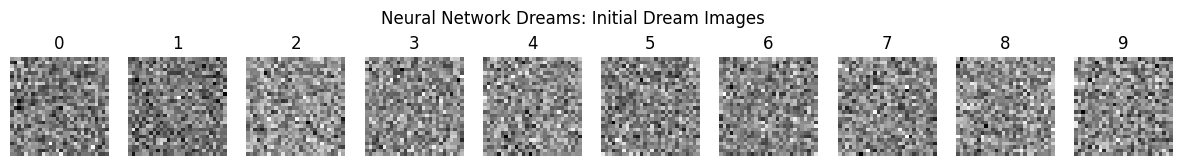

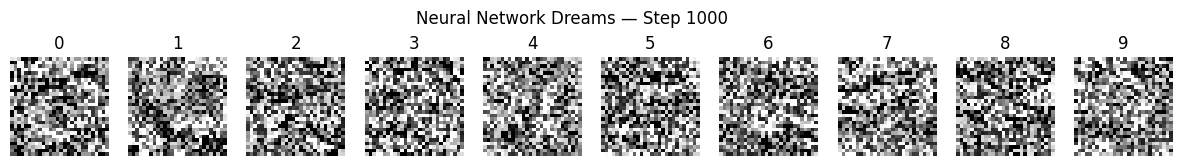

Step 1000, Loss: 0.0543, Confidences: tensor([0.9479, 0.8753, 0.9800, 0.9735, 0.9425, 0.9812, 0.9579, 0.9564, 0.9578,
        0.9042], device='cuda:0')


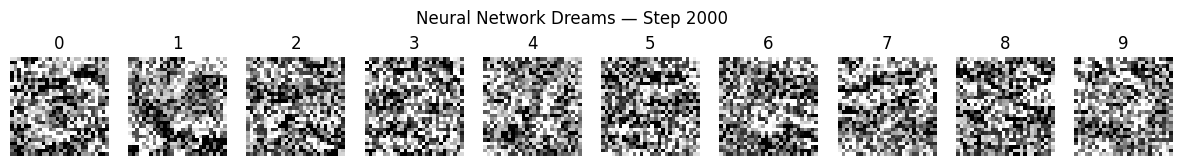

Step 2000, Loss: 0.0180, Confidences: tensor([0.9818, 0.9611, 0.9940, 0.9913, 0.9772, 0.9940, 0.9847, 0.9865, 0.9854,
        0.9663], device='cuda:0')


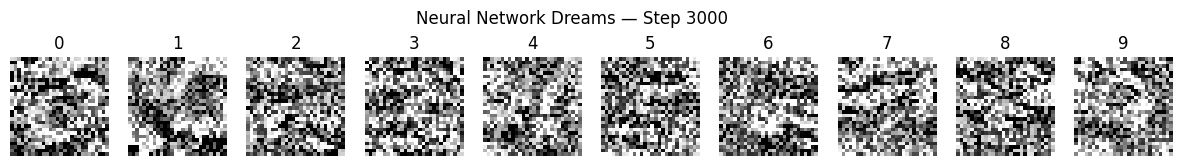

Step 3000, Loss: 0.0087, Confidences: tensor([0.9912, 0.9809, 0.9972, 0.9961, 0.9882, 0.9974, 0.9925, 0.9934, 0.9927,
        0.9840], device='cuda:0')


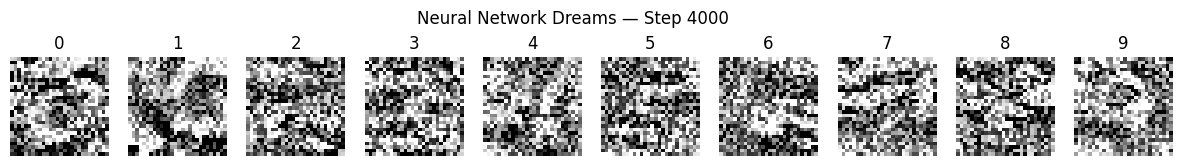

Step 4000, Loss: 0.0048, Confidences: tensor([0.9953, 0.9888, 0.9984, 0.9979, 0.9932, 0.9986, 0.9960, 0.9964, 0.9961,
        0.9912], device='cuda:0')


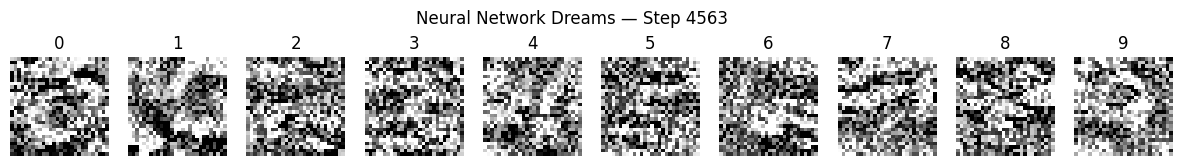

In [15]:
# We freeze the model
net.eval()
for param in net.parameters():
    param.requires_grad = False

# Dreaming inputs
dream_images = torch.nn.Parameter(torch.randn(10, 1, 28, 28, device=device))
target_labels = torch.arange(10, device=device)  # tensor([0, 1, 2, ..., 9])
optimizer = torch.optim.Adam([dream_images], lr=0.001)

import matplotlib.pyplot as plt

dream_images_cpu = dream_images.detach().cpu()
fig, axes = plt.subplots(1, 10, figsize=(15, 2))
for i in range(10):
    axes[i].imshow(dream_images_cpu[i][0], cmap='gray')
    axes[i].axis('off')
    axes[i].set_title(str(i))
plt.suptitle("Neural Network Dreams: Initial Dream Images")
step = 0
#plt.savefig(f"frame_{step:04d}_task1.png")

confidences = torch.zeros(10, device=device)
step = 0

while torch.all(confidences < 0.999):
    step += 1

    # Save the frames
    if step % 1000 == 0:
      fig, axes = plt.subplots(1, 10, figsize=(15, 2))
      dream_images_cpu = dream_images.detach().cpu()
      for i in range(10):
            axes[i].imshow(dream_images_cpu[i][0], cmap='gray')
            axes[i].axis('off')
            axes[i].set_title(str(i))
      plt.suptitle(f"Neural Network Dreams — Step {step}")
      plt.savefig(f"frame_{step:04d}_task1_hw10.png")
      plt.show()
      plt.close(fig)

    # Optimization process
    optimizer.zero_grad()
    outputs = net(dream_images)

    loss = torch.nn.functional.cross_entropy(outputs, target_labels)  # Encourage each image to be classified correctly
    loss.backward()
    optimizer.step()

    with torch.no_grad():
        probs = torch.softmax(outputs, dim=1)
        confidences = probs[torch.arange(10), target_labels]

    # Clamp pixel range to prevent extreme values
    with torch.no_grad():
      dream_images.clamp_(-1.0, 1.0)

    if step % 1000 == 0:
        print(f"Step {step}, Loss: {loss.item():.4f}, Confidences: {confidences}")


# Final image
dream_images_cpu = dream_images.detach().cpu()
fig, axes = plt.subplots(1, 10, figsize=(15, 2))
for i in range(10):
    axes[i].imshow(dream_images_cpu[i][0], cmap='gray')
    axes[i].axis('off')
    axes[i].set_title(str(i))
plt.suptitle(f"Neural Network Dreams — Step {step}")
plt.show()


 L2 Penalty λ = 0.001


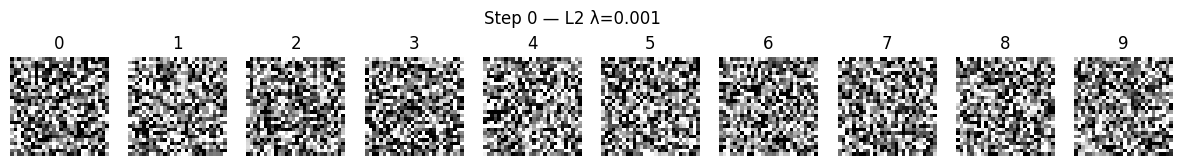

Step 0 — Loss: 3.9905, CE: 3.9895, L2: 0.0010, Confidences: tensor([0.0669, 0.0014, 0.0431, 0.1126, 0.0049, 0.1182, 0.0006, 0.0343, 0.3756,
        0.0026], device='cuda:0')


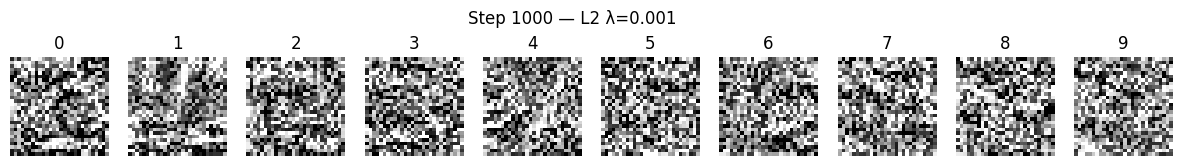

Step 1000 — Loss: 0.0617, CE: 0.0612, L2: 0.0005, Confidences: tensor([0.9274, 0.8493, 0.9791, 0.9735, 0.9326, 0.9819, 0.9434, 0.9521, 0.9796,
        0.8962], device='cuda:0')


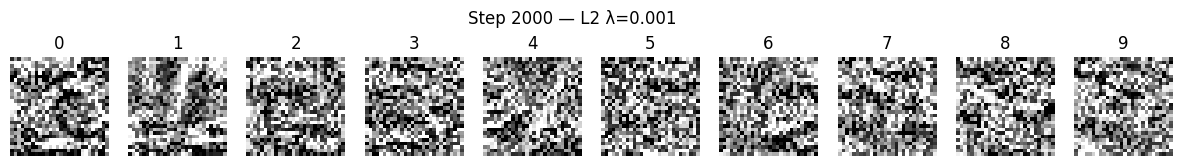

Step 2000 — Loss: 0.0186, CE: 0.0181, L2: 0.0005, Confidences: tensor([0.9759, 0.9625, 0.9935, 0.9918, 0.9789, 0.9936, 0.9804, 0.9864, 0.9935,
        0.9643], device='cuda:0')


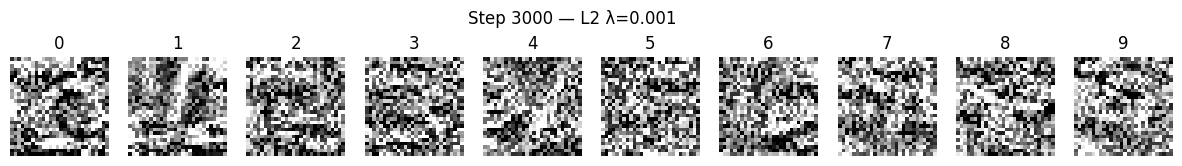

Step 3000 — Loss: 0.0089, CE: 0.0084, L2: 0.0005, Confidences: tensor([0.9884, 0.9819, 0.9968, 0.9962, 0.9911, 0.9969, 0.9902, 0.9953, 0.9971,
        0.9825], device='cuda:0')


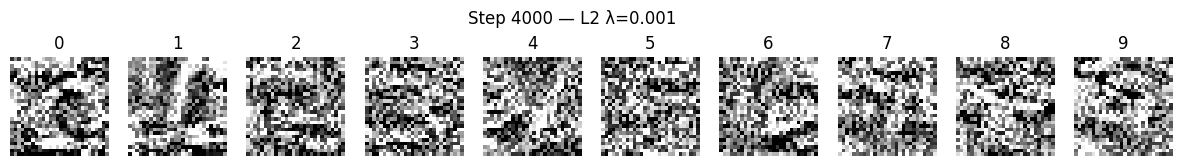

Step 4000 — Loss: 0.0051, CE: 0.0046, L2: 0.0005, Confidences: tensor([0.9941, 0.9897, 0.9982, 0.9979, 0.9953, 0.9983, 0.9944, 0.9976, 0.9984,
        0.9902], device='cuda:0')


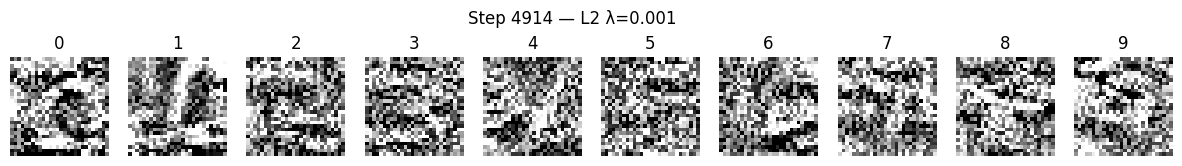

Predictions: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

 L2 Penalty λ = 0.01


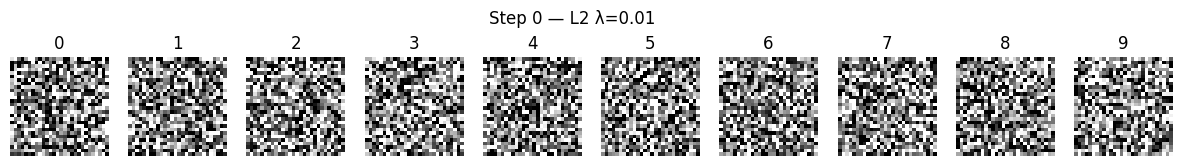

Step 0 — Loss: 4.0913, CE: 4.0812, L2: 0.0100, Confidences: tensor([0.0651, 0.0017, 0.0121, 0.1376, 0.0219, 0.0266, 0.0028, 0.0136, 0.1670,
        0.0028], device='cuda:0')


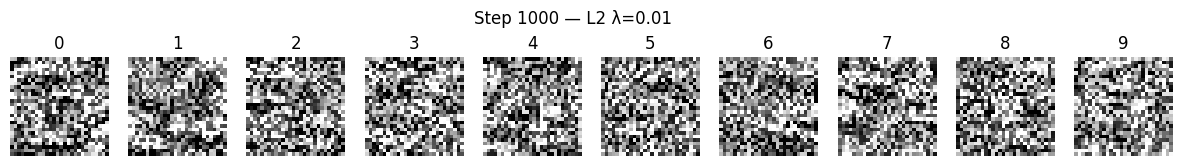

Step 1000 — Loss: 0.0603, CE: 0.0557, L2: 0.0046, Confidences: tensor([0.9414, 0.8884, 0.9671, 0.9712, 0.9274, 0.9720, 0.9502, 0.9599, 0.9746,
        0.9099], device='cuda:0')


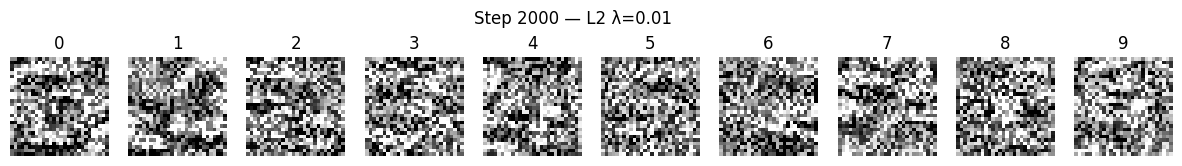

Step 2000 — Loss: 0.0224, CE: 0.0179, L2: 0.0045, Confidences: tensor([0.9805, 0.9621, 0.9907, 0.9899, 0.9751, 0.9911, 0.9836, 0.9896, 0.9915,
        0.9689], device='cuda:0')


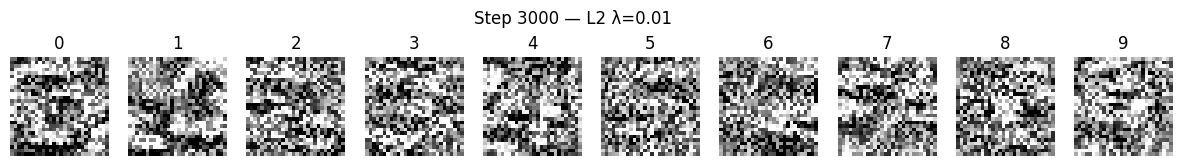

Step 3000 — Loss: 0.0128, CE: 0.0084, L2: 0.0045, Confidences: tensor([0.9911, 0.9829, 0.9955, 0.9950, 0.9883, 0.9958, 0.9921, 0.9960, 0.9955,
        0.9845], device='cuda:0')


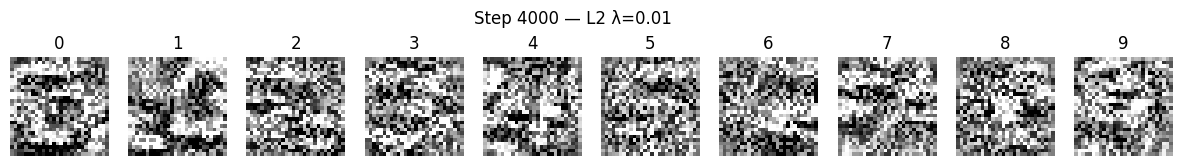

Step 4000 — Loss: 0.0089, CE: 0.0046, L2: 0.0043, Confidences: tensor([0.9952, 0.9916, 0.9974, 0.9971, 0.9936, 0.9977, 0.9956, 0.9978, 0.9974,
        0.9911], device='cuda:0')


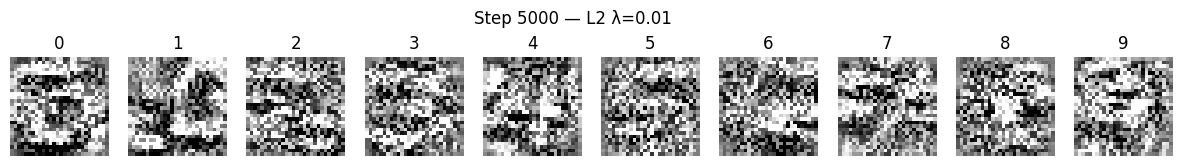

Step 5000 — Loss: 0.0068, CE: 0.0027, L2: 0.0041, Confidences: tensor([0.9970, 0.9951, 0.9984, 0.9982, 0.9970, 0.9987, 0.9973, 0.9987, 0.9984,
        0.9946], device='cuda:0')


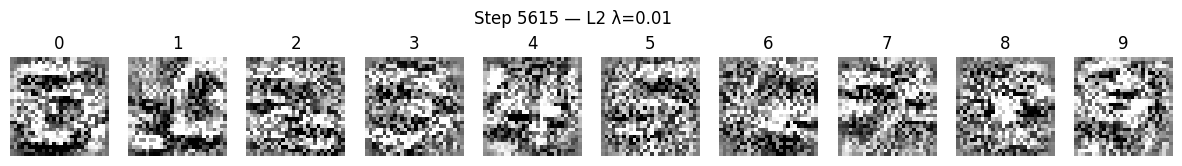

Predictions: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

 L2 Penalty λ = 0.1


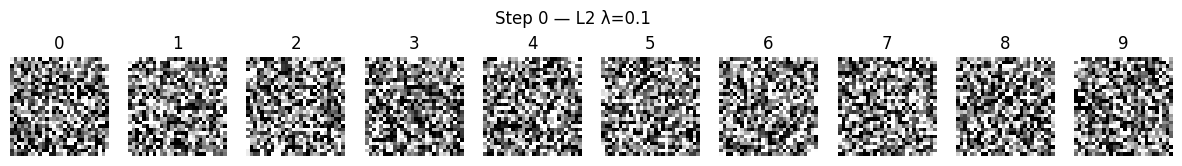

Step 0 — Loss: 3.8087, CE: 3.7073, L2: 0.1013, Confidences: tensor([1.1348e-01, 4.1957e-04, 2.9167e-01, 5.1884e-02, 1.1807e-02, 5.7029e-01,
        2.1489e-03, 7.3448e-03, 3.4926e-01, 2.9650e-03], device='cuda:0')


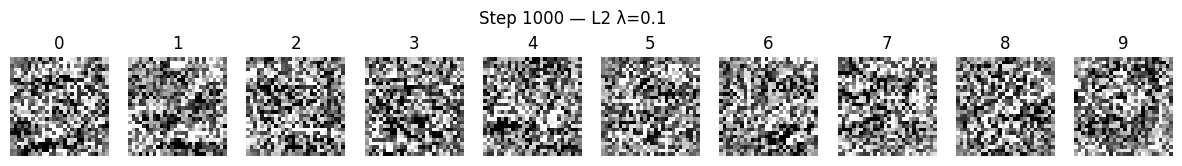

Step 1000 — Loss: 0.0944, CE: 0.0531, L2: 0.0413, Confidences: tensor([0.9388, 0.8790, 0.9750, 0.9731, 0.9390, 0.9853, 0.9517, 0.9578, 0.9744,
        0.9136], device='cuda:0')


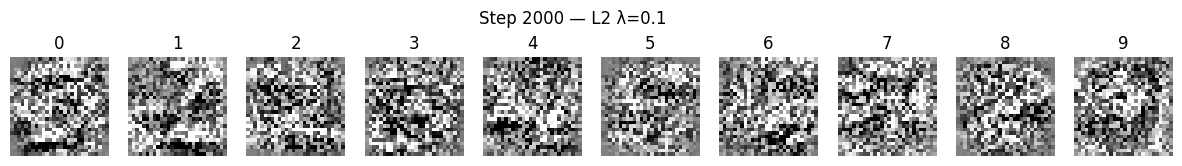

Step 2000 — Loss: 0.0525, CE: 0.0171, L2: 0.0355, Confidences: tensor([0.9839, 0.9615, 0.9912, 0.9904, 0.9793, 0.9949, 0.9831, 0.9870, 0.9902,
        0.9698], device='cuda:0')


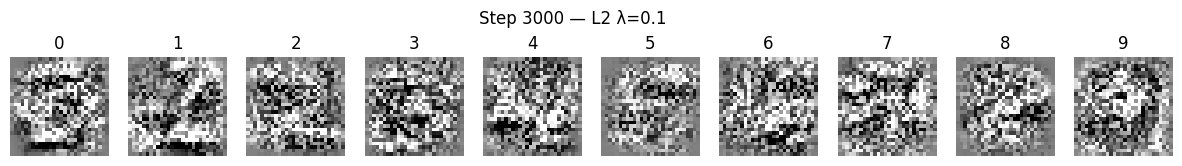

Step 3000 — Loss: 0.0382, CE: 0.0085, L2: 0.0297, Confidences: tensor([0.9915, 0.9829, 0.9952, 0.9948, 0.9895, 0.9971, 0.9915, 0.9934, 0.9950,
        0.9848], device='cuda:0')


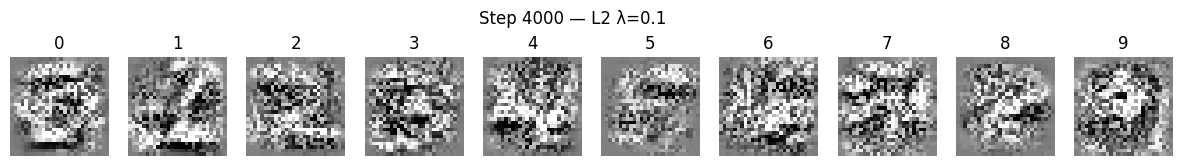

Step 4000 — Loss: 0.0296, CE: 0.0053, L2: 0.0243, Confidences: tensor([0.9940, 0.9903, 0.9967, 0.9965, 0.9936, 0.9979, 0.9948, 0.9957, 0.9968,
        0.9907], device='cuda:0')


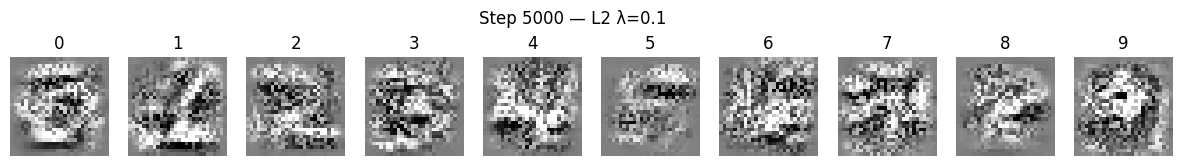

Step 5000 — Loss: 0.0232, CE: 0.0040, L2: 0.0193, Confidences: tensor([0.9951, 0.9934, 0.9974, 0.9972, 0.9953, 0.9983, 0.9961, 0.9969, 0.9973,
        0.9934], device='cuda:0')


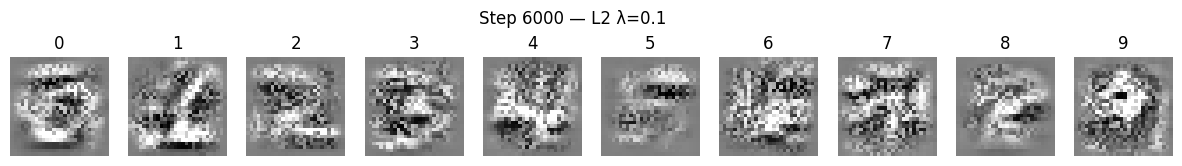

Step 6000 — Loss: 0.0183, CE: 0.0033, L2: 0.0150, Confidences: tensor([0.9955, 0.9947, 0.9977, 0.9976, 0.9962, 0.9985, 0.9968, 0.9975, 0.9976,
        0.9948], device='cuda:0')


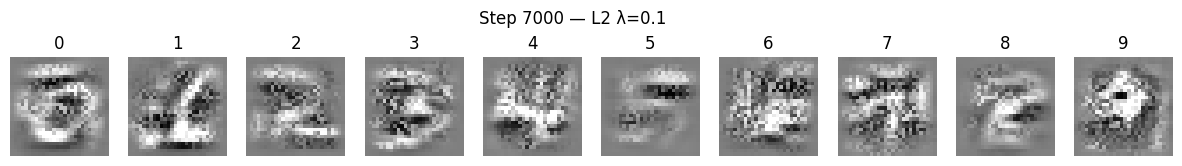

Step 7000 — Loss: 0.0148, CE: 0.0030, L2: 0.0118, Confidences: tensor([0.9958, 0.9952, 0.9981, 0.9977, 0.9969, 0.9986, 0.9972, 0.9976, 0.9977,
        0.9955], device='cuda:0')


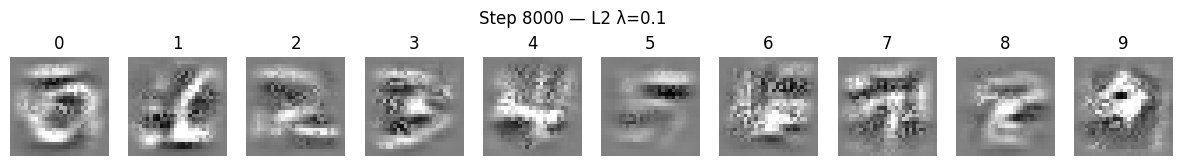

Step 8000 — Loss: 0.0126, CE: 0.0028, L2: 0.0098, Confidences: tensor([0.9960, 0.9954, 0.9981, 0.9978, 0.9972, 0.9986, 0.9974, 0.9978, 0.9978,
        0.9959], device='cuda:0')


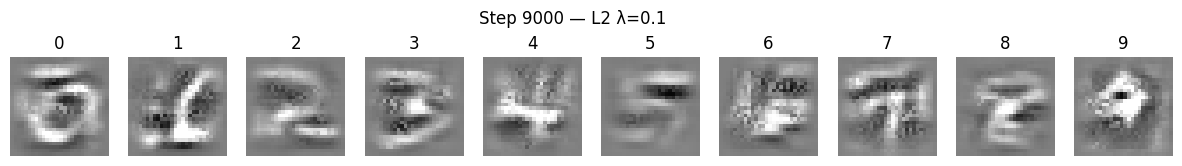

Step 9000 — Loss: 0.0114, CE: 0.0027, L2: 0.0087, Confidences: tensor([0.9961, 0.9954, 0.9982, 0.9979, 0.9974, 0.9986, 0.9975, 0.9980, 0.9977,
        0.9961], device='cuda:0')


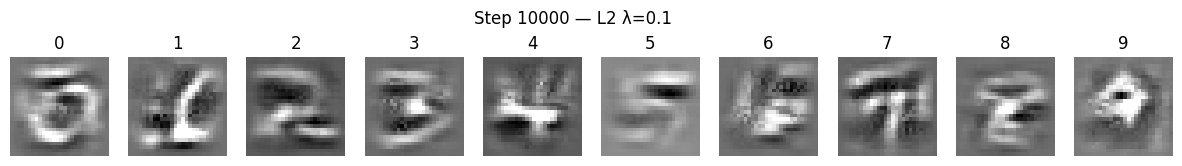

Predictions: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

 L2 Penalty λ = 1.0


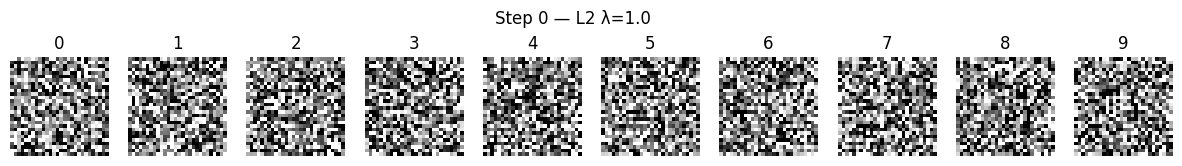

Step 0 — Loss: 5.0184, CE: 4.0015, L2: 1.0169, Confidences: tensor([0.0086, 0.0013, 0.0142, 0.1223, 0.0066, 0.1040, 0.0319, 0.0033, 0.2452,
        0.0125], device='cuda:0')


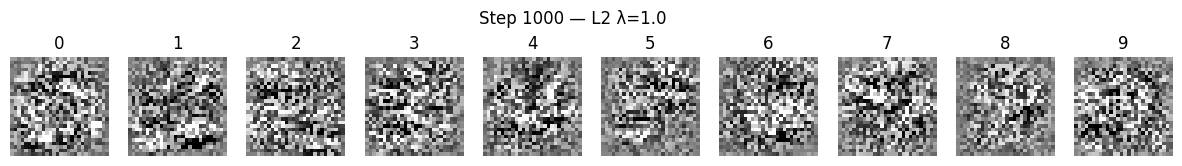

Step 1000 — Loss: 0.3364, CE: 0.0646, L2: 0.2718, Confidences: tensor([0.9264, 0.8628, 0.9711, 0.9555, 0.9362, 0.9783, 0.9518, 0.9527, 0.9668,
        0.8804], device='cuda:0')


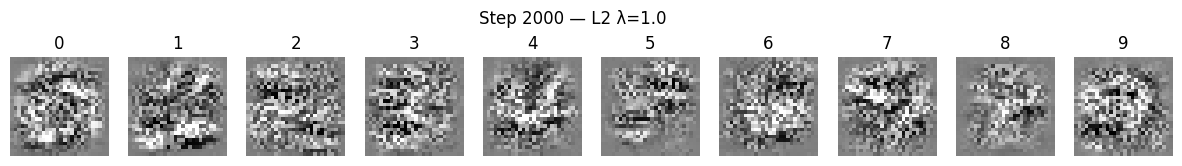

Step 2000 — Loss: 0.1837, CE: 0.0300, L2: 0.1537, Confidences: tensor([0.9607, 0.9393, 0.9841, 0.9763, 0.9754, 0.9862, 0.9768, 0.9771, 0.9809,
        0.9488], device='cuda:0')


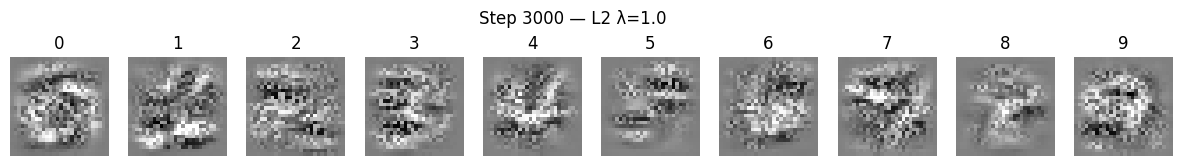

Step 3000 — Loss: 0.1135, CE: 0.0226, L2: 0.0909, Confidences: tensor([0.9698, 0.9555, 0.9867, 0.9797, 0.9828, 0.9881, 0.9810, 0.9816, 0.9840,
        0.9675], device='cuda:0')


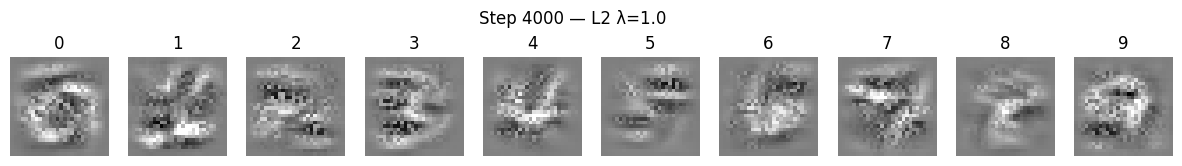

Step 4000 — Loss: 0.0800, CE: 0.0201, L2: 0.0600, Confidences: tensor([0.9729, 0.9623, 0.9880, 0.9825, 0.9847, 0.9889, 0.9814, 0.9834, 0.9848,
        0.9725], device='cuda:0')


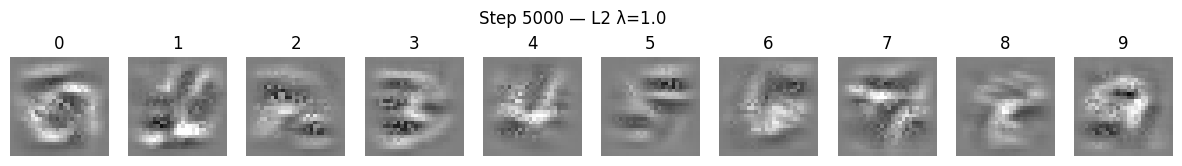

Step 5000 — Loss: 0.0659, CE: 0.0189, L2: 0.0471, Confidences: tensor([0.9738, 0.9659, 0.9883, 0.9833, 0.9860, 0.9892, 0.9822, 0.9848, 0.9850,
        0.9746], device='cuda:0')


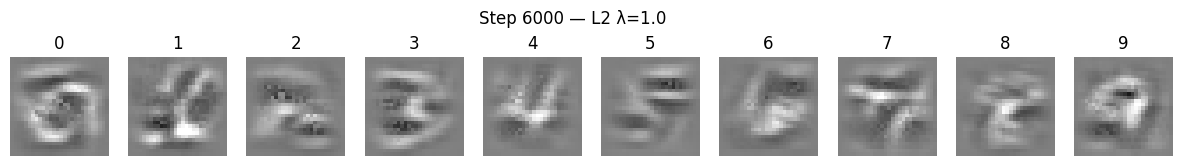

Step 6000 — Loss: 0.0600, CE: 0.0178, L2: 0.0422, Confidences: tensor([0.9740, 0.9715, 0.9885, 0.9848, 0.9873, 0.9893, 0.9827, 0.9848, 0.9851,
        0.9754], device='cuda:0')


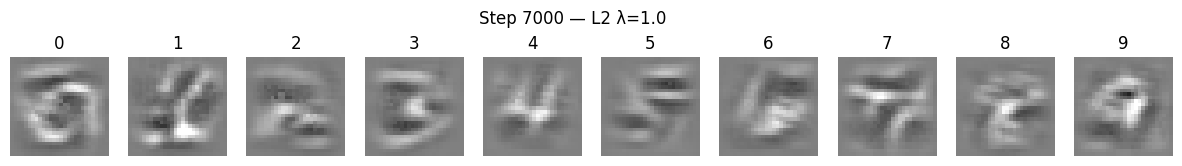

Step 7000 — Loss: 0.0575, CE: 0.0173, L2: 0.0402, Confidences: tensor([0.9741, 0.9720, 0.9887, 0.9860, 0.9878, 0.9894, 0.9829, 0.9849, 0.9851,
        0.9778], device='cuda:0')


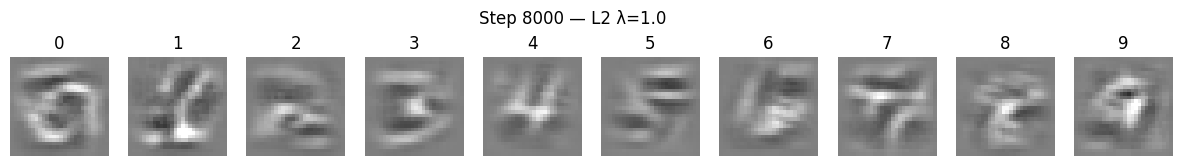

Step 8000 — Loss: 0.0565, CE: 0.0170, L2: 0.0395, Confidences: tensor([0.9741, 0.9729, 0.9888, 0.9865, 0.9882, 0.9894, 0.9833, 0.9850, 0.9851,
        0.9779], device='cuda:0')


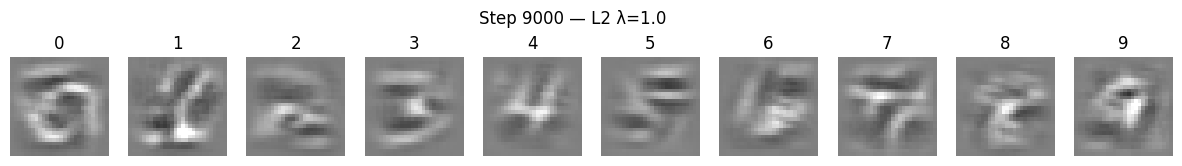

Step 9000 — Loss: 0.0565, CE: 0.0170, L2: 0.0394, Confidences: tensor([0.9741, 0.9729, 0.9888, 0.9866, 0.9882, 0.9894, 0.9833, 0.9849, 0.9851,
        0.9779], device='cuda:0')


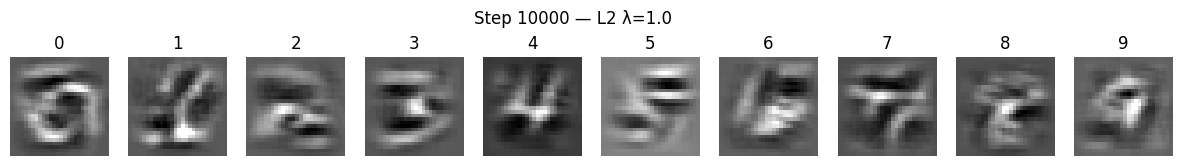

Predictions: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

 L2 Penalty λ = 10.0


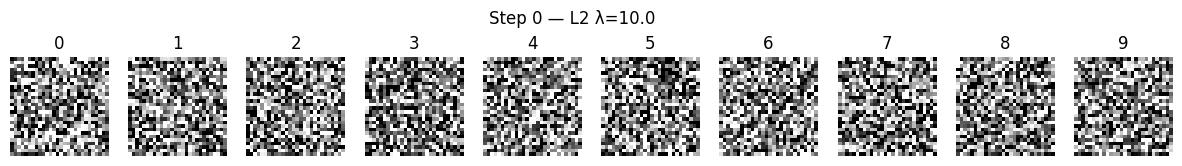

Step 0 — Loss: 13.6280, CE: 3.5994, L2: 10.0286, Confidences: tensor([3.3882e-02, 1.8441e-04, 1.3892e-01, 2.4719e-01, 3.2131e-03, 3.2081e-01,
        2.6605e-03, 3.3930e-02, 1.7053e-01, 6.8515e-02], device='cuda:0')


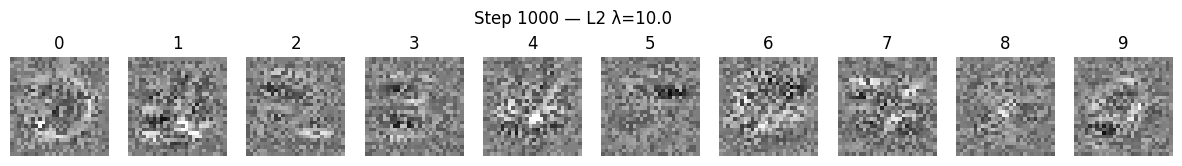

Step 1000 — Loss: 0.8744, CE: 0.1465, L2: 0.7278, Confidences: tensor([0.8131, 0.7978, 0.8848, 0.8892, 0.8841, 0.9119, 0.8775, 0.8675, 0.8922,
        0.8267], device='cuda:0')


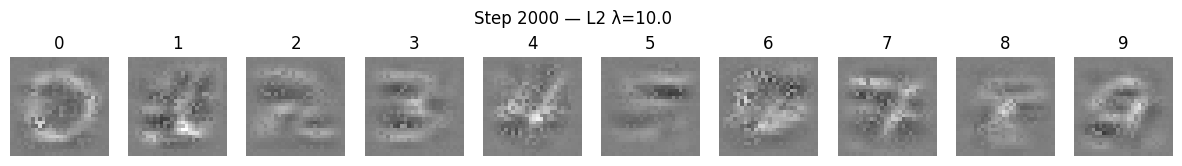

Step 2000 — Loss: 0.3063, CE: 0.1095, L2: 0.1968, Confidences: tensor([0.8478, 0.8511, 0.9281, 0.9098, 0.9228, 0.9367, 0.9034, 0.9019, 0.9092,
        0.8572], device='cuda:0')


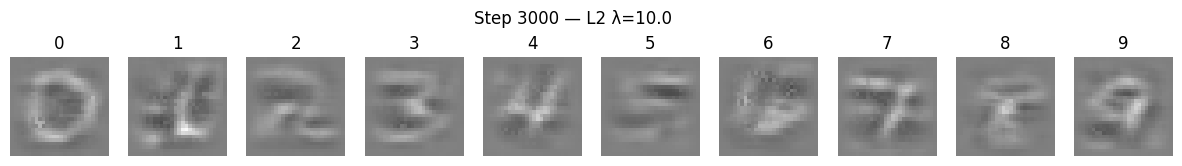

Step 3000 — Loss: 0.2591, CE: 0.1027, L2: 0.1564, Confidences: tensor([0.8528, 0.8612, 0.9322, 0.9169, 0.9278, 0.9390, 0.9071, 0.9103, 0.9147,
        0.8671], device='cuda:0')


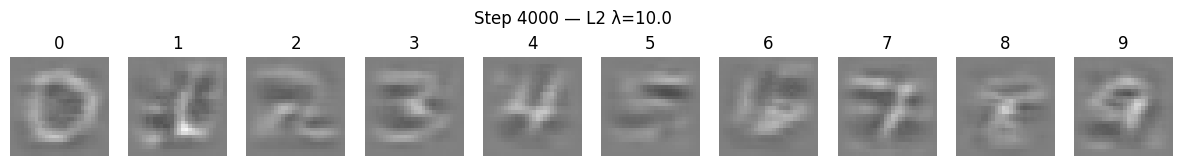

Step 4000 — Loss: 0.2559, CE: 0.1015, L2: 0.1544, Confidences: tensor([0.8542, 0.8630, 0.9325, 0.9177, 0.9291, 0.9393, 0.9081, 0.9117, 0.9154,
        0.8686], device='cuda:0')


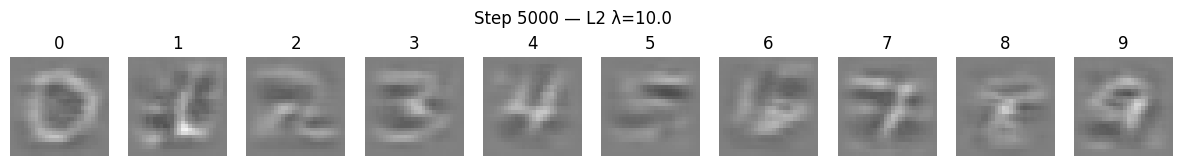

Step 5000 — Loss: 0.2557, CE: 0.1013, L2: 0.1544, Confidences: tensor([0.8545, 0.8632, 0.9326, 0.9178, 0.9292, 0.9394, 0.9082, 0.9118, 0.9154,
        0.8688], device='cuda:0')


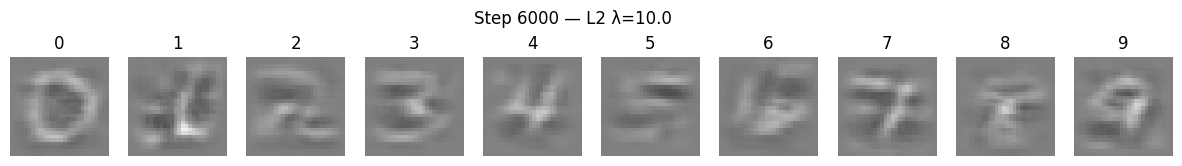

Step 6000 — Loss: 0.2557, CE: 0.1013, L2: 0.1544, Confidences: tensor([0.8545, 0.8632, 0.9326, 0.9178, 0.9292, 0.9394, 0.9082, 0.9119, 0.9155,
        0.8688], device='cuda:0')


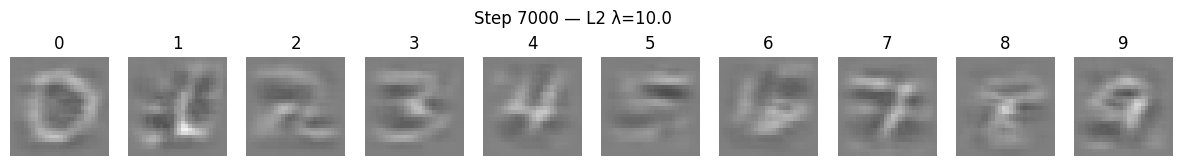

Step 7000 — Loss: 0.2558, CE: 0.1014, L2: 0.1544, Confidences: tensor([0.8545, 0.8631, 0.9326, 0.9179, 0.9292, 0.9394, 0.9082, 0.9118, 0.9154,
        0.8688], device='cuda:0')


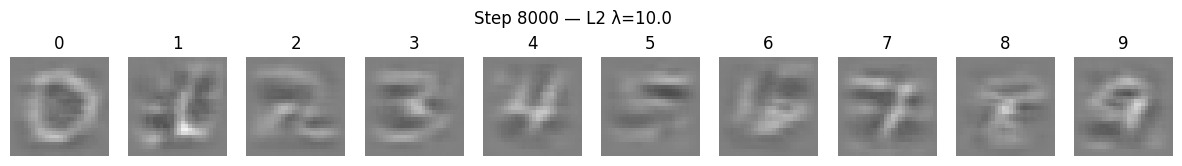

Step 8000 — Loss: 0.2558, CE: 0.1013, L2: 0.1544, Confidences: tensor([0.8545, 0.8632, 0.9326, 0.9178, 0.9292, 0.9394, 0.9083, 0.9119, 0.9155,
        0.8688], device='cuda:0')


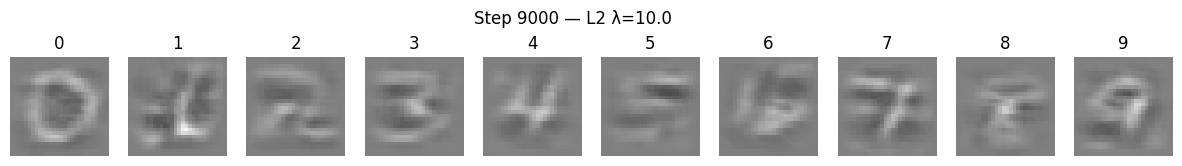

Step 9000 — Loss: 0.2558, CE: 0.1014, L2: 0.1544, Confidences: tensor([0.8546, 0.8631, 0.9325, 0.9178, 0.9292, 0.9393, 0.9083, 0.9118, 0.9154,
        0.8687], device='cuda:0')


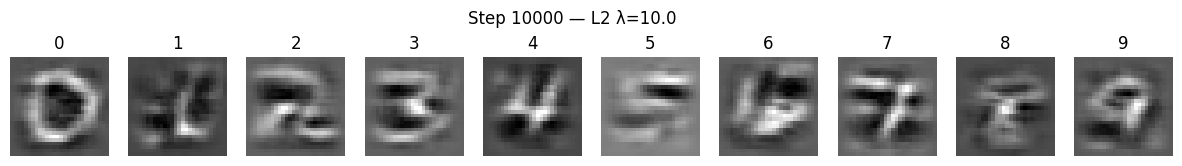

Predictions: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


In [14]:
# Define different regularization strengths to test
lambdas = [0.001, 0.01, 0.1, 1.0, 10.0]

for lambda_l2 in lambdas:
    print(f"\n L2 Penalty λ = {lambda_l2}")

    # Create trainable noise batch: 10 images
    dreamed_imgs = torch.nn.Parameter(torch.randn(10, 1, 28, 28, device=device))
    target_labels = torch.arange(10, device=device)
    optimizer = torch.optim.Adam([dreamed_imgs], lr=0.001)

    confidences = torch.zeros(10, device=device)
    step = 0

    while torch.all(confidences < 0.999) and step < 10000:
        # Save frame for current step and lambda
        if step % 1000 == 0:
          images_cpu = dreamed_imgs.detach().cpu()
          fig, axs = plt.subplots(1, 10, figsize=(15, 2))
          for i in range(10):
              axs[i].imshow(images_cpu[i][0], cmap='gray', vmin=-1.0, vmax=1.0)
              axs[i].axis('off')
              axs[i].set_title(str(i))
          plt.suptitle(f"Step {step} — L2 λ={lambda_l2}")
          plt.savefig(f"step_{step:05d}_lambda_{lambda_l2:.3f}_hw10.png")
          plt.show()
          plt.close(fig)

        optimizer.zero_grad()
        output = net(dreamed_imgs)  # Shape: [10, 10]
        ce_loss = torch.nn.functional.cross_entropy(output, target_labels)  # classification loss
        l2_penalty = lambda_l2 * dreamed_imgs.pow(2).mean()  # L2 penalty on pixel intensity

        loss = ce_loss + l2_penalty
        loss.backward()
        optimizer.step()

        with torch.no_grad():
          probs = torch.softmax(output, dim=1)
          confidences = probs[torch.arange(10), target_labels]

        with torch.no_grad():
            dreamed_imgs.clamp_(-1.0, 1.0)

        if step % 1000 == 0:
            print(f"Step {step} — Loss: {loss.item():.4f}, CE: {ce_loss.item():.4f}, L2: {l2_penalty.item():.4f}, Confidences: {confidences}")

        step += 1

    # Visualization
    images_cpu = dreamed_imgs.detach().cpu()
    fig, axs = plt.subplots(1, 10, figsize=(15, 2))
    for i in range(10):
        axs[i].imshow(images_cpu[i][0], cmap='gray')
        axs[i].axis('off')
        axs[i].set_title(str(i))
    plt.suptitle(f"Step {step} — L2 λ={lambda_l2}")
    plt.savefig(f"step_{step:05d}_lambda_{lambda_l2:.3f}_hw10.png")
    plt.show()

    # Prediction check
    with torch.no_grad():
        predictions = torch.argmax(net(dreamed_imgs), dim=1)
        print("Predictions:", predictions.cpu().tolist())


##Question 1: Are they more or less readable?  Why do you think that happens? Consider the CNN’s inductive biases and architectural properties.

The digits generated using the CNN (LeNet-5) are more readable than those produced by the MLP. Even without an L2 penalty, the CNN-generated images have more structure and clearer digit-like shapes.

##Question 2: Do they resemble real MNIST digits more closely or less?
Yes, the CNN-generated digits more closely resemble real MNIST digits. The CNN encourages spatially coherent patterns and edges due to its convolutional architecture, while the MLP often produces noisy blobs or pixel-wise artifacts because it lacks a notion of local structure.

##Question 3: Why do you think that happens? Consider the CNN’s inductive biases and architectural properties.
This happens due to the inductive biases and architectural properties of CNNs:

- CNNs use convutional filters that look at only a small part of the image at a time. This allows them to detect patterns like lines, curves, and edges.
- Also, weight sharing in convolutions helps the CNN recognize patterns no matter where they appear, and ensures the features it learns are consistent throughout the image.
- The architecture of LeNet-5 favors locally connected patterns, unlike MLPs which treat all pixels independently.

As a result, CNNs tend to "dream" digits that are more coherent.

Furthermore, adding an L2 penalty helps both models avoid noisy solutions, but the CNN benefits more because its structure already promotes realistic features.

## Task 2 – Adversarial Examples: Fooling LeNet-5

=== Results for Lambda = 0 ===
Step 0 — Loss: 7.0299, CE: 7.0299, L2: 0.000000
Sample predictions: [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
Step 50 — Loss: 6.2123, CE: 6.2123, L2: 0.000000
Sample predictions: [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
Step 100 — Loss: 5.3384, CE: 5.3384, L2: 0.000000
Sample predictions: [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
Step 150 — Loss: 4.5001, CE: 4.5001, L2: 0.000000
Sample predictions: [0, 0, 0, 0, 0, 0, 0, 0, 0, 6]
Step 200 — Loss: 3.7022, CE: 3.7022, L2: 0.000000
Sample predictions: [0, 0, 0, 0, 0, 0, 0, 0, 0, 6]
Step 250 — Loss: 2.9705, CE: 2.9705, L2: 0.000000
Sample predictions: [0, 0, 0, 0, 0, 0, 0, 0, 0, 6]
Step 300 — Loss: 2.3716, CE: 2.3716, L2: 0.000000
Sample predictions: [0, 0, 0, 0, 0, 0, 0, 0, 0, 6]
Step 350 — Loss: 1.9191, CE: 1.9191, L2: 0.000000
Sample predictions: [0, 0, 0, 0, 2, 0, 0, 0, 0, 6]
Step 399 — Loss: 1.5564, CE: 1.5564, L2: 0.000000
Sample predictions: [0, 0, 0, 0, 2, 2, 0, 0, 0, 6]

Success rate of attacks: 52/90 (57.78%)


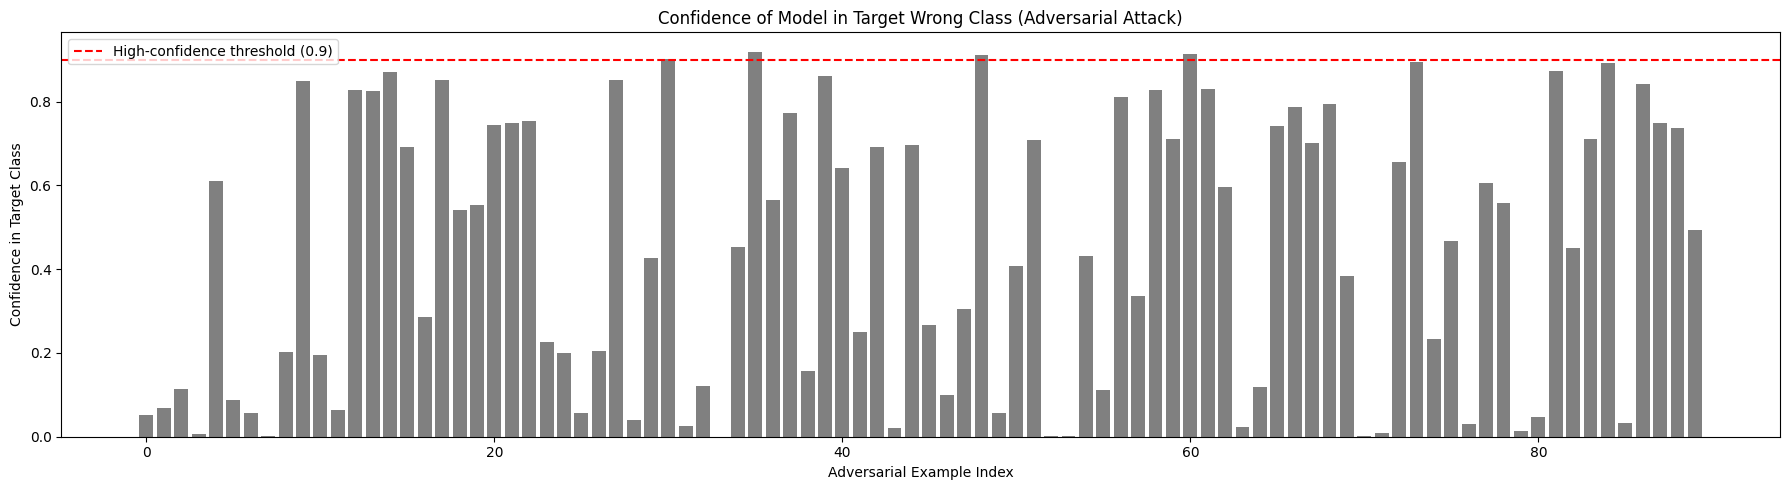

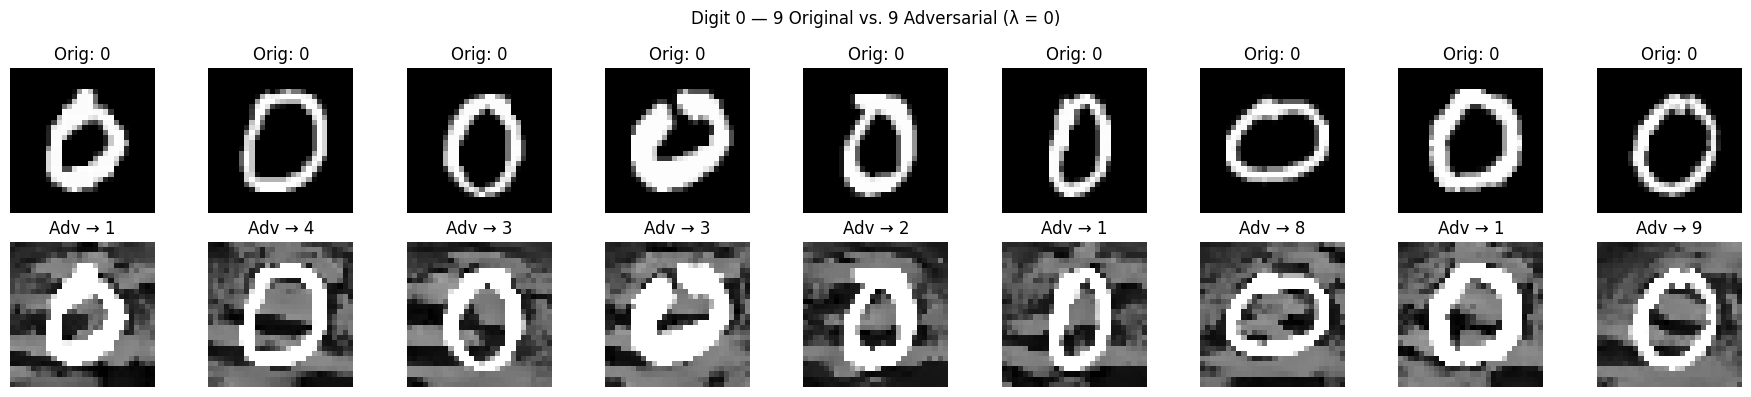

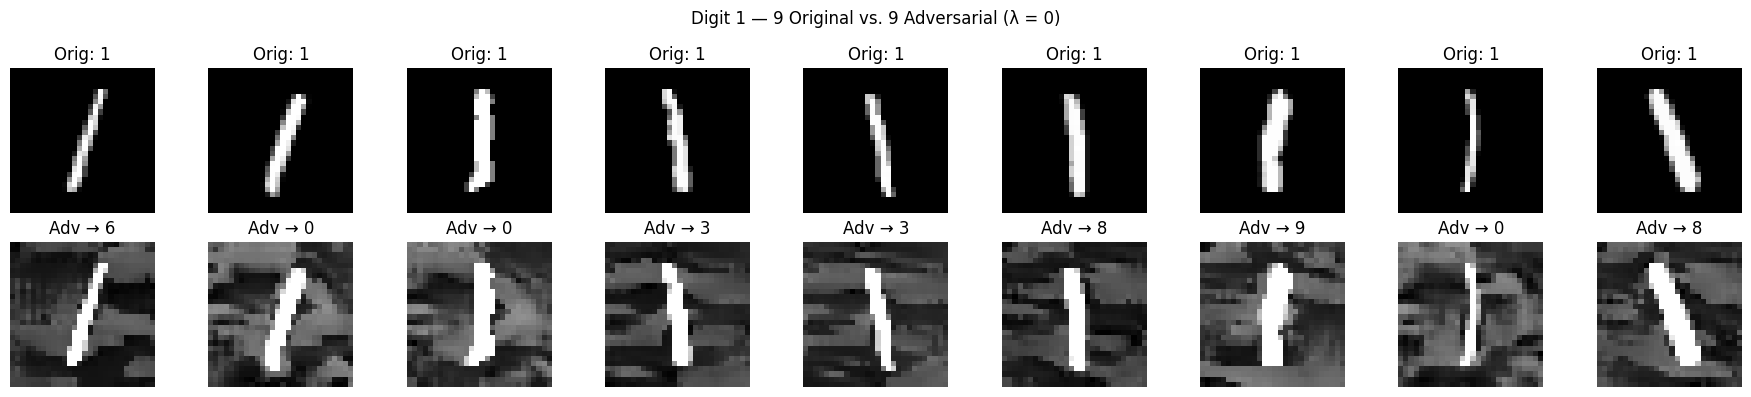

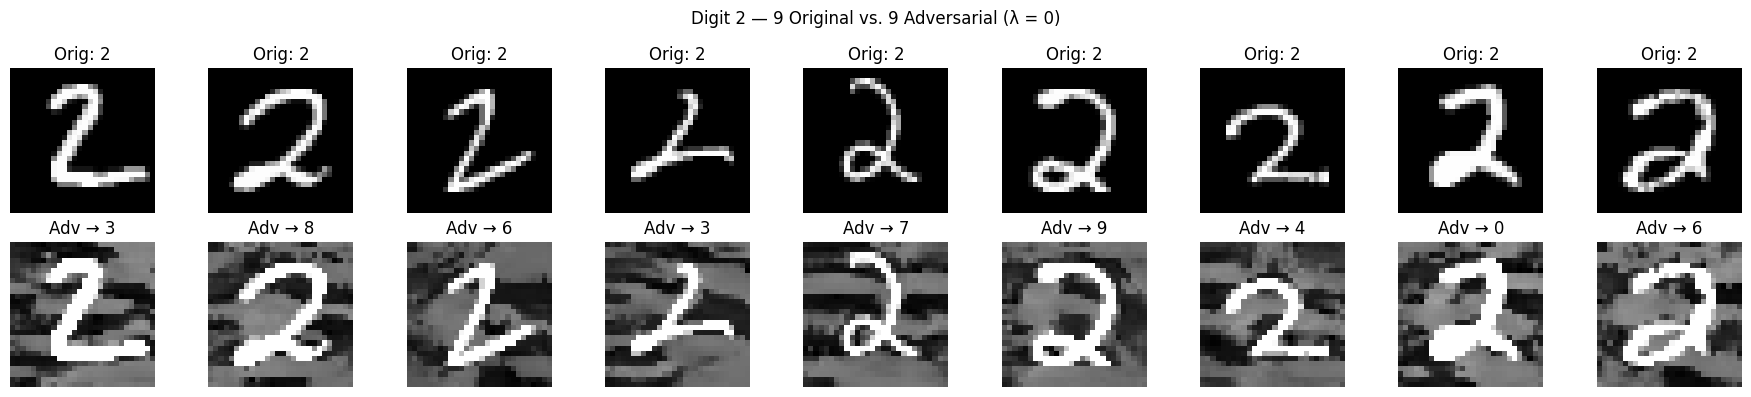

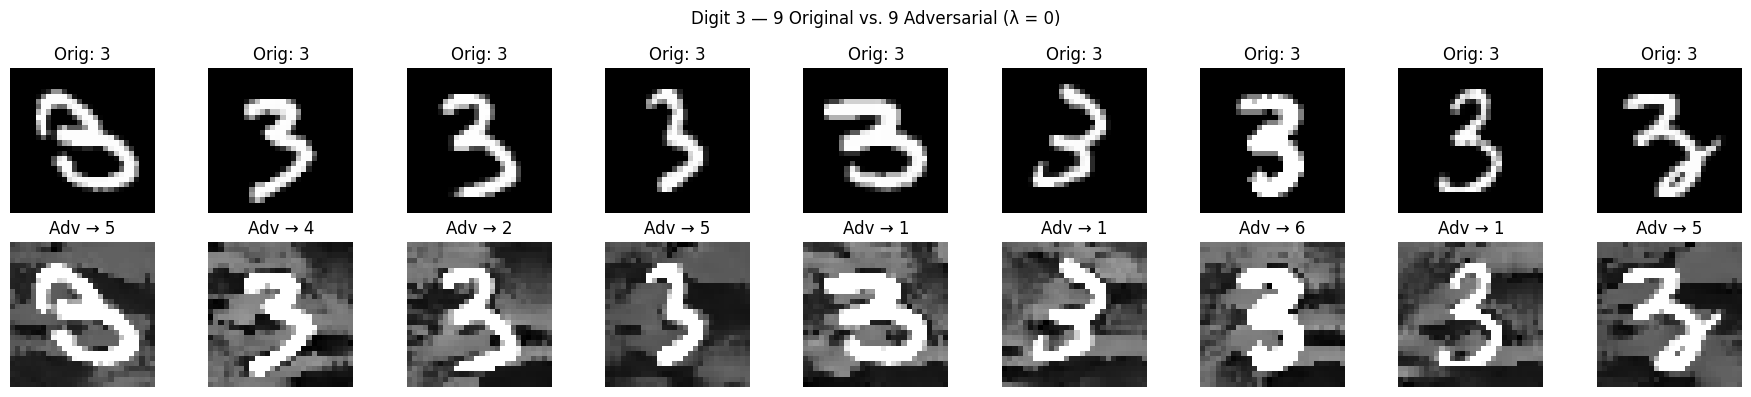

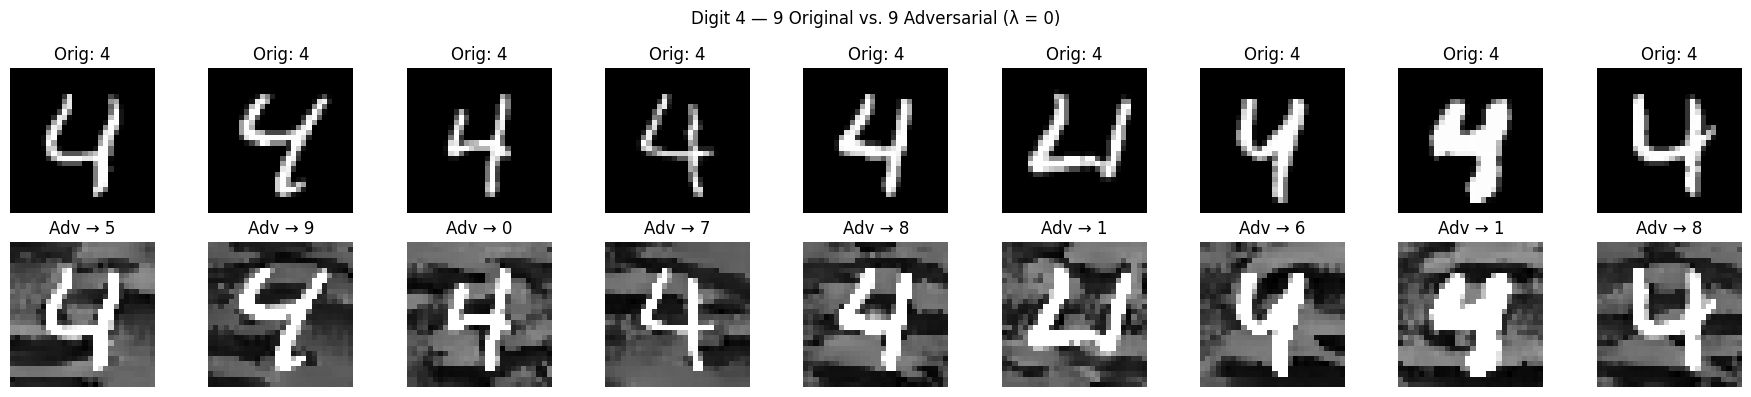

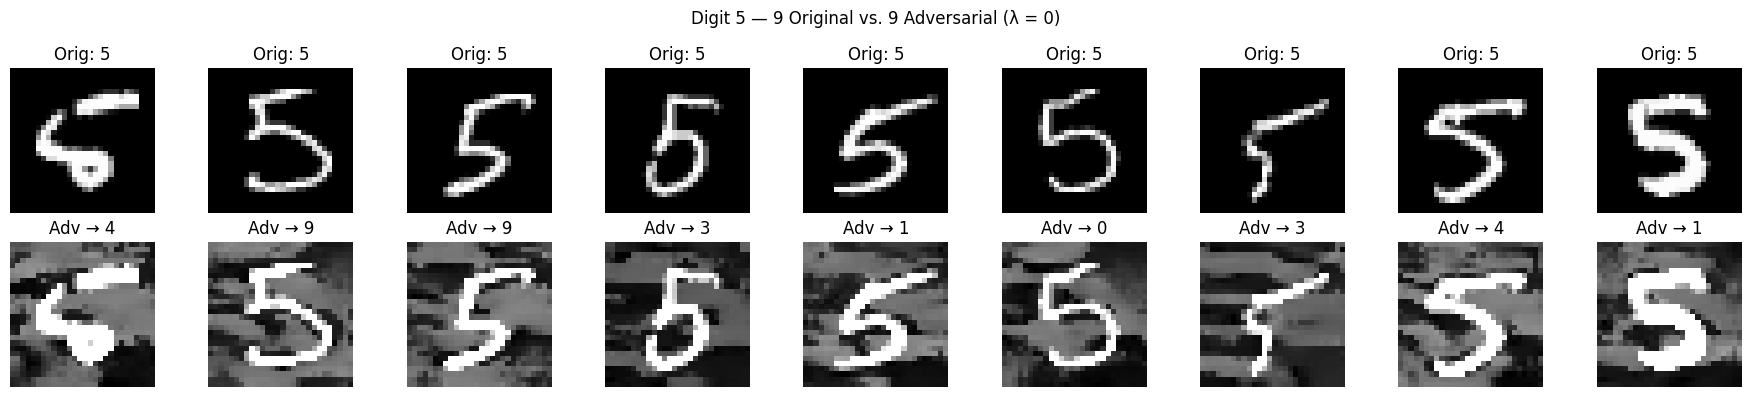

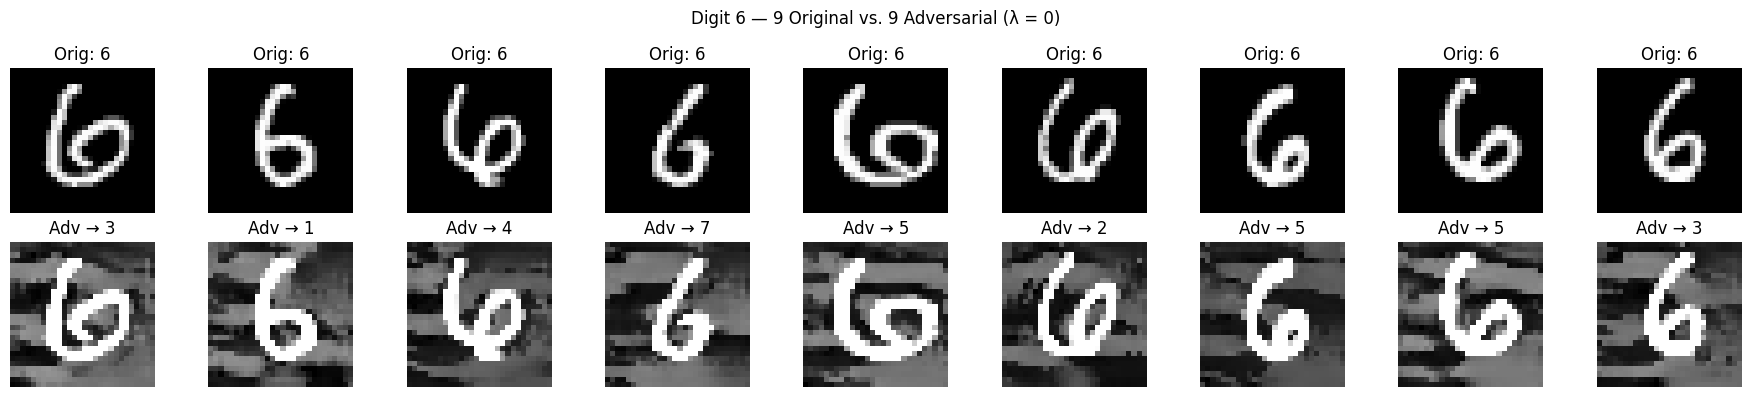

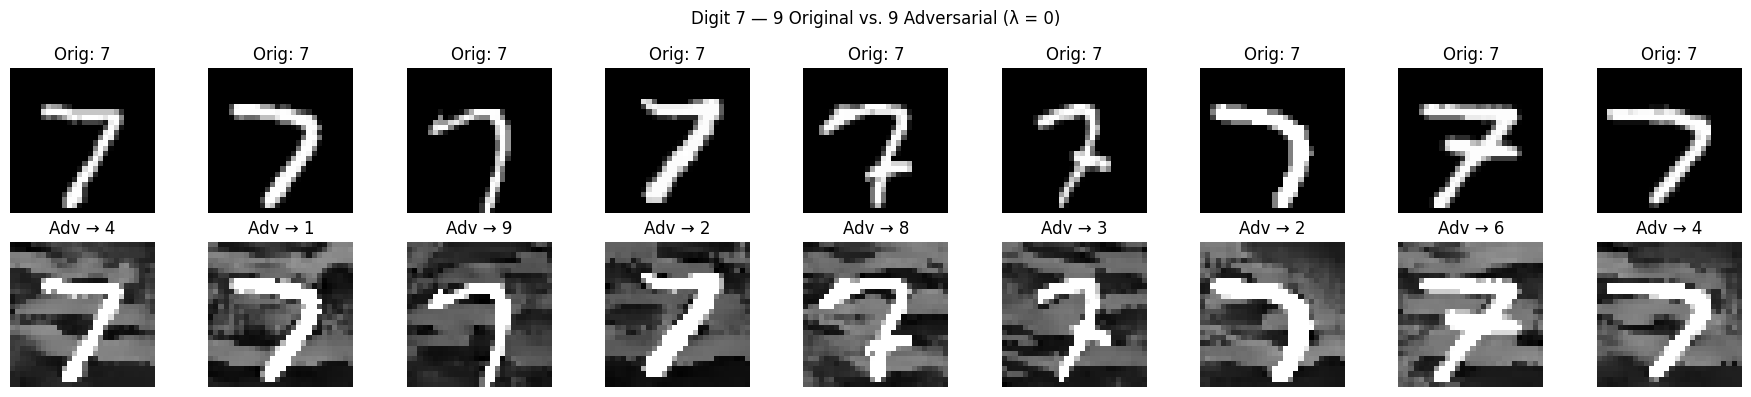

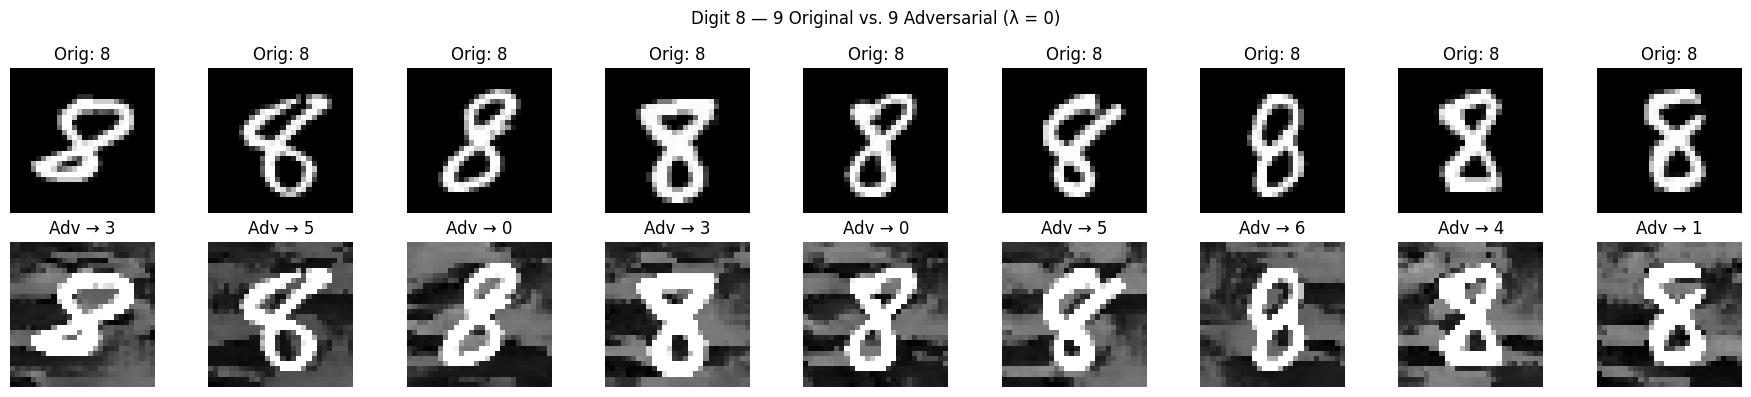

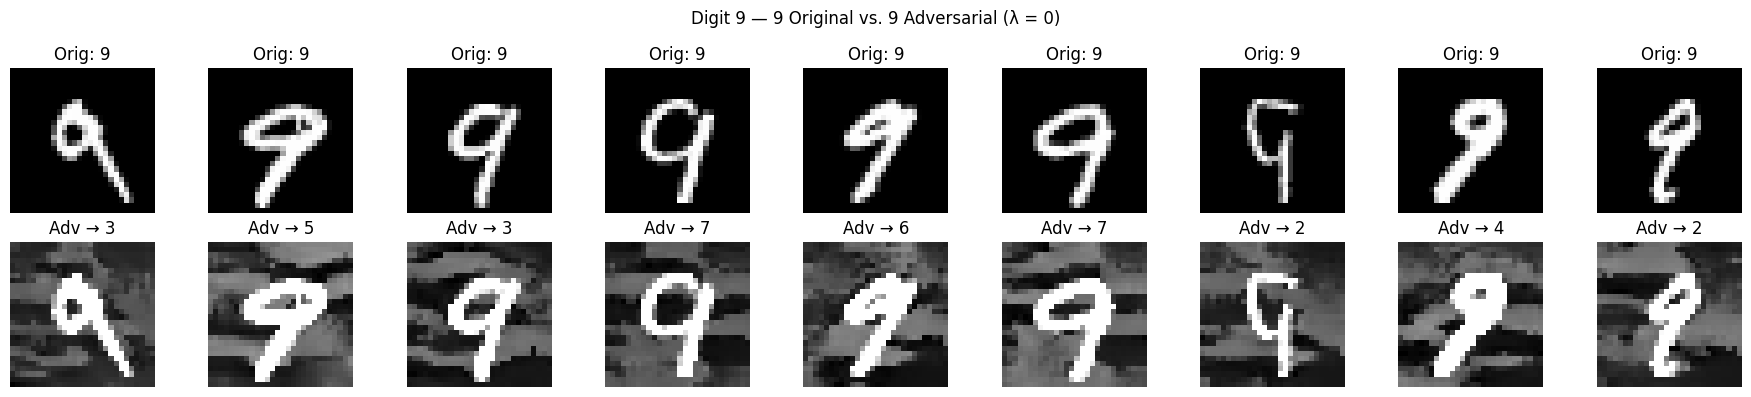

=== Results for Lambda = 0.0001 ===
Step 0 — Loss: 6.8844, CE: 6.8844, L2: 0.000000
Sample predictions: [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
Step 50 — Loss: 6.0568, CE: 6.0568, L2: 0.000000
Sample predictions: [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
Step 100 — Loss: 5.1510, CE: 5.1510, L2: 0.000001
Sample predictions: [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
Step 150 — Loss: 4.2784, CE: 4.2784, L2: 0.000002
Sample predictions: [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
Step 200 — Loss: 3.4627, CE: 3.4627, L2: 0.000003
Sample predictions: [0, 0, 0, 0, 0, 0, 0, 0, 0, 3]
Step 250 — Loss: 2.7209, CE: 2.7209, L2: 0.000004
Sample predictions: [0, 0, 0, 0, 0, 0, 0, 0, 0, 3]
Step 300 — Loss: 2.1141, CE: 2.1141, L2: 0.000005
Sample predictions: [0, 0, 0, 0, 0, 0, 0, 0, 5, 3]
Step 350 — Loss: 1.6355, CE: 1.6355, L2: 0.000007
Sample predictions: [0, 0, 0, 0, 0, 0, 0, 0, 5, 3]
Step 399 — Loss: 1.2744, CE: 1.2744, L2: 0.000008
Sample predictions: [0, 8, 0, 0, 0, 6, 0, 0, 5, 3]

Success rate of attacks: 59/90 (65.56%)


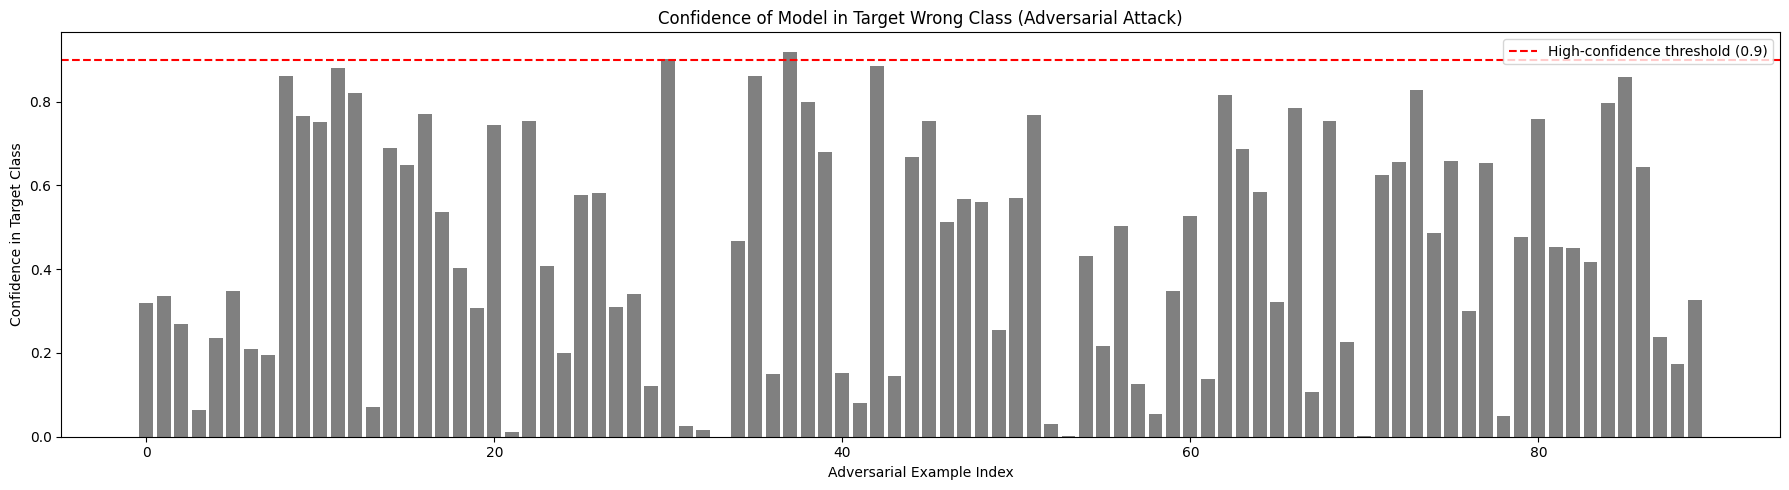

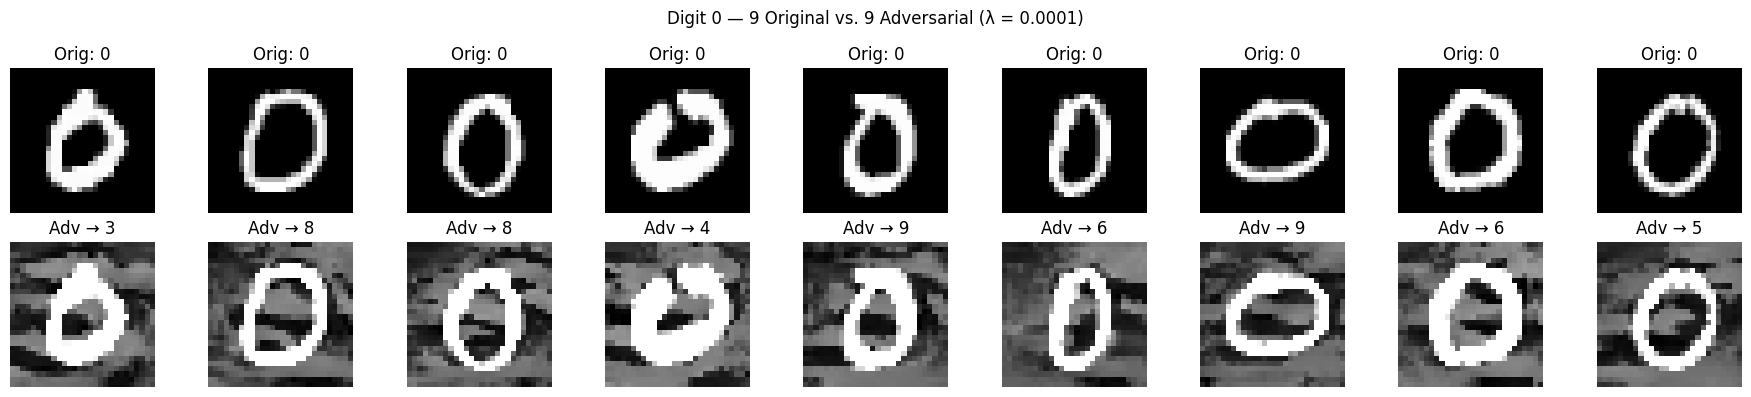

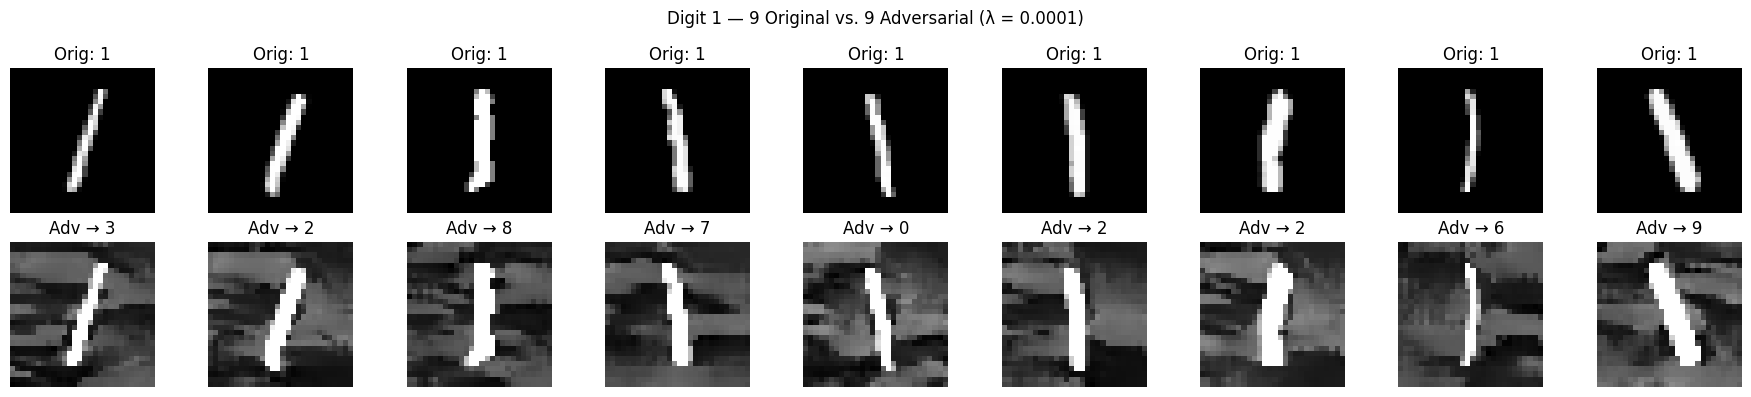

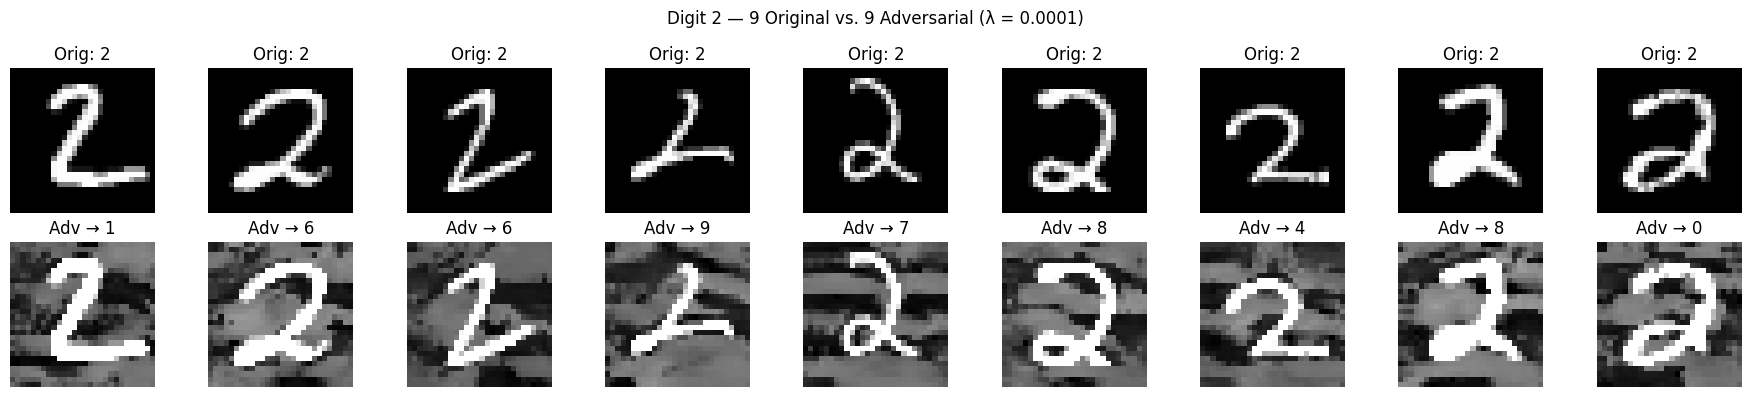

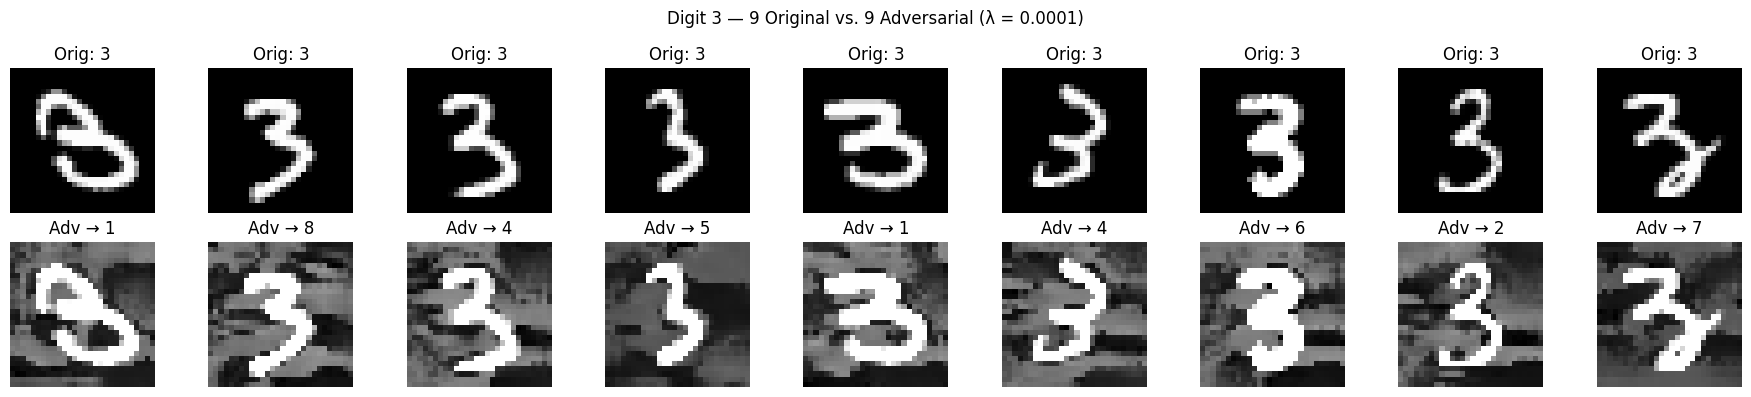

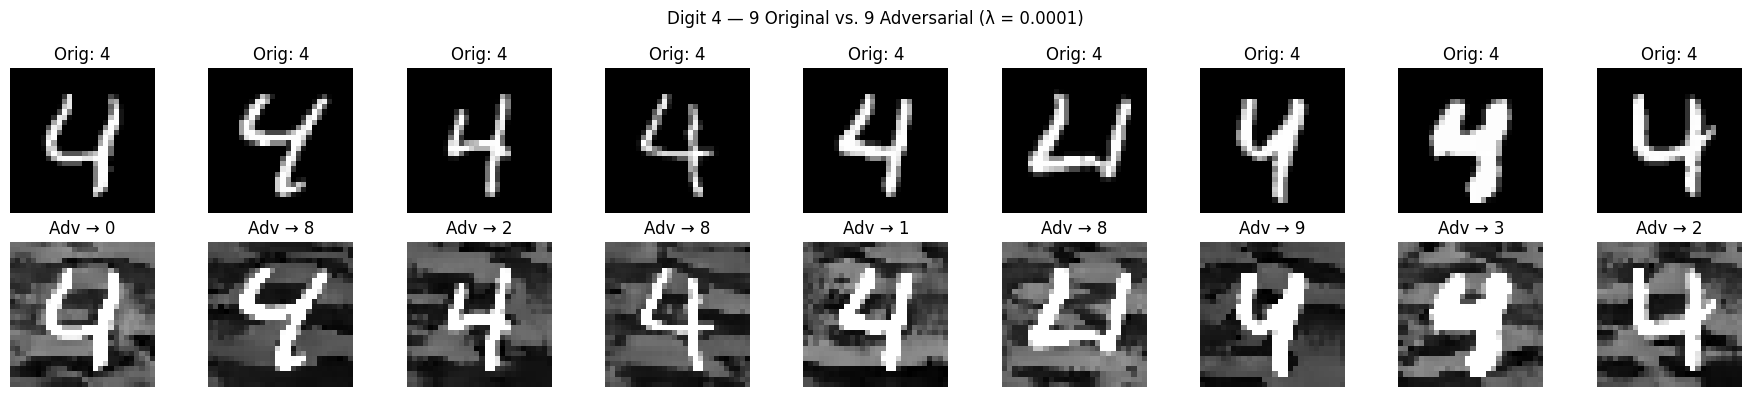

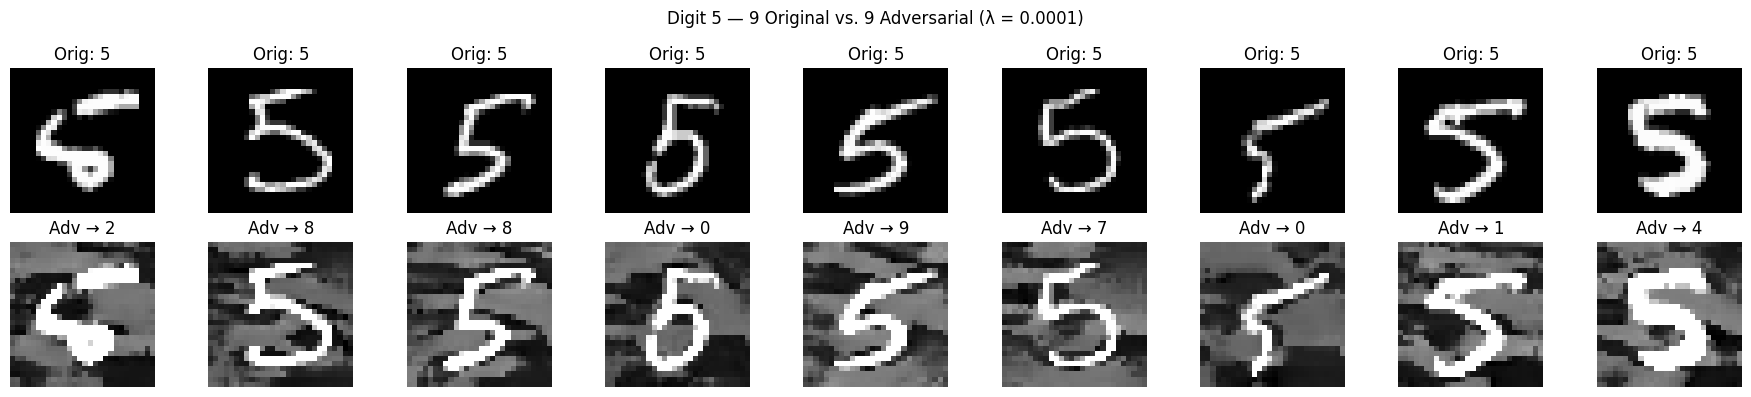

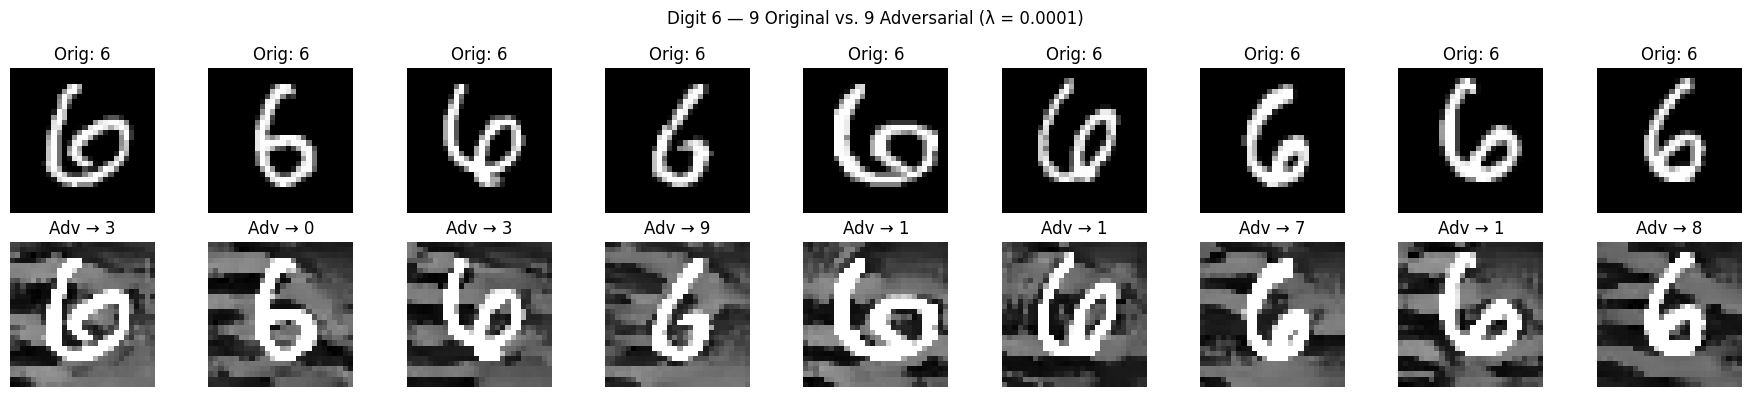

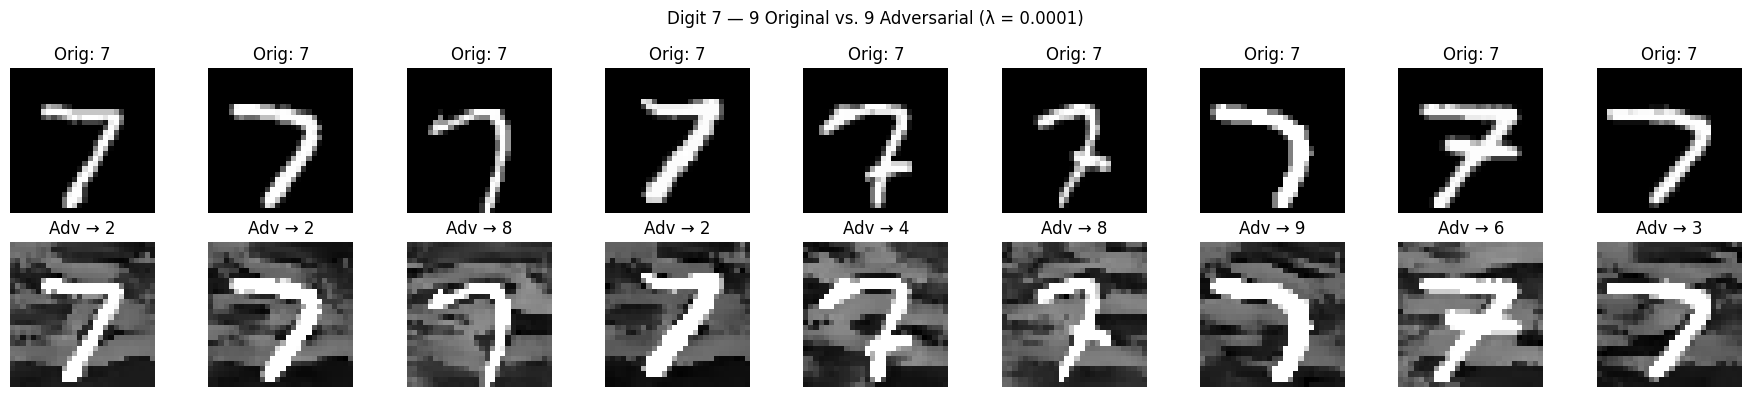

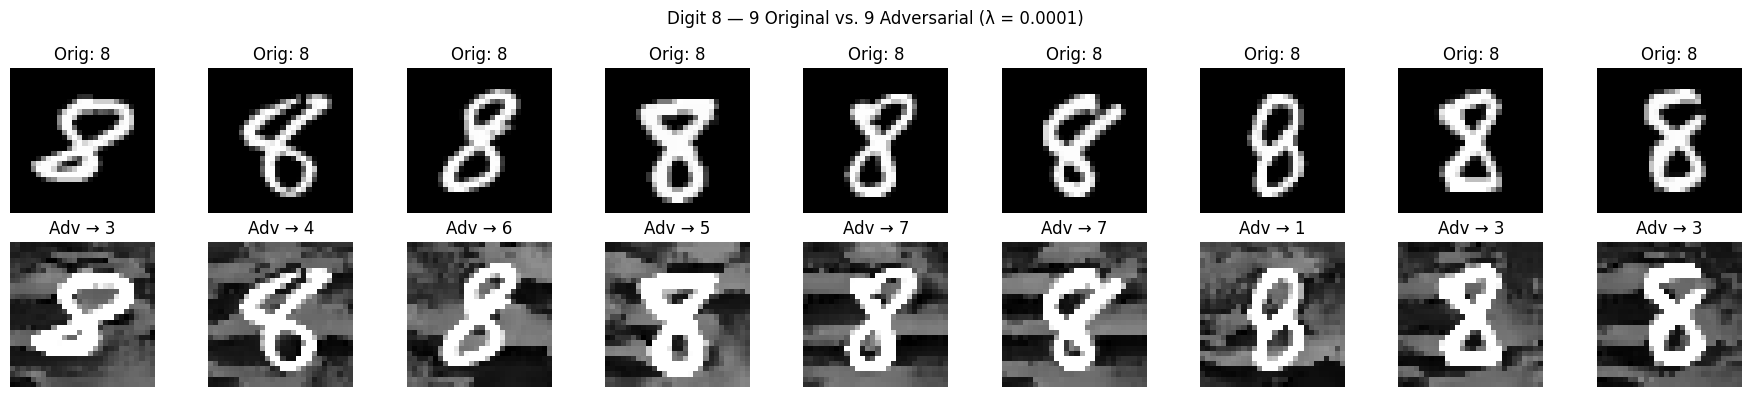

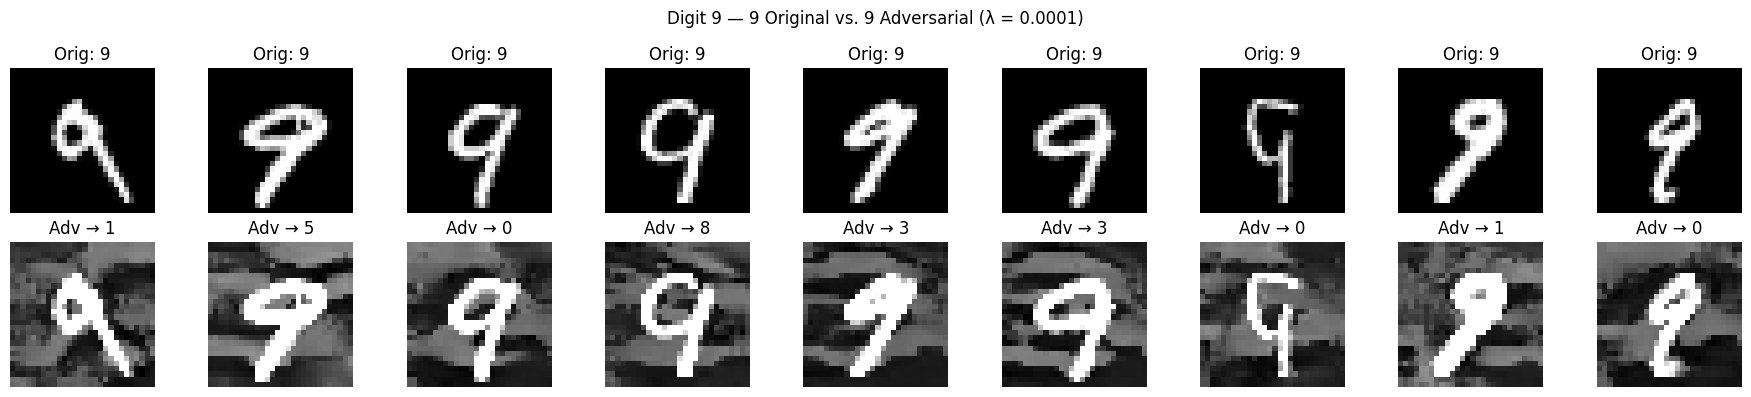

=== Results for Lambda = 0.001 ===
Step 0 — Loss: 7.2526, CE: 7.2526, L2: 0.000000
Sample predictions: [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
Step 50 — Loss: 6.3924, CE: 6.3924, L2: 0.000002
Sample predictions: [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
Step 100 — Loss: 5.4828, CE: 5.4828, L2: 0.000008
Sample predictions: [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
Step 150 — Loss: 4.6018, CE: 4.6018, L2: 0.000016
Sample predictions: [0, 0, 0, 0, 0, 0, 0, 0, 0, 8]
Step 200 — Loss: 3.7577, CE: 3.7577, L2: 0.000027
Sample predictions: [0, 0, 0, 0, 0, 0, 0, 0, 0, 8]
Step 250 — Loss: 2.9644, CE: 2.9643, L2: 0.000041
Sample predictions: [0, 0, 0, 0, 0, 0, 0, 0, 0, 8]
Step 300 — Loss: 2.3170, CE: 2.3170, L2: 0.000055
Sample predictions: [0, 0, 0, 0, 0, 3, 0, 0, 0, 8]
Step 350 — Loss: 1.8452, CE: 1.8452, L2: 0.000069
Sample predictions: [0, 0, 5, 0, 0, 3, 0, 0, 0, 8]
Step 399 — Loss: 1.4826, CE: 1.4825, L2: 0.000082
Sample predictions: [0, 0, 5, 0, 0, 3, 0, 0, 3, 8]

Success rate of attacks: 56/90 (62.22%)


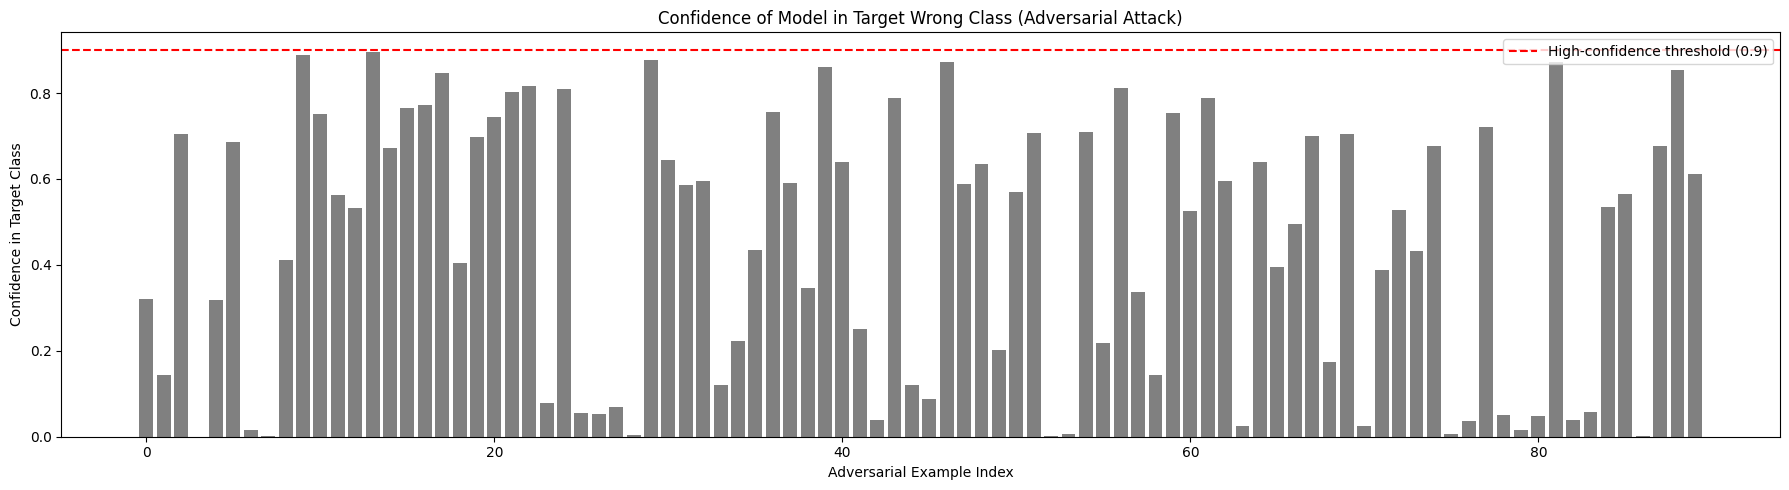

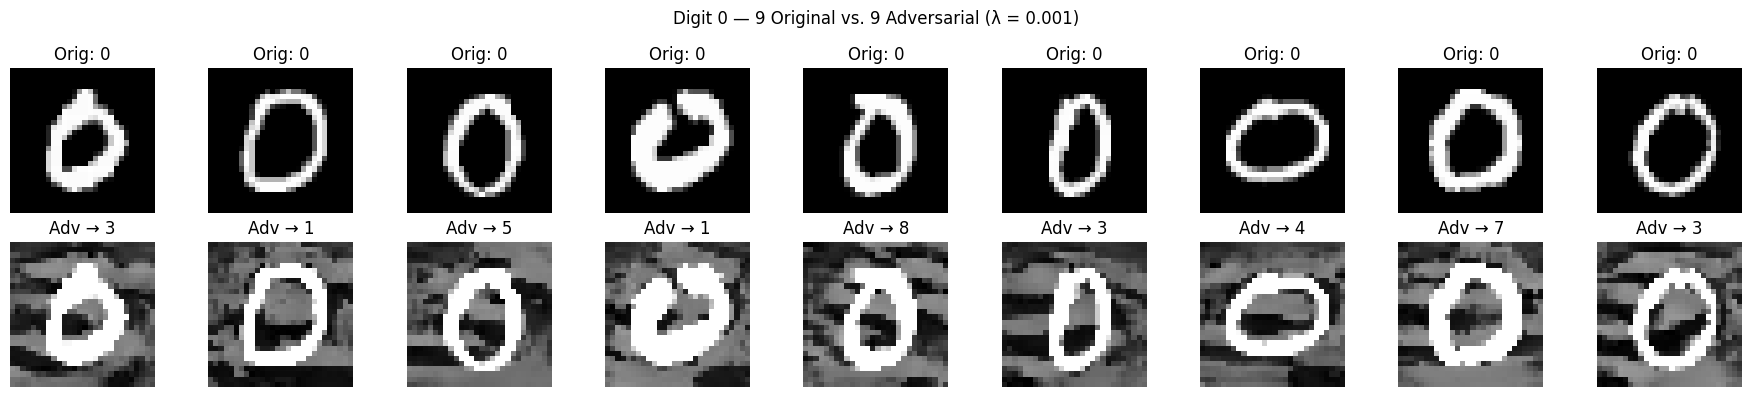

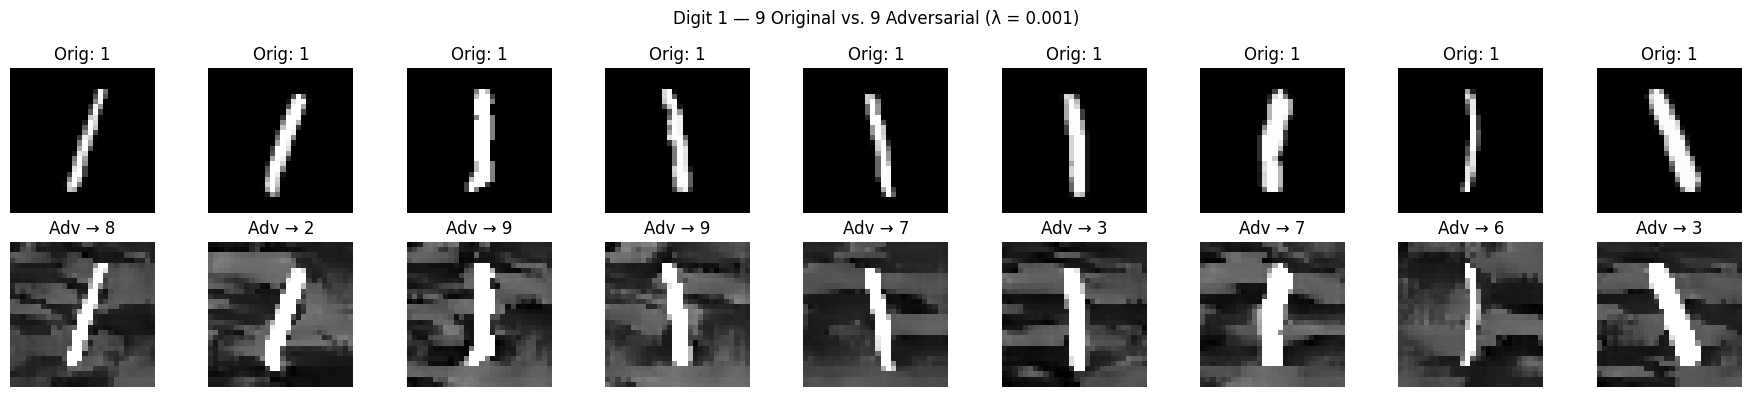

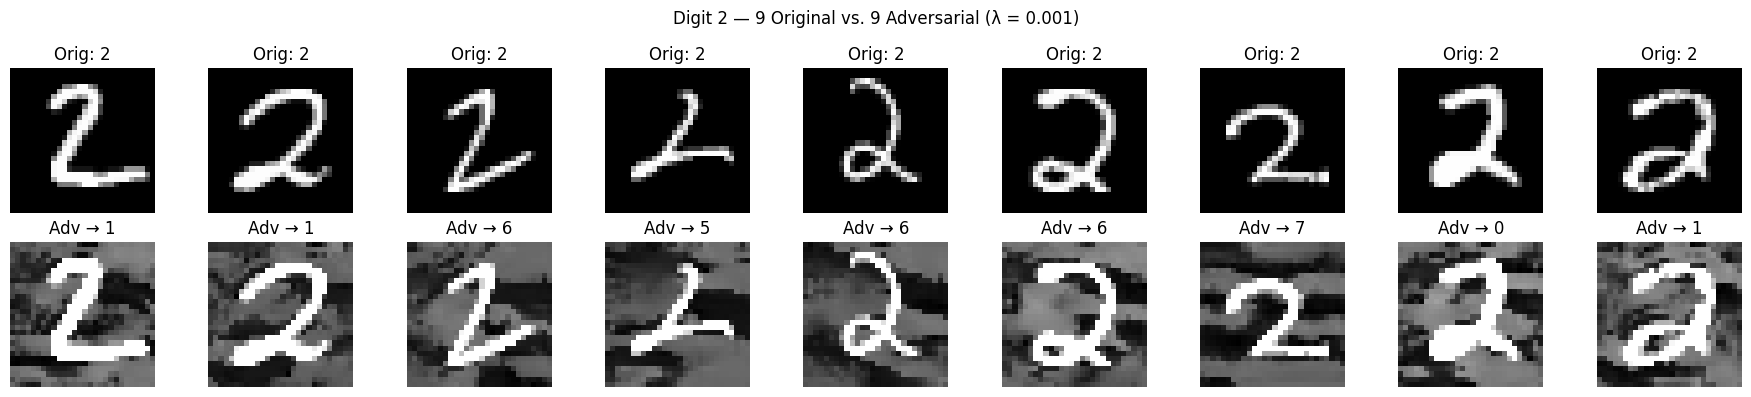

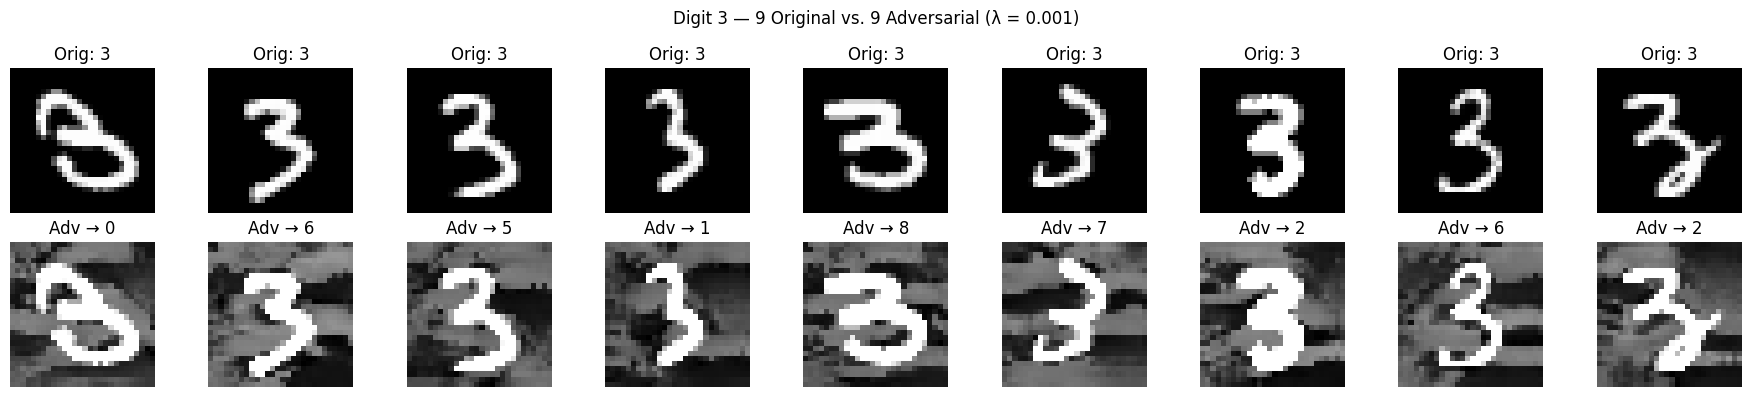

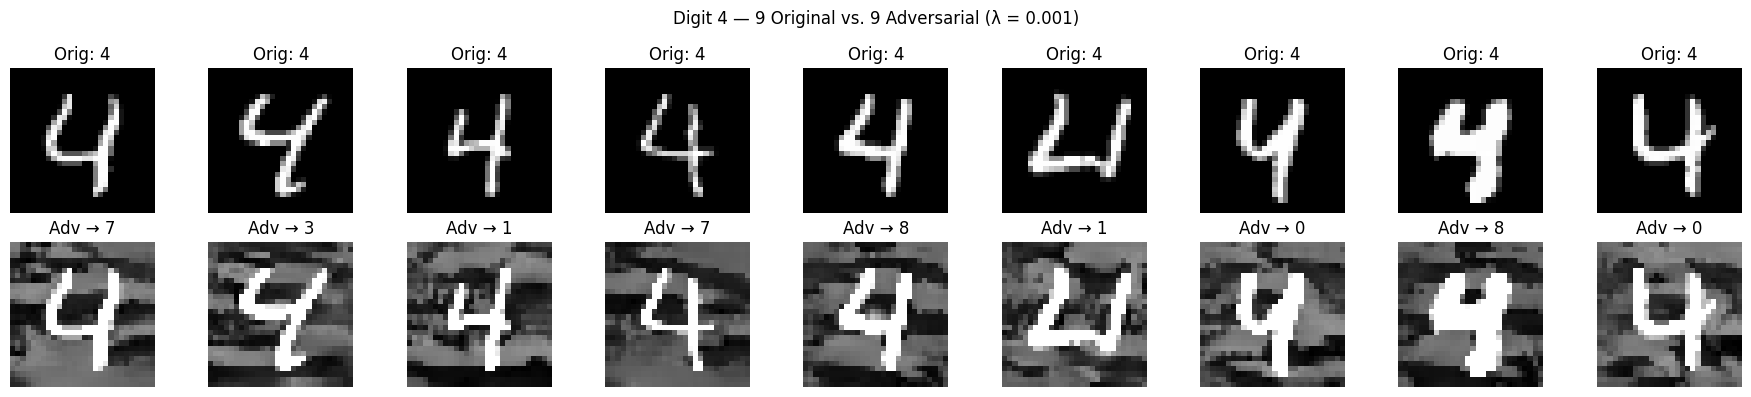

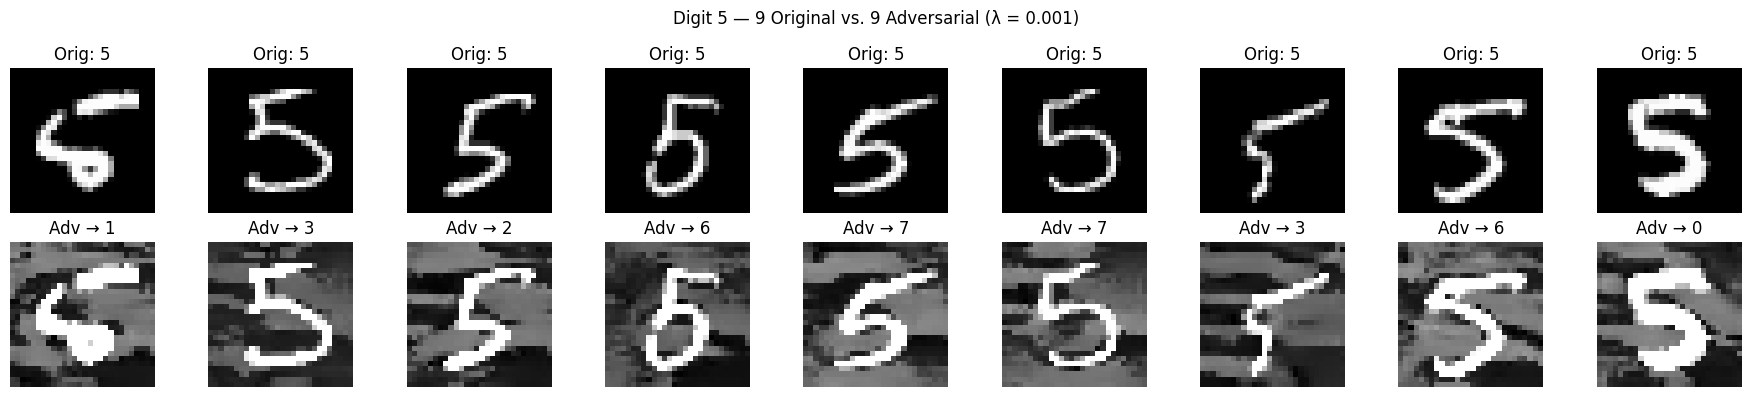

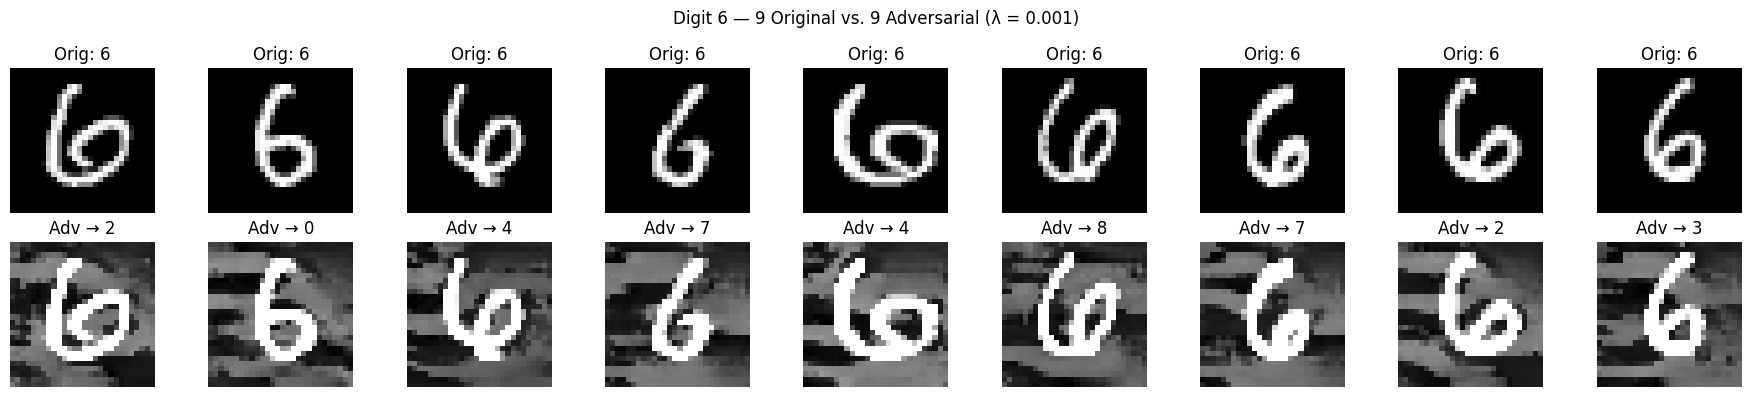

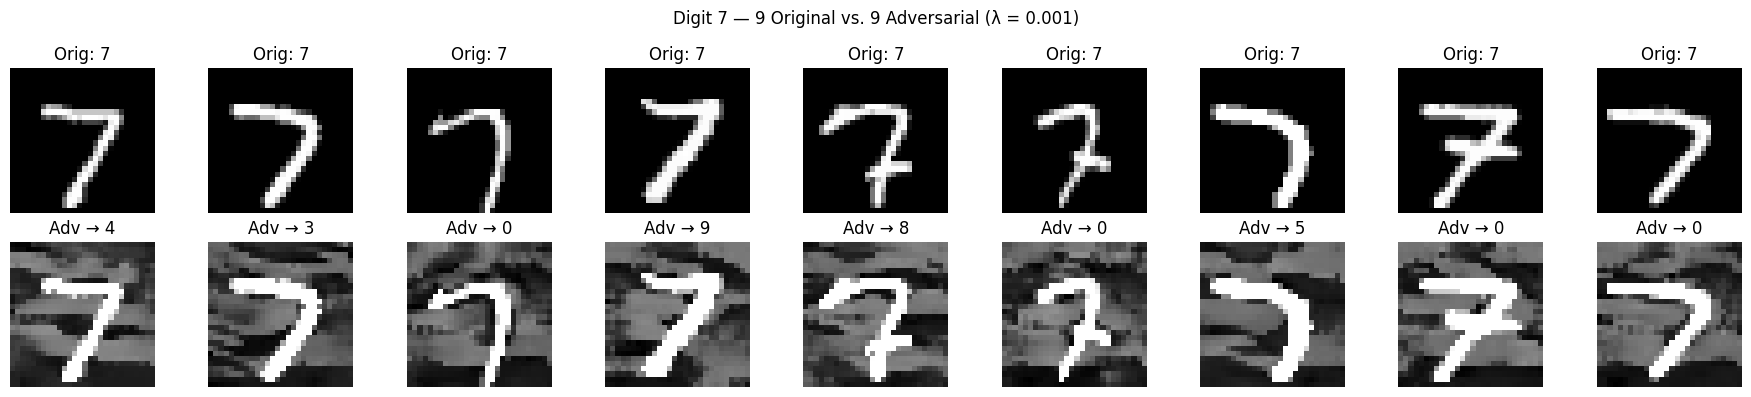

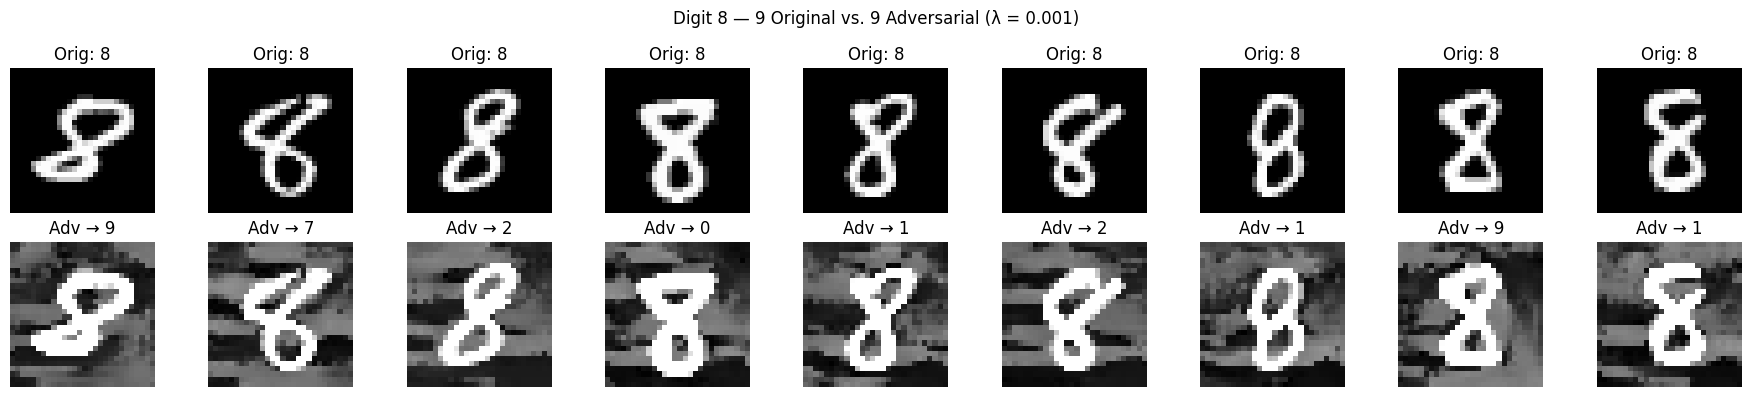

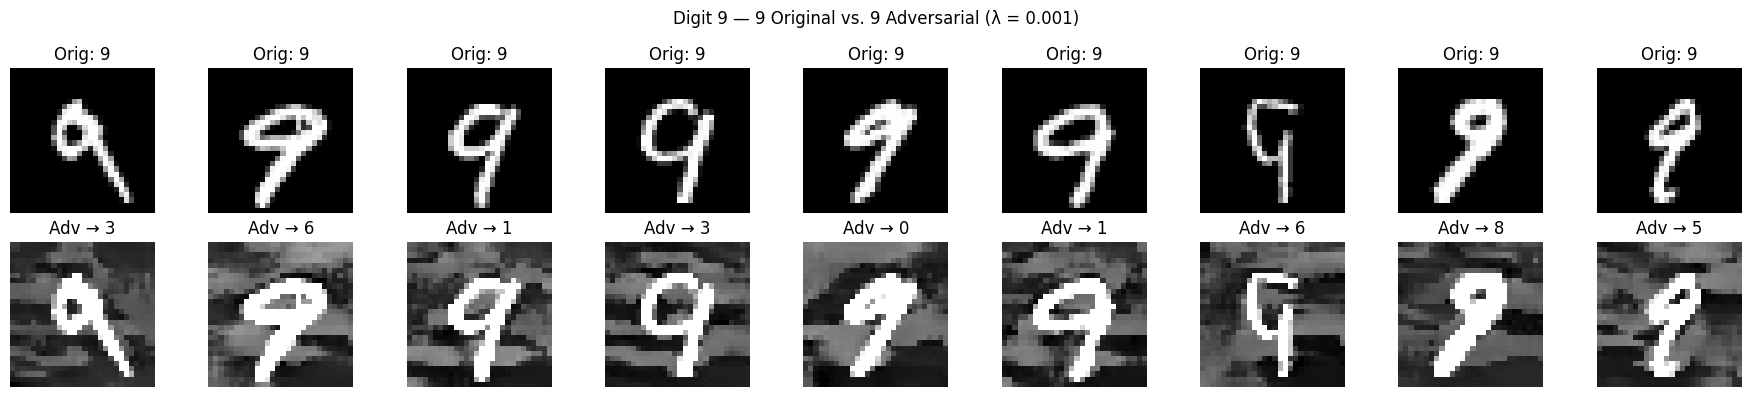

=== Results for Lambda = 0.01 ===
Step 0 — Loss: 6.7356, CE: 6.7356, L2: 0.000000
Sample predictions: [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
Step 50 — Loss: 5.8860, CE: 5.8859, L2: 0.000020
Sample predictions: [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
Step 100 — Loss: 4.9783, CE: 4.9783, L2: 0.000077
Sample predictions: [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
Step 150 — Loss: 4.1280, CE: 4.1278, L2: 0.000160
Sample predictions: [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
Step 200 — Loss: 3.3569, CE: 3.3567, L2: 0.000266
Sample predictions: [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
Step 250 — Loss: 2.6717, CE: 2.6714, L2: 0.000386
Sample predictions: [0, 0, 0, 0, 0, 0, 0, 0, 0, 5]
Step 300 — Loss: 2.0929, CE: 2.0924, L2: 0.000514
Sample predictions: [0, 0, 0, 0, 0, 0, 0, 0, 0, 5]
Step 350 — Loss: 1.6368, CE: 1.6362, L2: 0.000640
Sample predictions: [0, 0, 5, 0, 0, 0, 2, 0, 0, 5]
Step 399 — Loss: 1.2910, CE: 1.2903, L2: 0.000759
Sample predictions: [0, 3, 5, 0, 0, 6, 2, 0, 0, 5]

Success rate of attacks: 61/90 (67.78%)


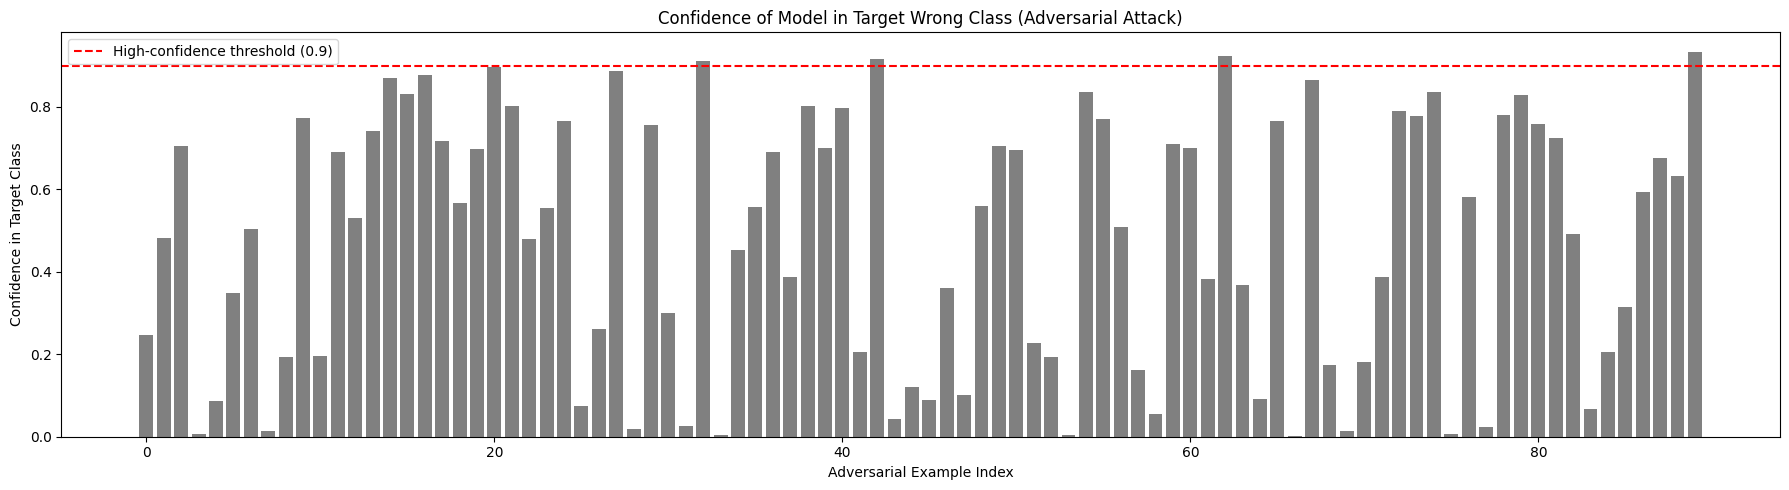

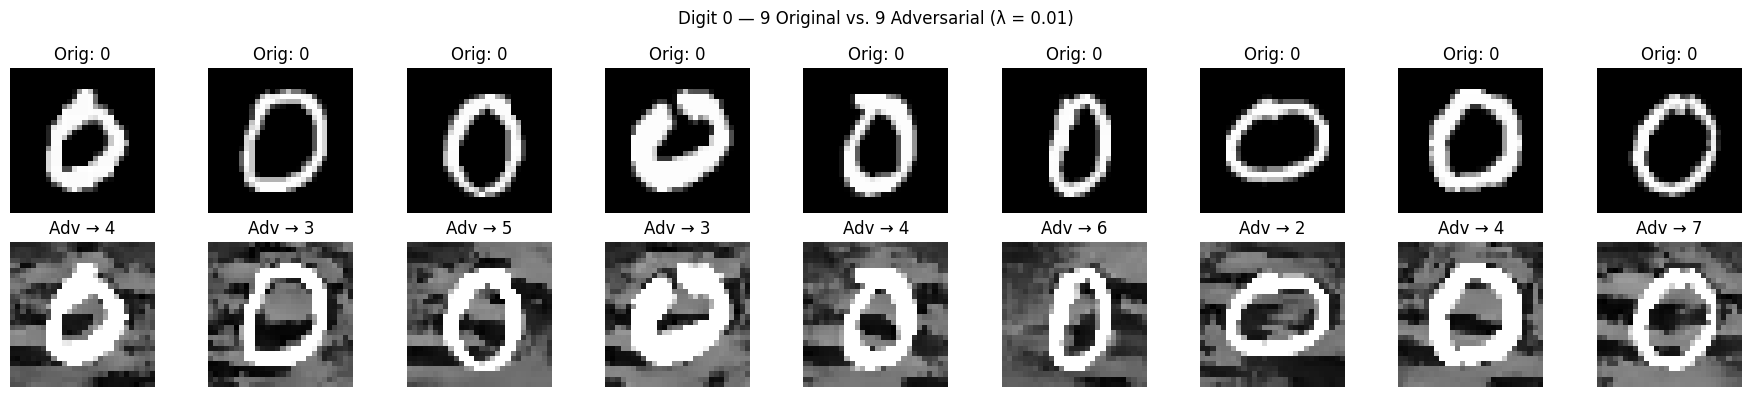

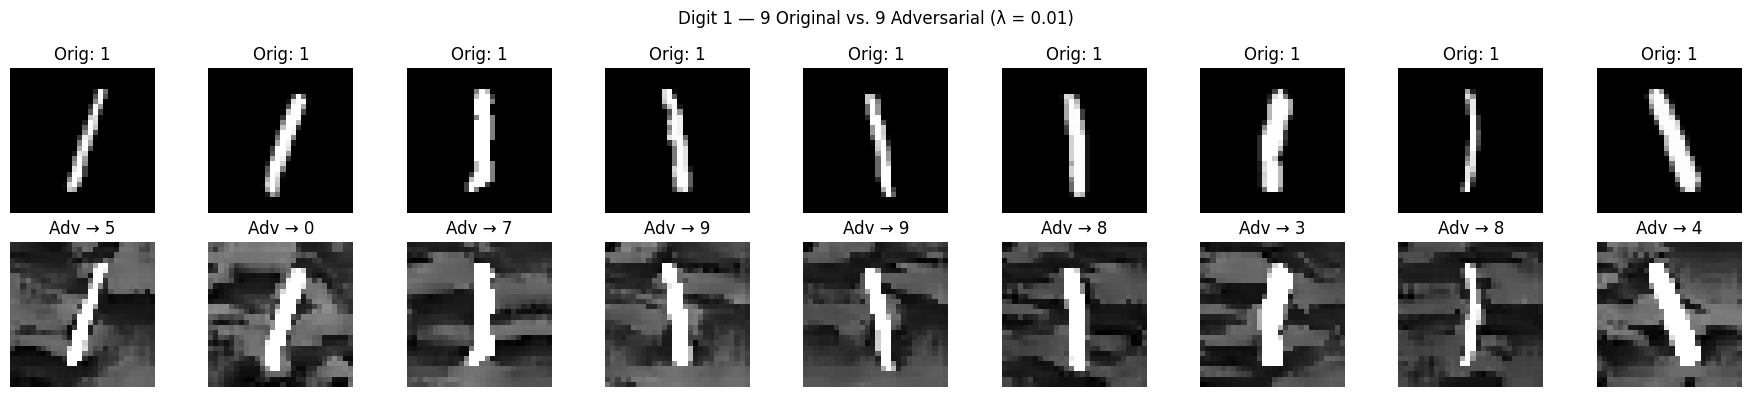

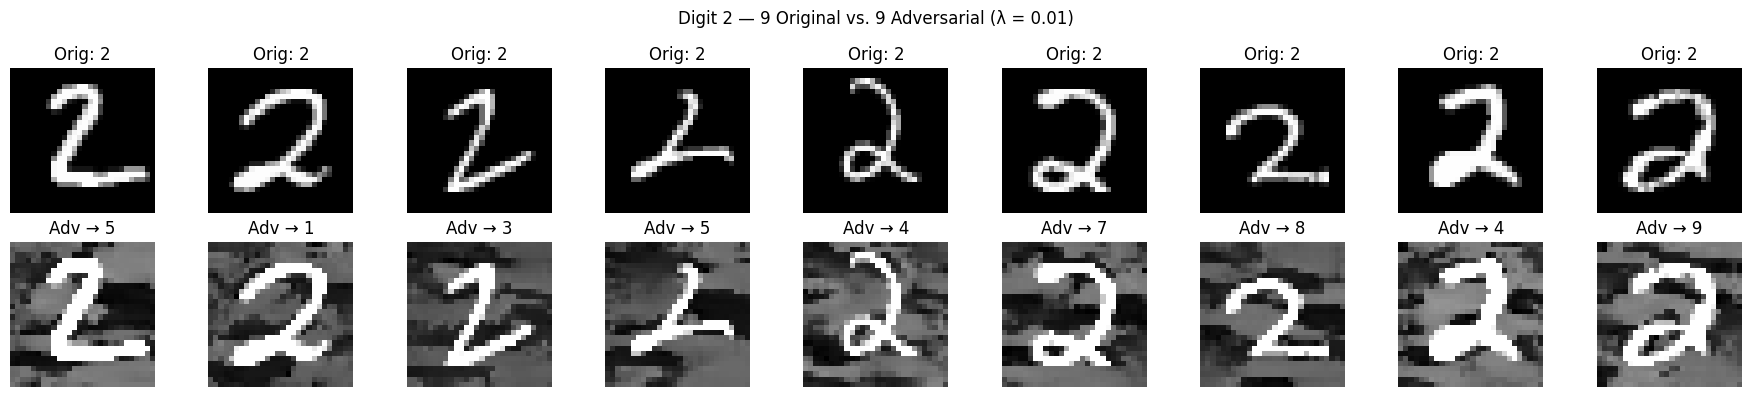

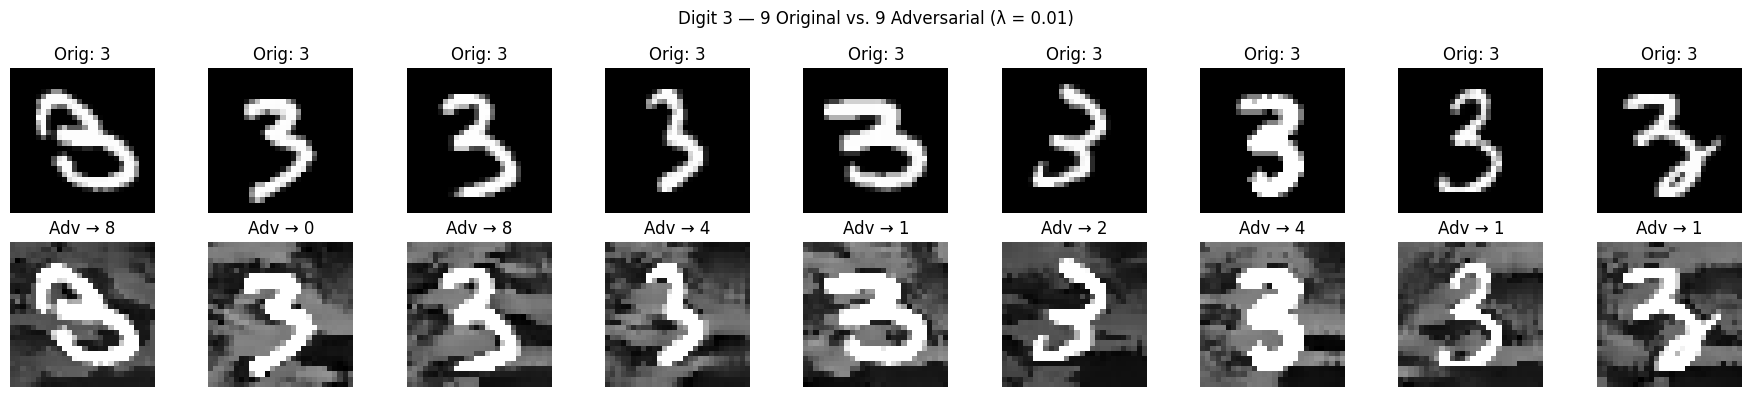

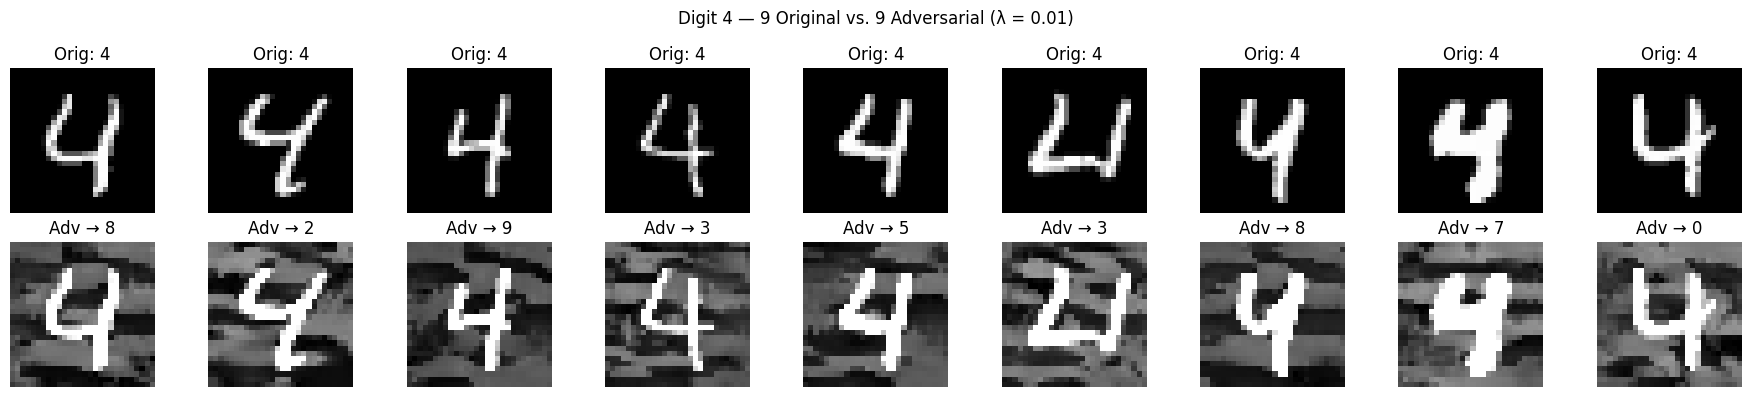

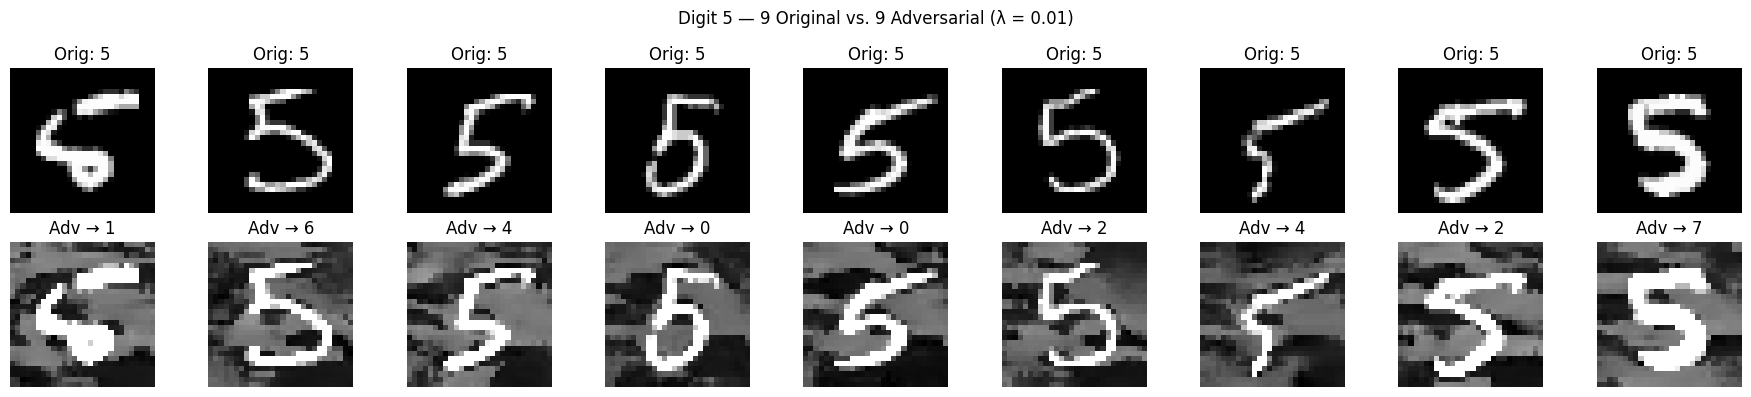

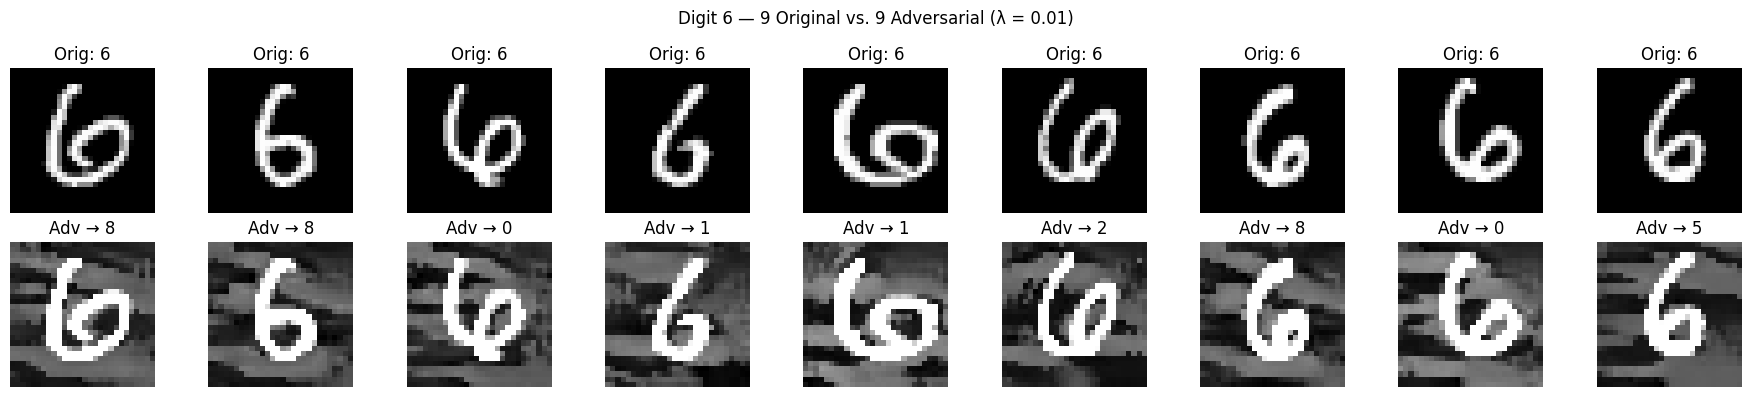

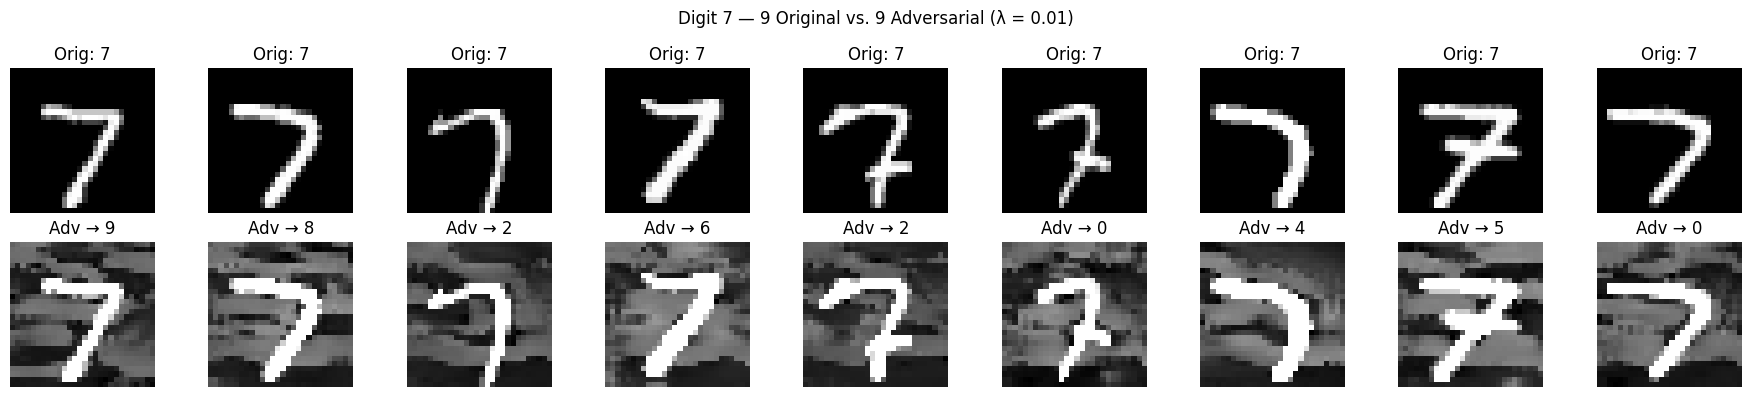

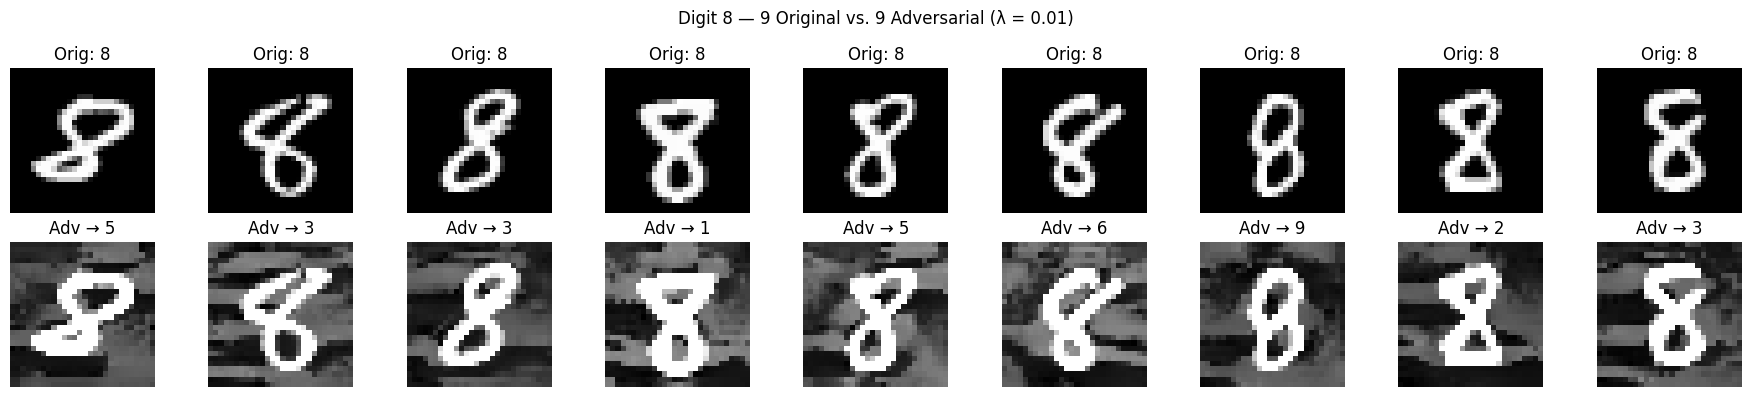

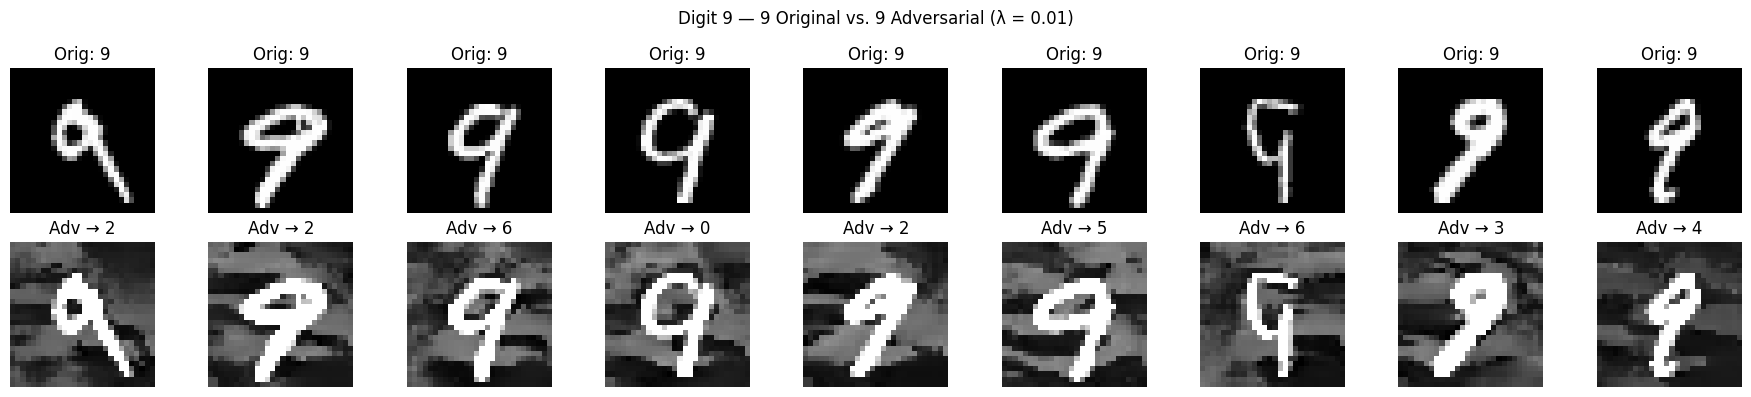

=== Results for Lambda = 0.1 ===
Step 0 — Loss: 7.3691, CE: 7.3691, L2: 0.000000
Sample predictions: [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
Step 50 — Loss: 6.5175, CE: 6.5173, L2: 0.000200
Sample predictions: [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
Step 100 — Loss: 5.5911, CE: 5.5904, L2: 0.000779
Sample predictions: [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
Step 150 — Loss: 4.6655, CE: 4.6638, L2: 0.001652
Sample predictions: [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
Step 200 — Loss: 3.7861, CE: 3.7834, L2: 0.002786
Sample predictions: [0, 0, 0, 0, 0, 0, 0, 0, 0, 3]
Step 250 — Loss: 2.9898, CE: 2.9857, L2: 0.004106
Sample predictions: [0, 0, 0, 0, 0, 0, 0, 0, 0, 3]
Step 300 — Loss: 2.3210, CE: 2.3155, L2: 0.005501
Sample predictions: [0, 0, 0, 0, 0, 3, 0, 0, 0, 3]
Step 350 — Loss: 1.7895, CE: 1.7826, L2: 0.006869
Sample predictions: [0, 0, 0, 0, 3, 3, 0, 0, 0, 3]
Step 399 — Loss: 1.3860, CE: 1.3778, L2: 0.008140
Sample predictions: [2, 0, 0, 0, 3, 3, 0, 0, 0, 3]

Success rate of attacks: 56/90 (62.22%)


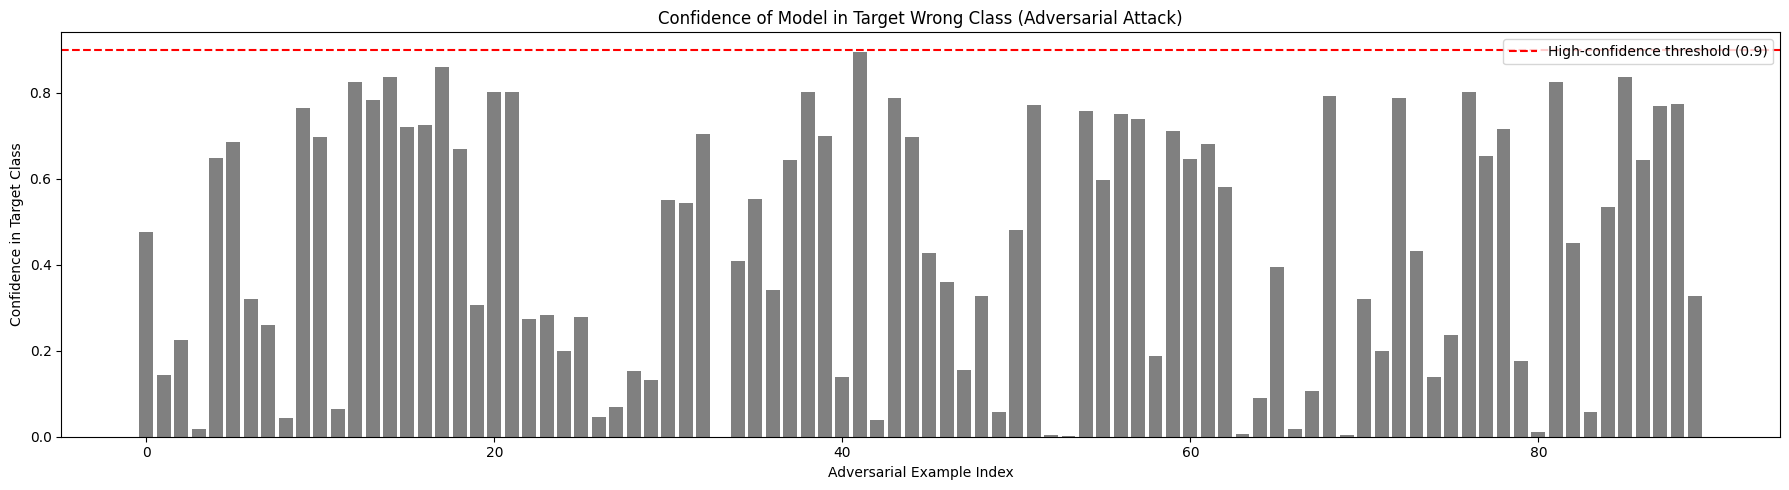

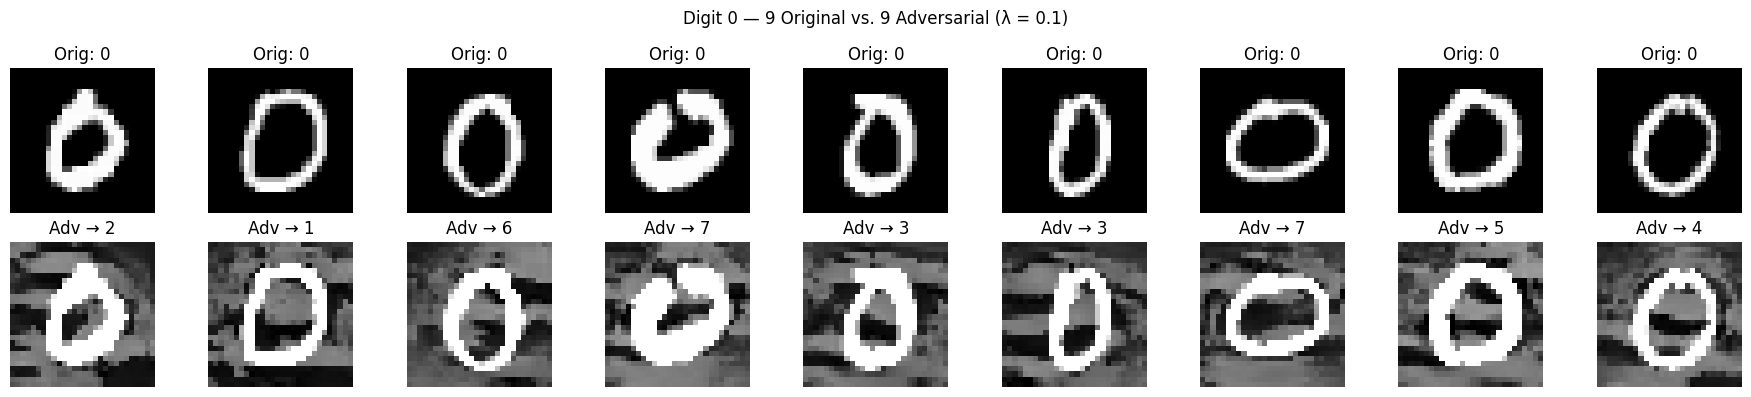

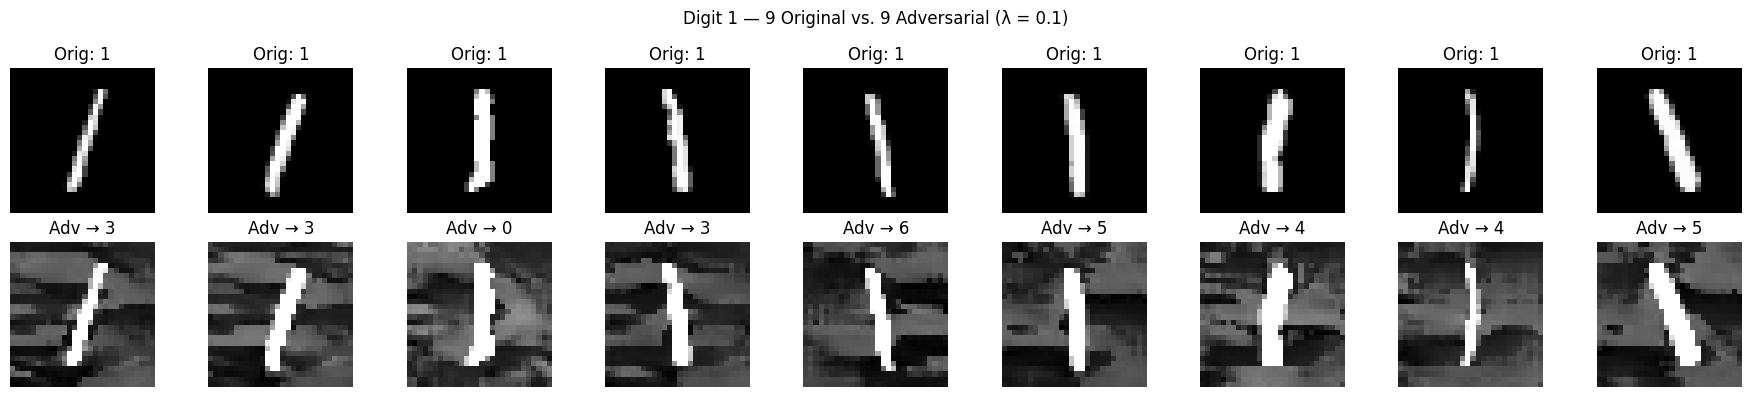

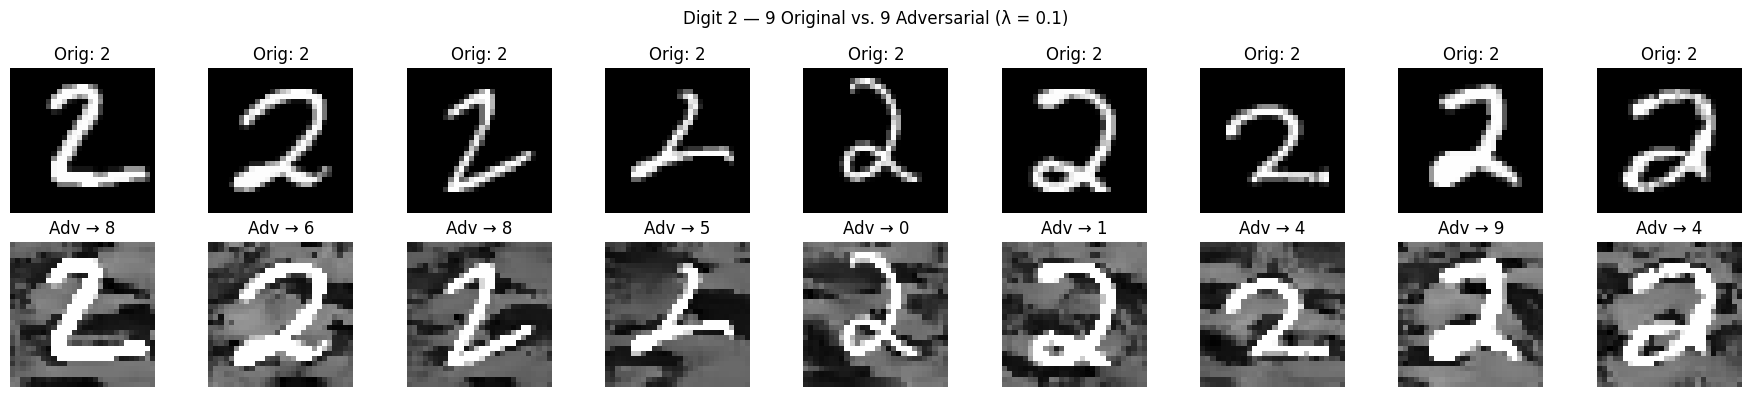

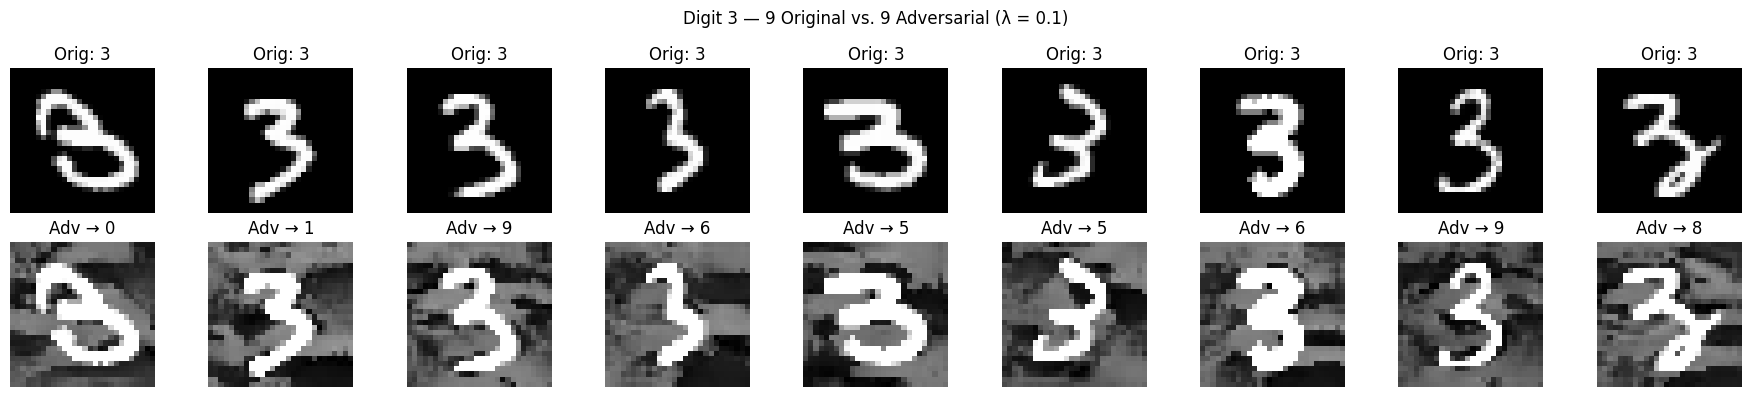

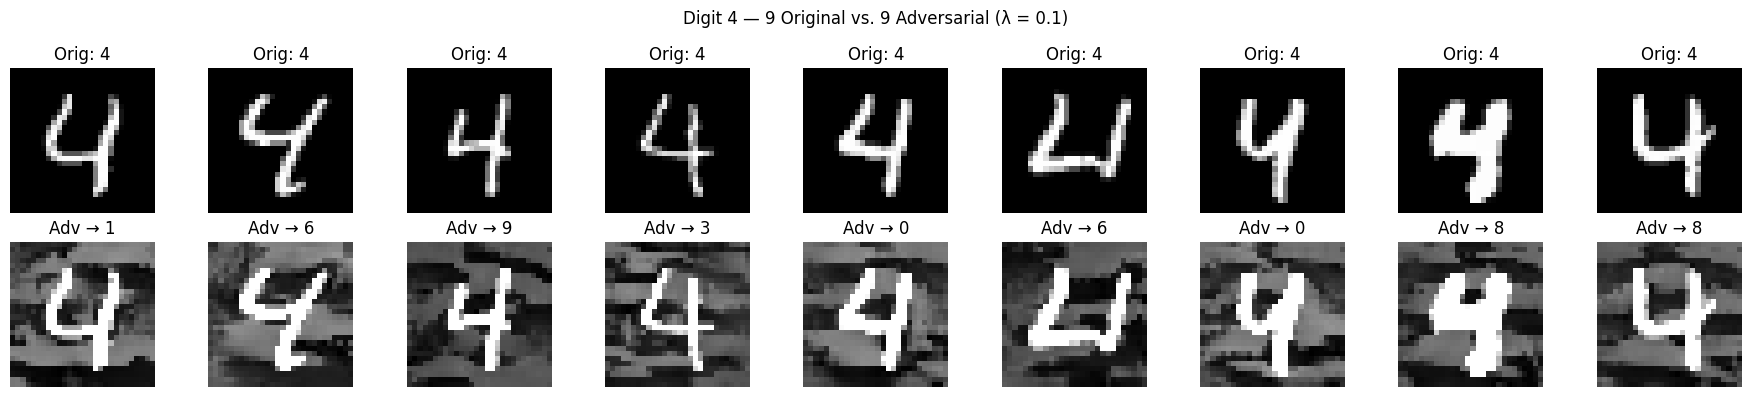

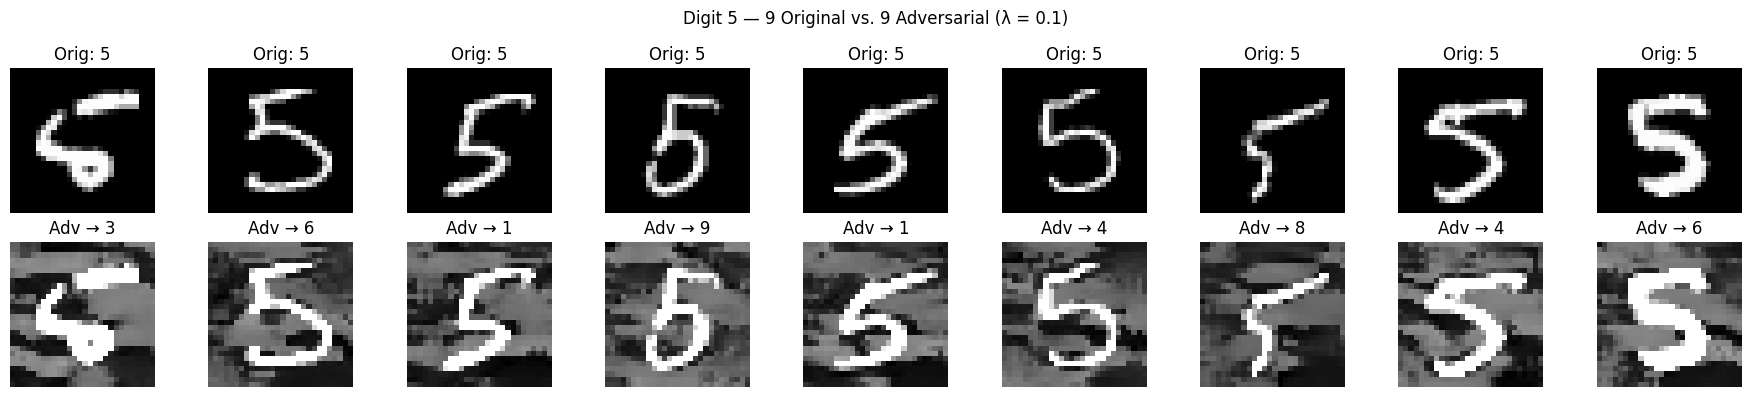

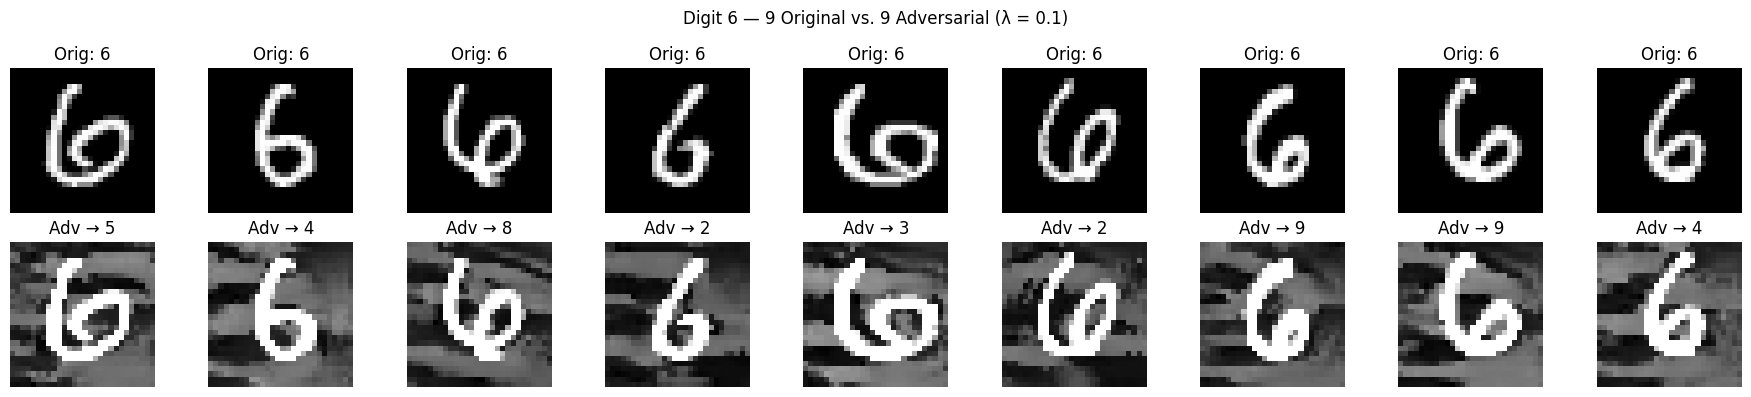

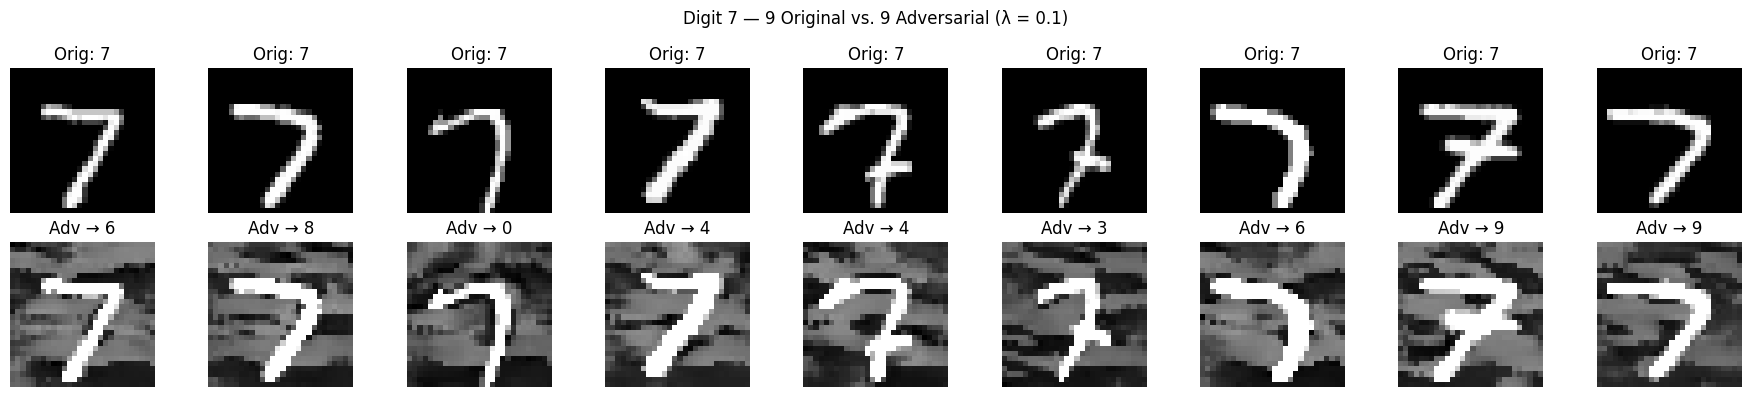

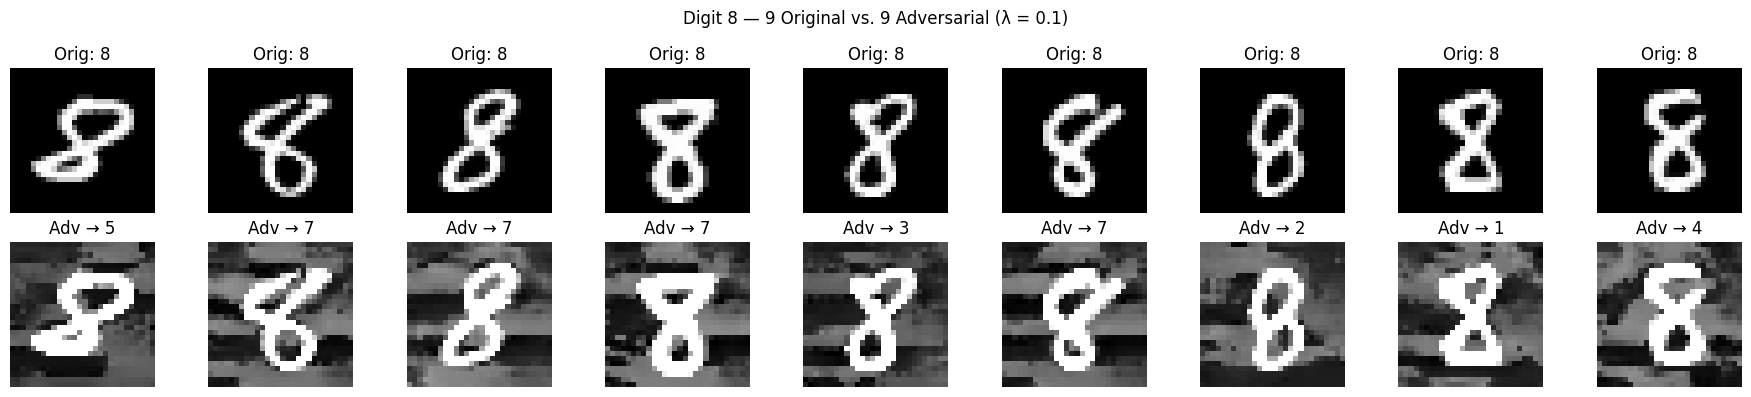

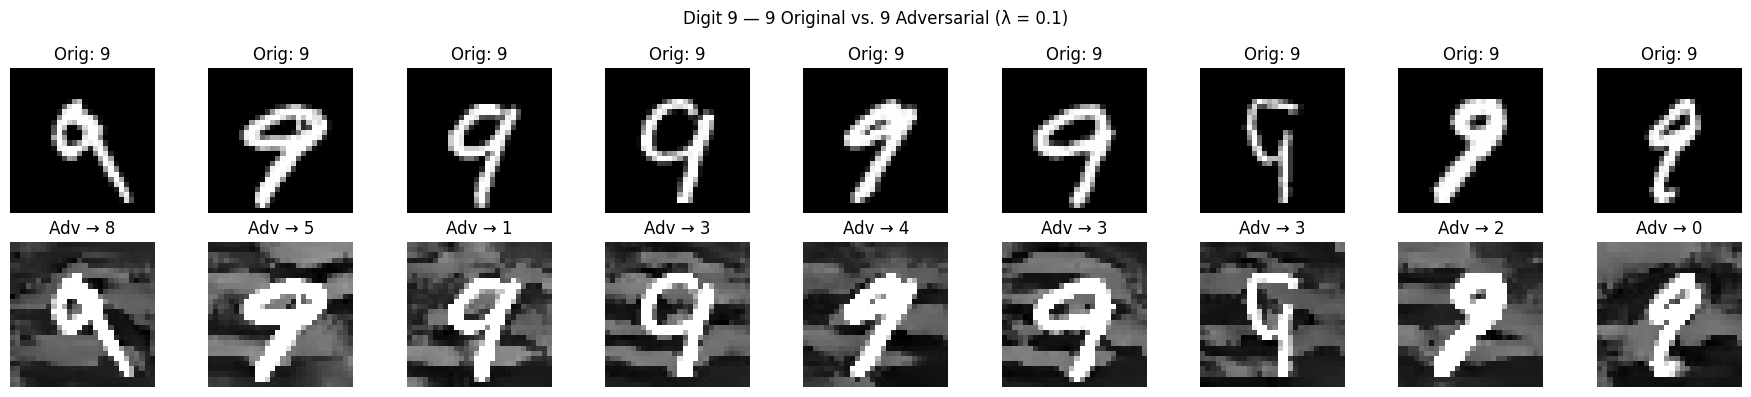

=== Results for Lambda = 1 ===
Step 0 — Loss: 6.8935, CE: 6.8935, L2: 0.000000
Sample predictions: [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
Step 50 — Loss: 6.0653, CE: 6.0634, L2: 0.001955
Sample predictions: [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
Step 100 — Loss: 5.1704, CE: 5.1628, L2: 0.007562
Sample predictions: [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
Step 150 — Loss: 4.2893, CE: 4.2734, L2: 0.015904
Sample predictions: [0, 0, 0, 0, 0, 0, 0, 0, 0, 7]
Step 200 — Loss: 3.4715, CE: 3.4450, L2: 0.026533
Sample predictions: [0, 0, 0, 0, 0, 0, 0, 0, 0, 7]
Step 250 — Loss: 2.7630, CE: 2.7244, L2: 0.038584
Sample predictions: [0, 0, 0, 0, 0, 0, 0, 0, 0, 7]
Step 300 — Loss: 2.1680, CE: 2.1168, L2: 0.051184
Sample predictions: [0, 0, 0, 0, 0, 0, 0, 0, 0, 7]
Step 350 — Loss: 1.6776, CE: 1.6141, L2: 0.063531
Sample predictions: [0, 0, 0, 0, 0, 0, 0, 0, 0, 7]
Step 399 — Loss: 1.2946, CE: 1.2198, L2: 0.074880
Sample predictions: [0, 0, 9, 0, 0, 6, 0, 0, 0, 7]

Success rate of attacks: 60/90 (66.67%)


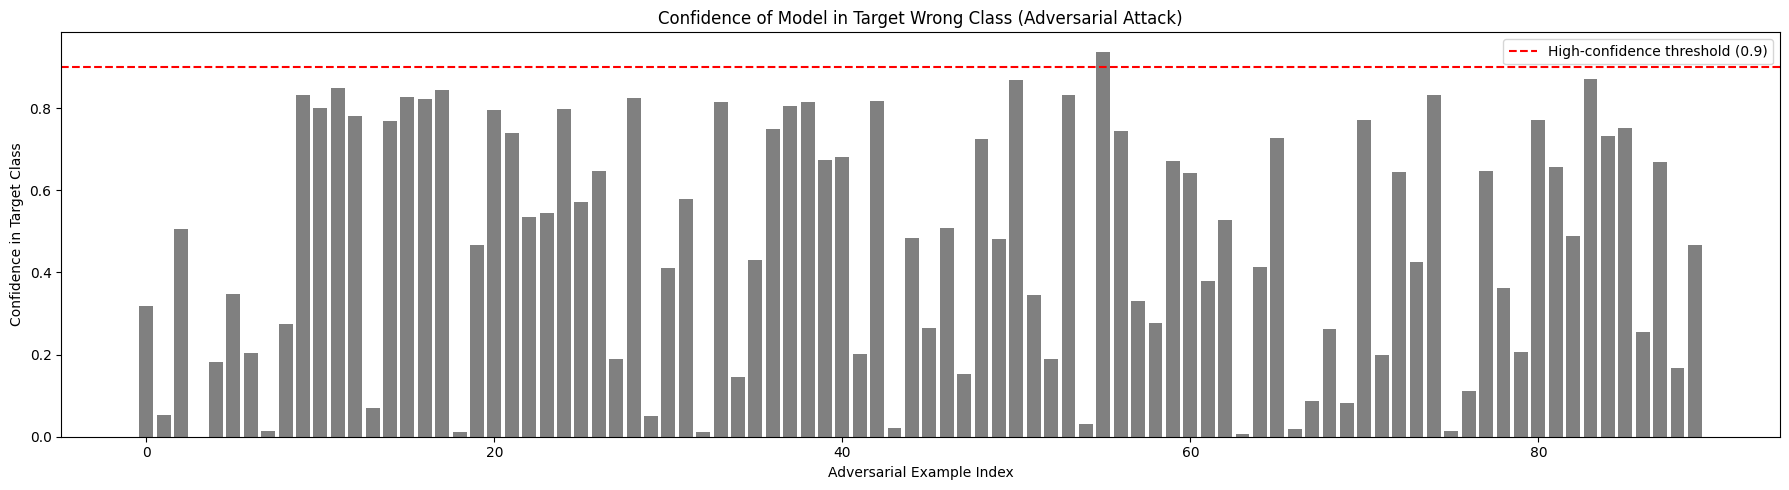

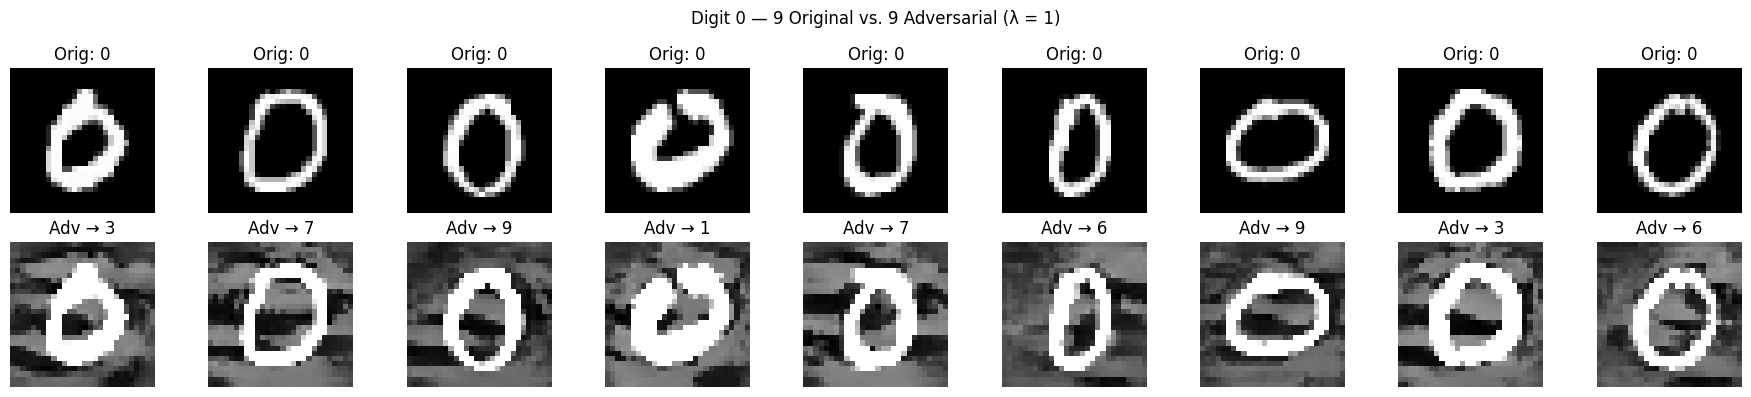

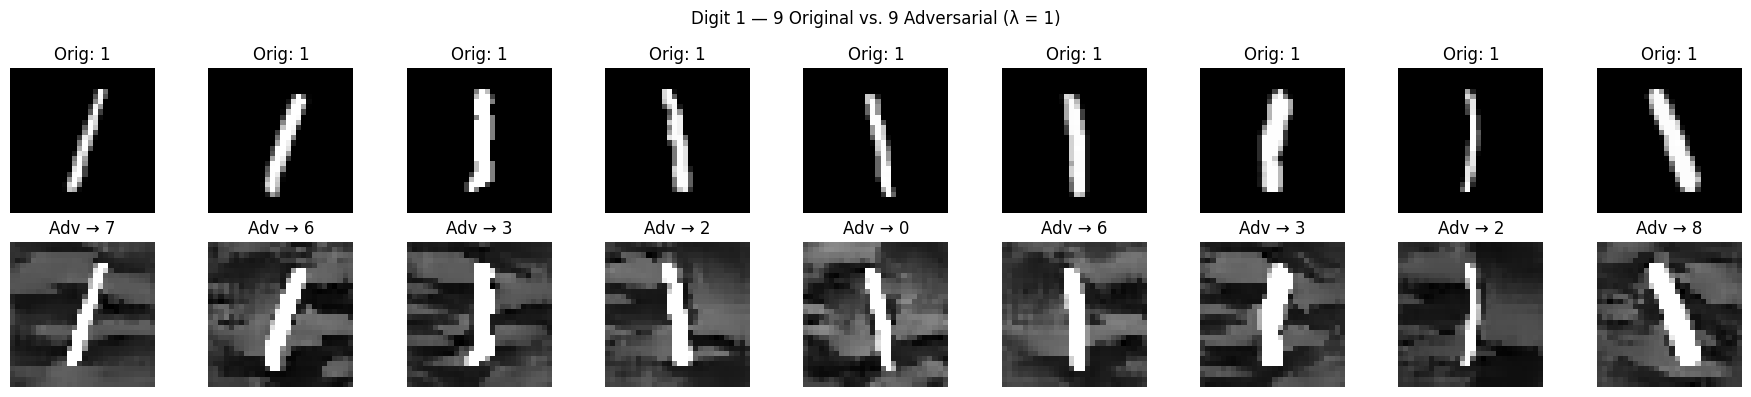

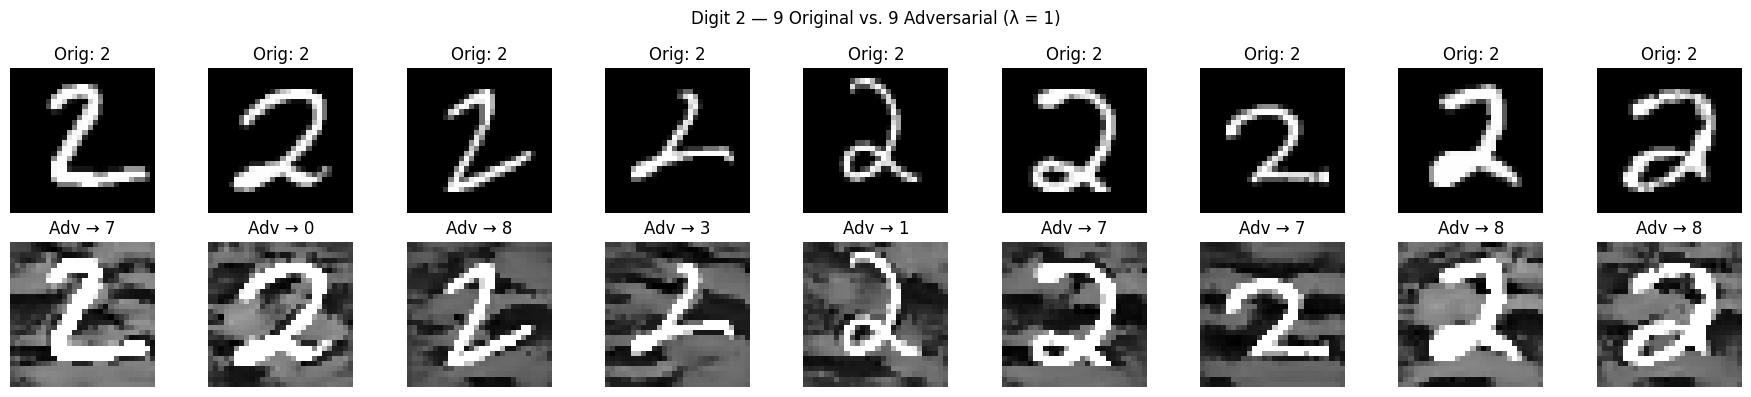

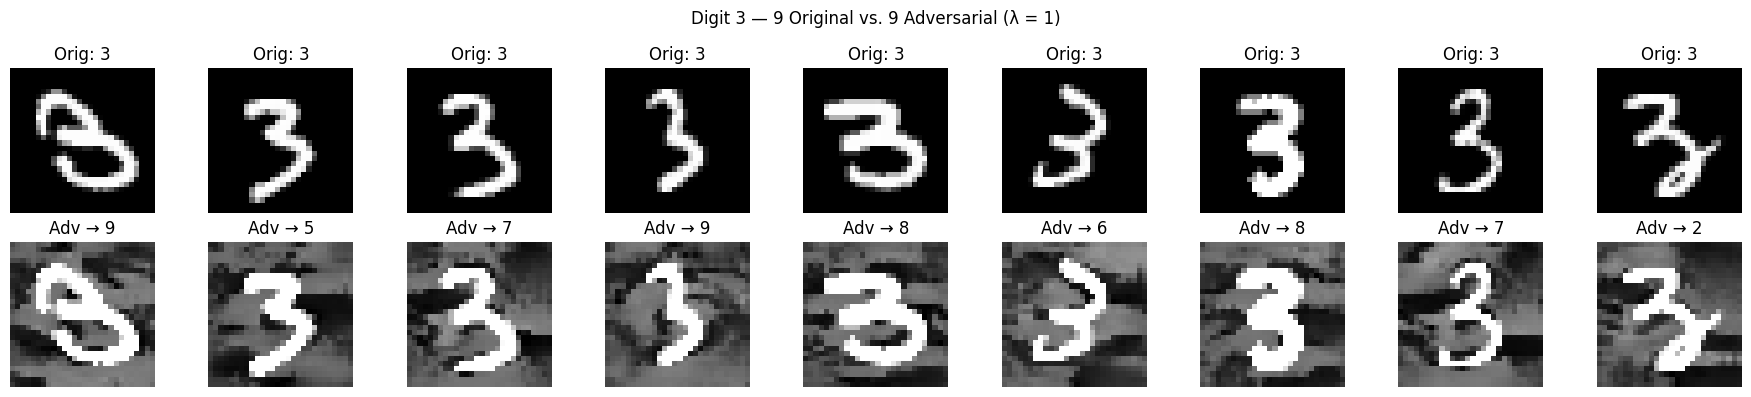

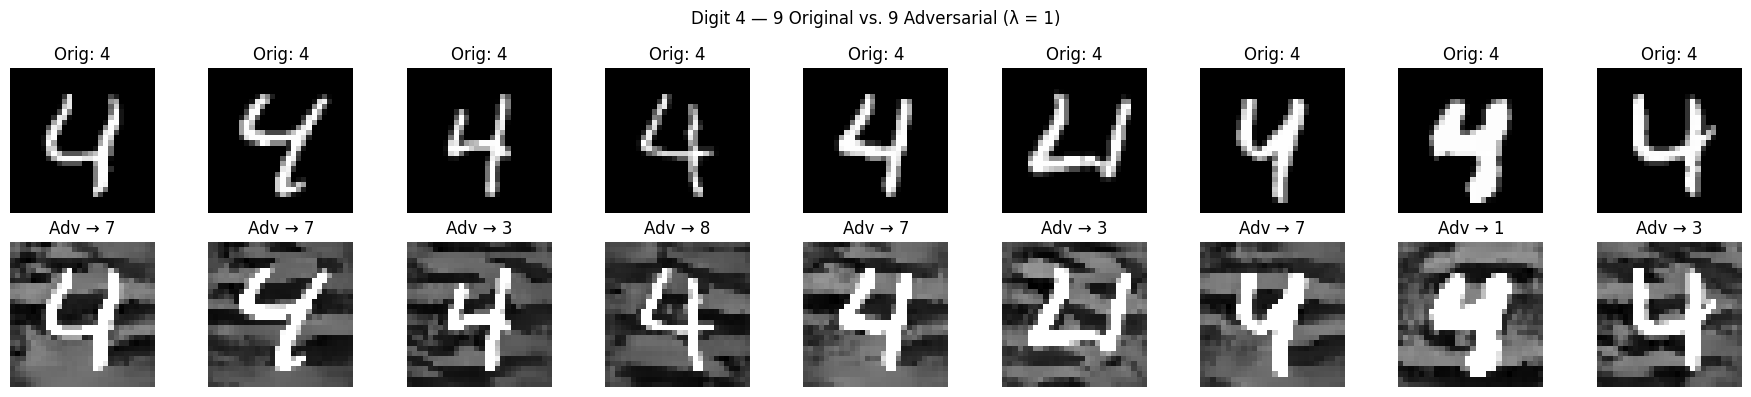

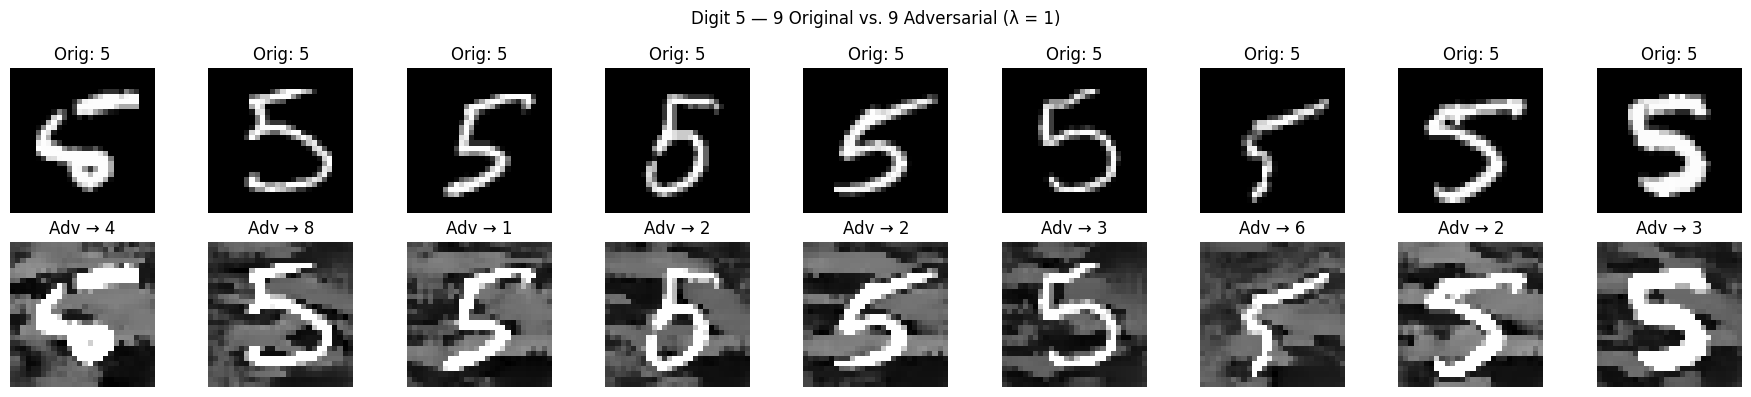

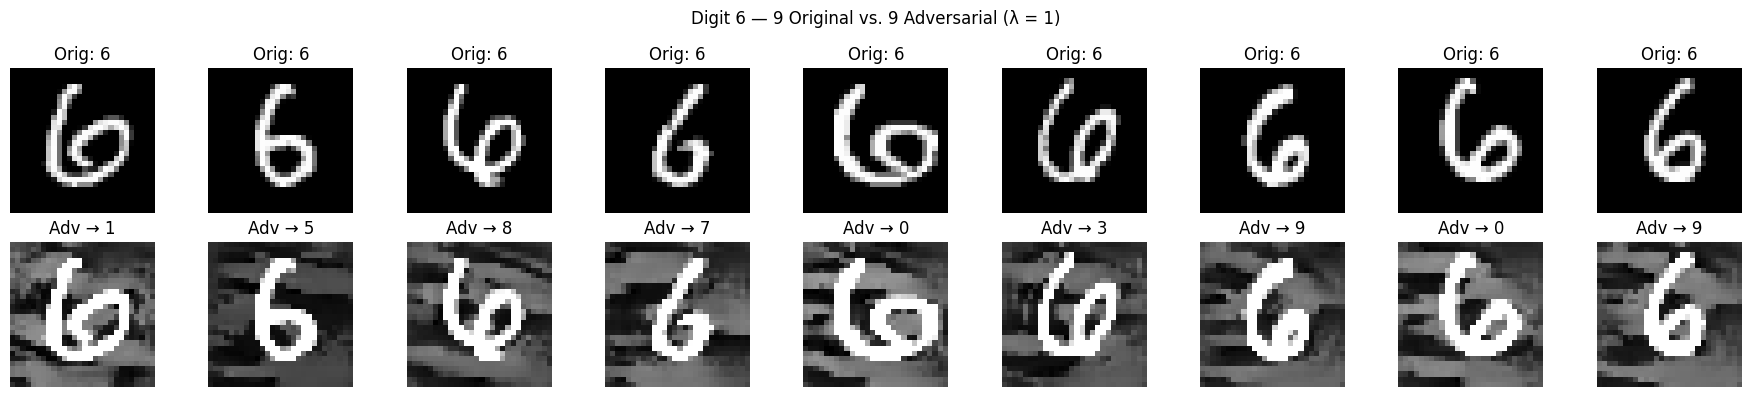

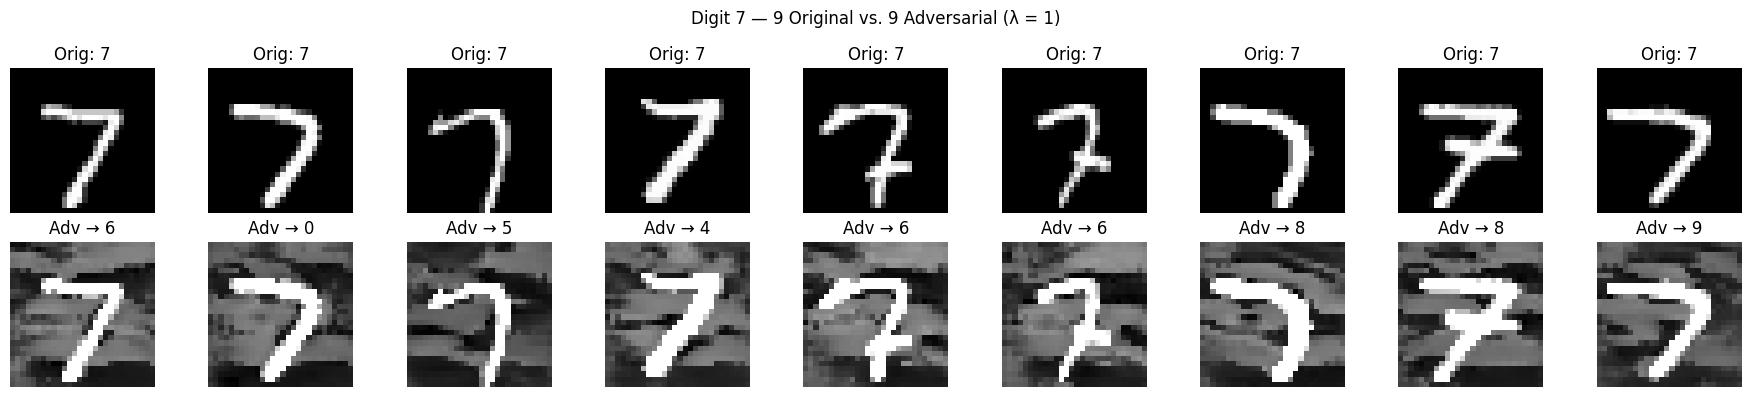

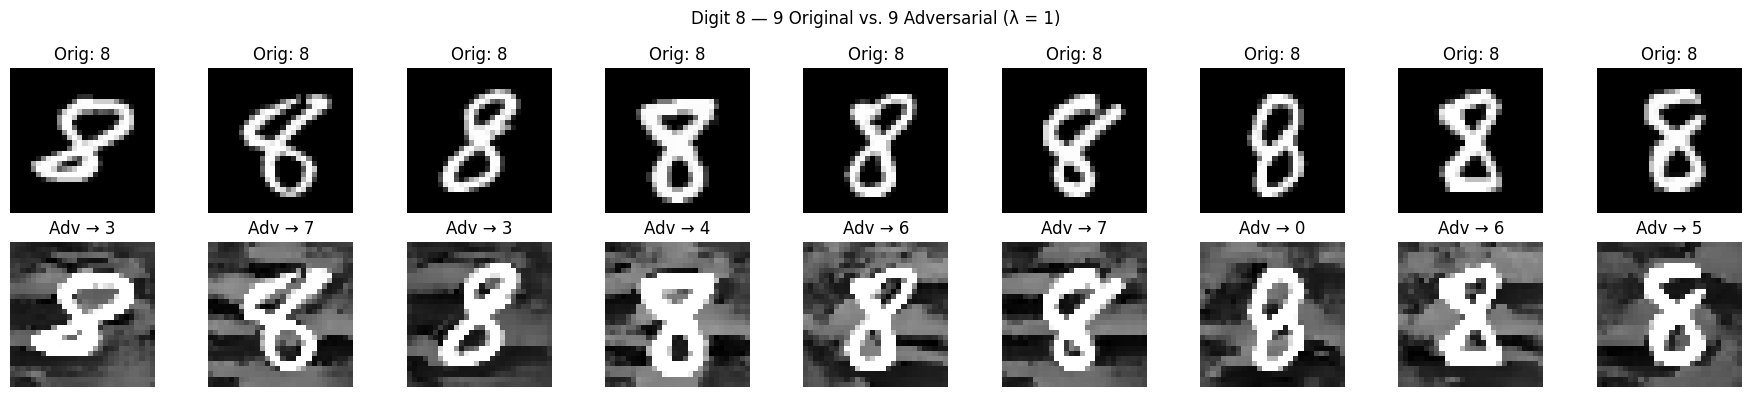

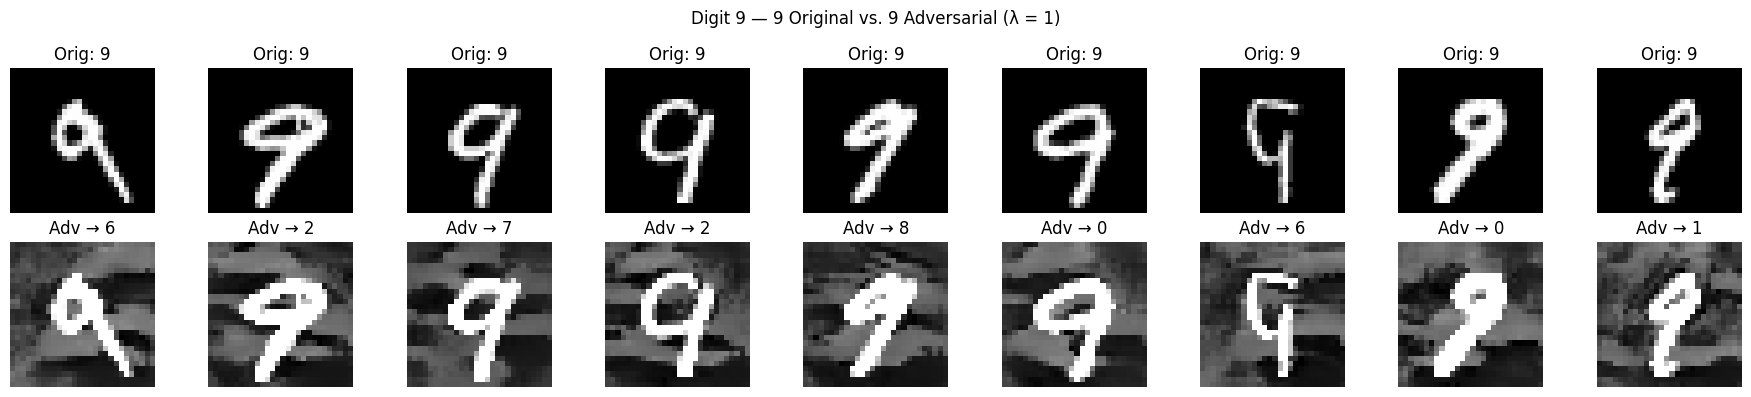

=== Results for Lambda = 10 ===
Step 0 — Loss: 6.4236, CE: 6.4236, L2: 0.000000
Sample predictions: [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
Step 50 — Loss: 5.6420, CE: 5.6242, L2: 0.017862
Sample predictions: [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
Step 100 — Loss: 4.8277, CE: 4.7629, L2: 0.064789
Sample predictions: [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
Step 150 — Loss: 4.0900, CE: 3.9631, L2: 0.126887
Sample predictions: [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
Step 200 — Loss: 3.4416, CE: 3.2428, L2: 0.198791
Sample predictions: [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
Step 250 — Loss: 2.9033, CE: 2.6295, L2: 0.273804
Sample predictions: [0, 0, 0, 0, 0, 0, 5, 0, 0, 5]
Step 300 — Loss: 2.4573, CE: 2.1112, L2: 0.346089
Sample predictions: [0, 0, 0, 0, 0, 0, 5, 0, 0, 5]
Step 350 — Loss: 2.1039, CE: 1.6937, L2: 0.410233
Sample predictions: [0, 0, 0, 0, 0, 0, 5, 0, 0, 5]
Step 399 — Loss: 1.8388, CE: 1.3768, L2: 0.461951
Sample predictions: [0, 2, 0, 0, 0, 0, 5, 0, 0, 5]

Success rate of attacks: 53/90 (58.89%)


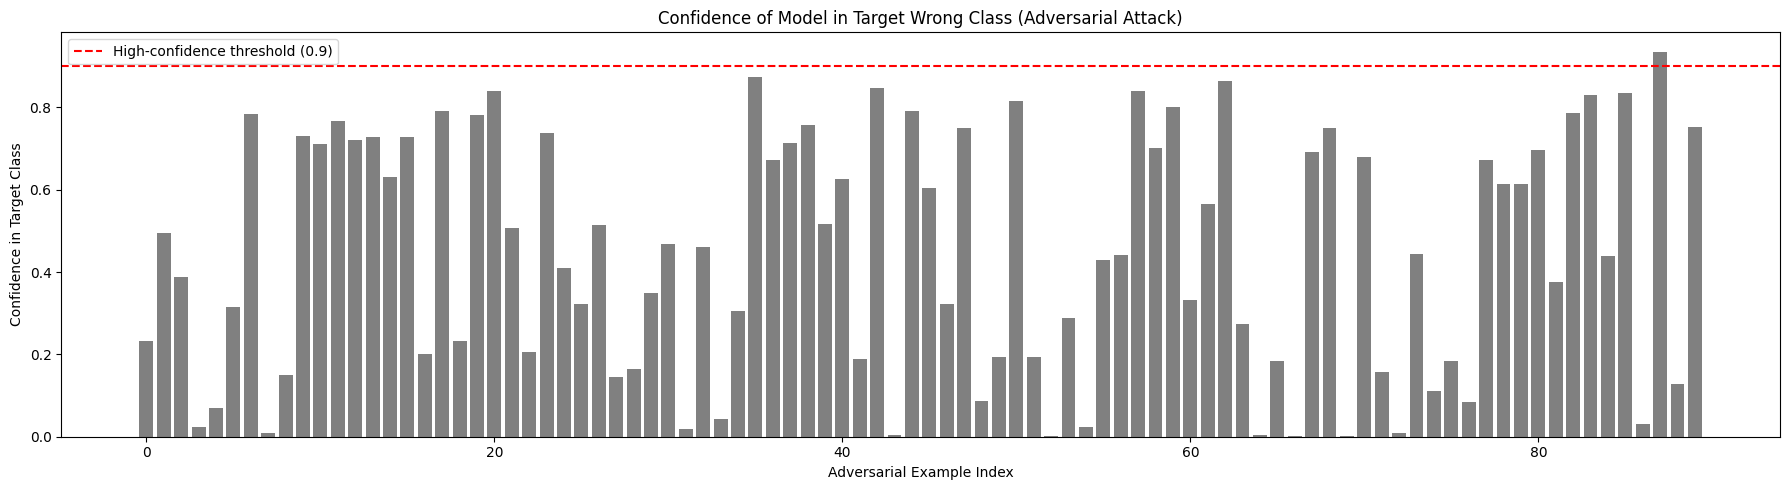

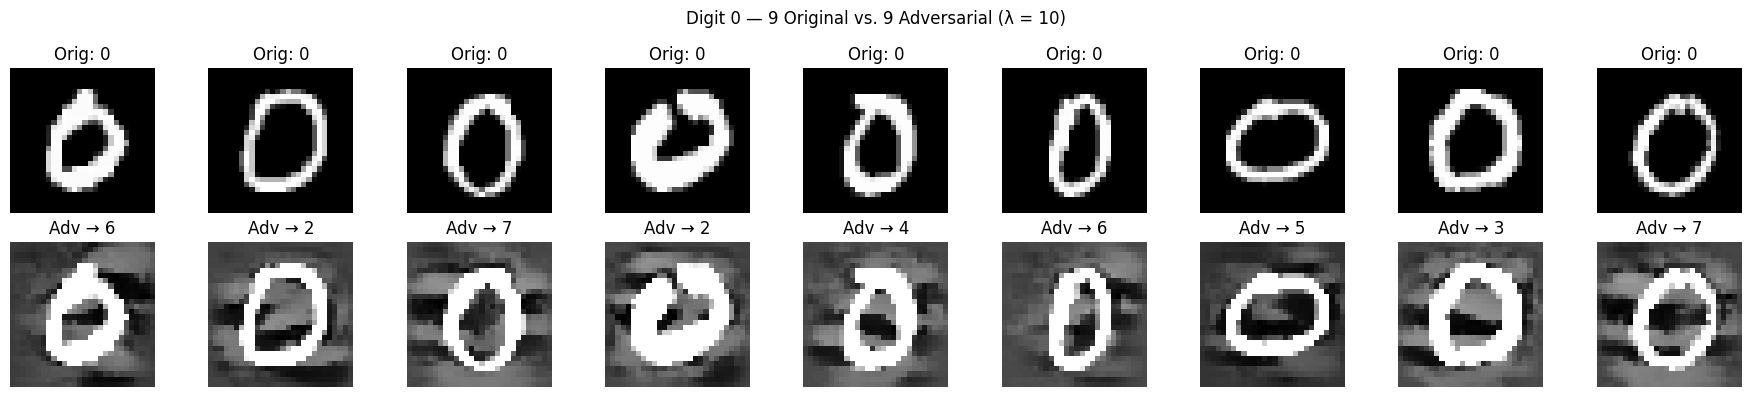

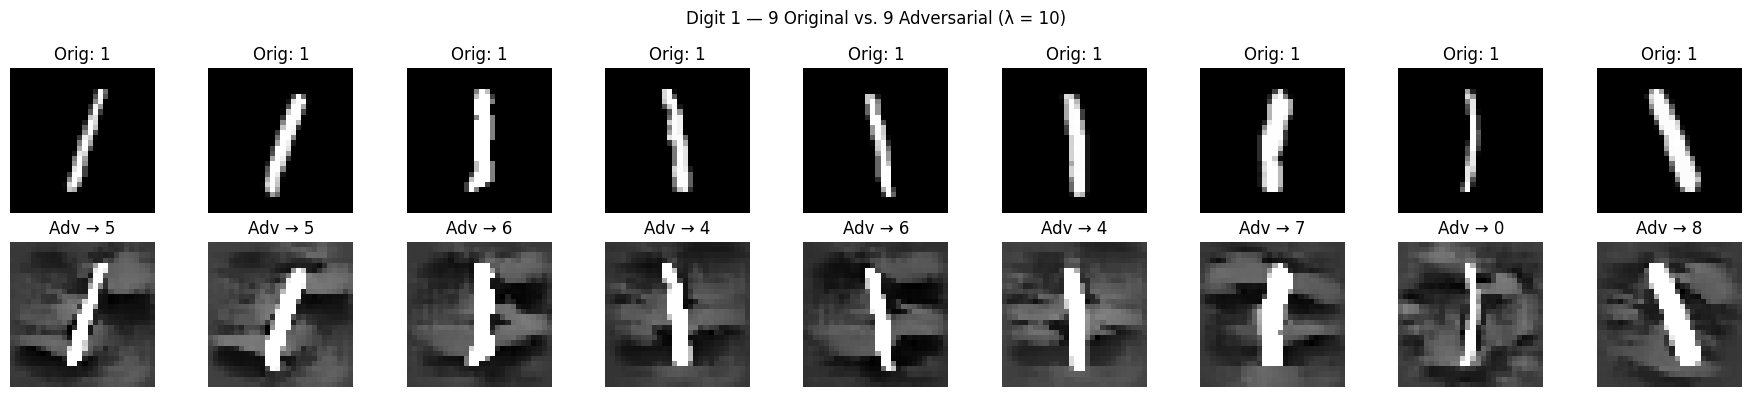

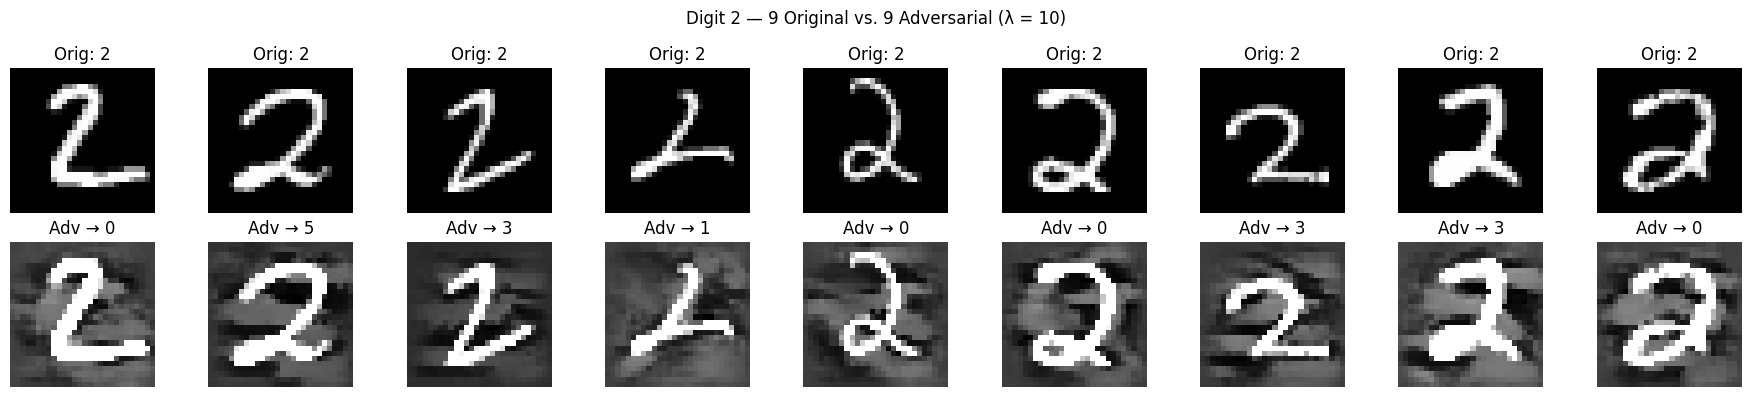

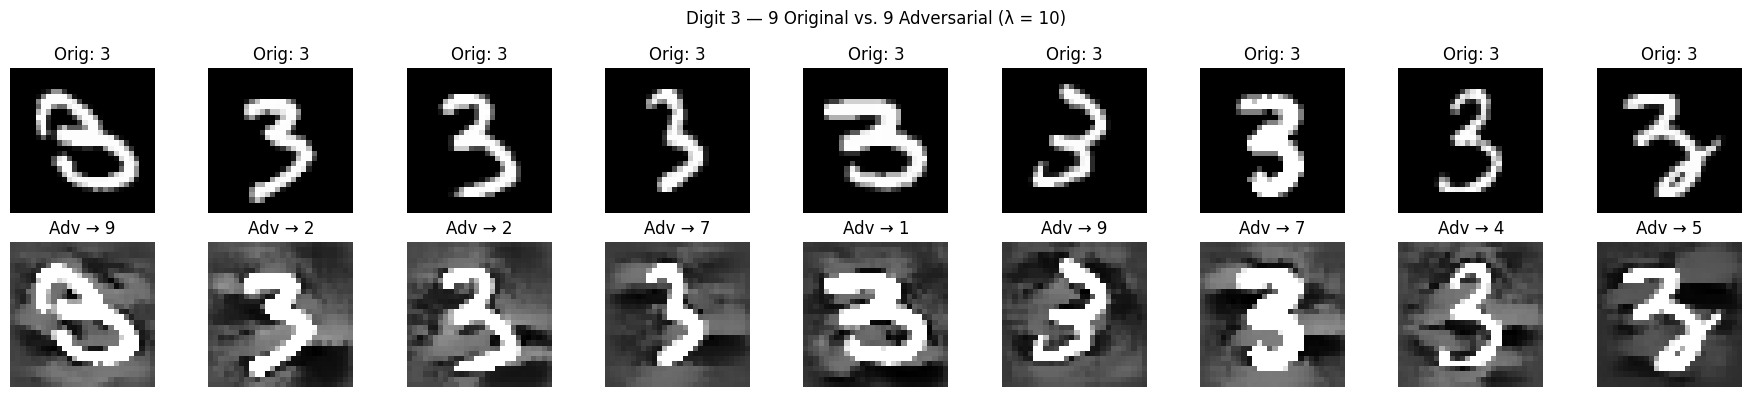

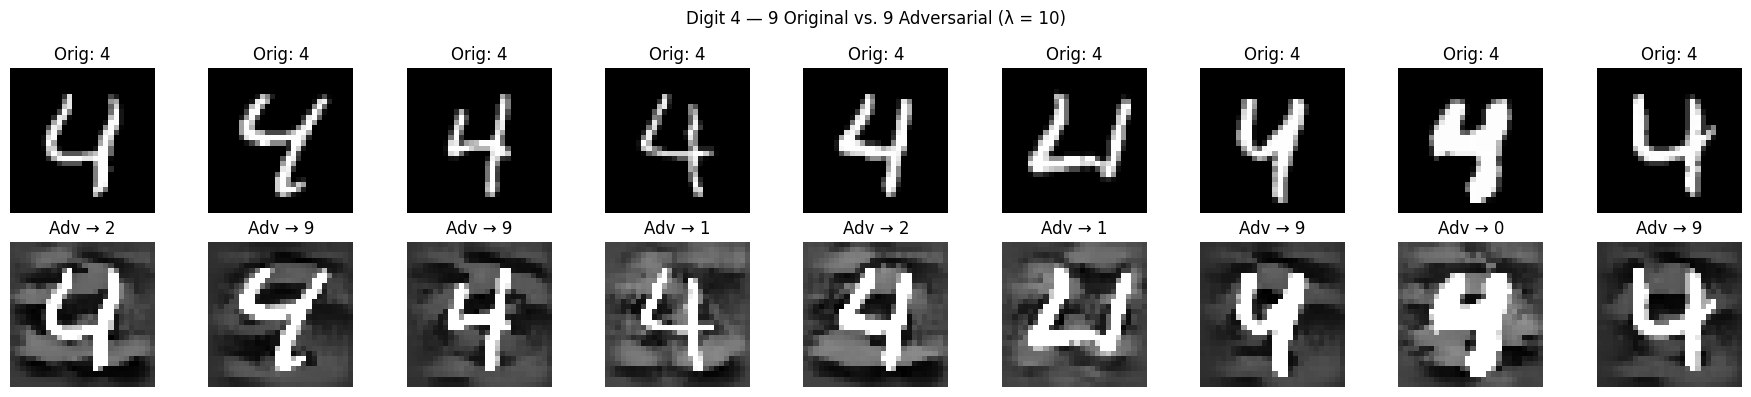

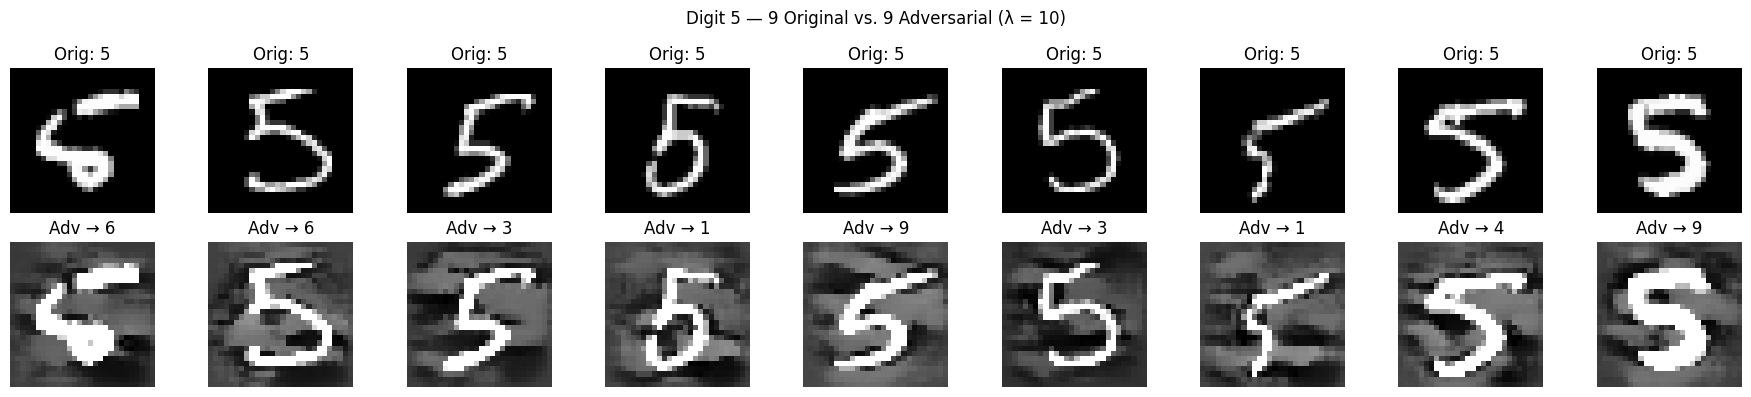

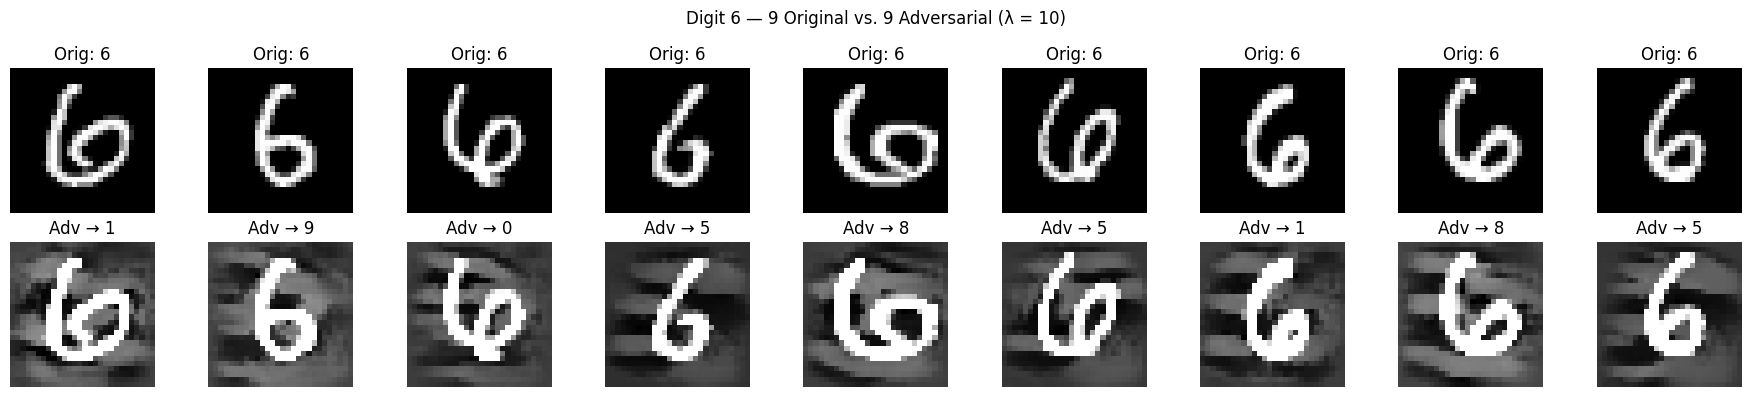

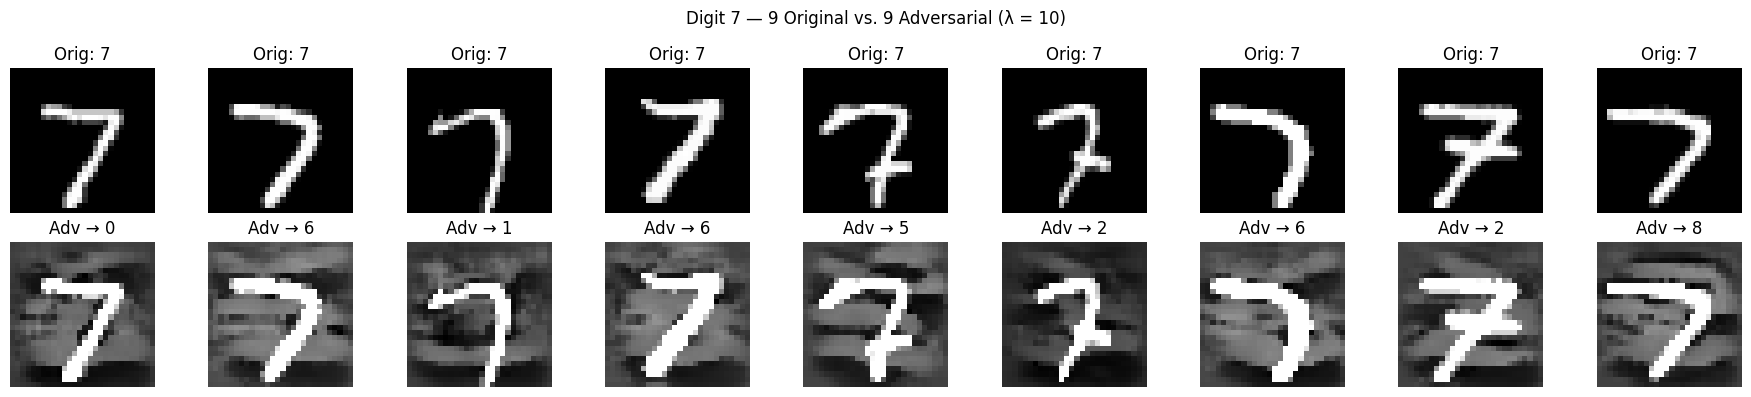

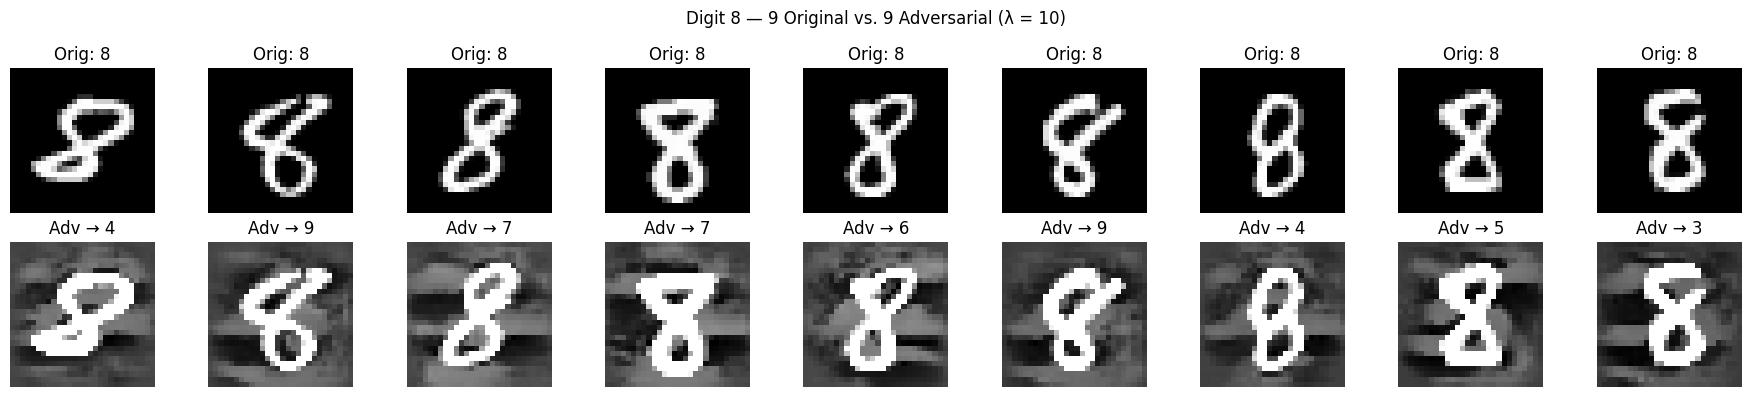

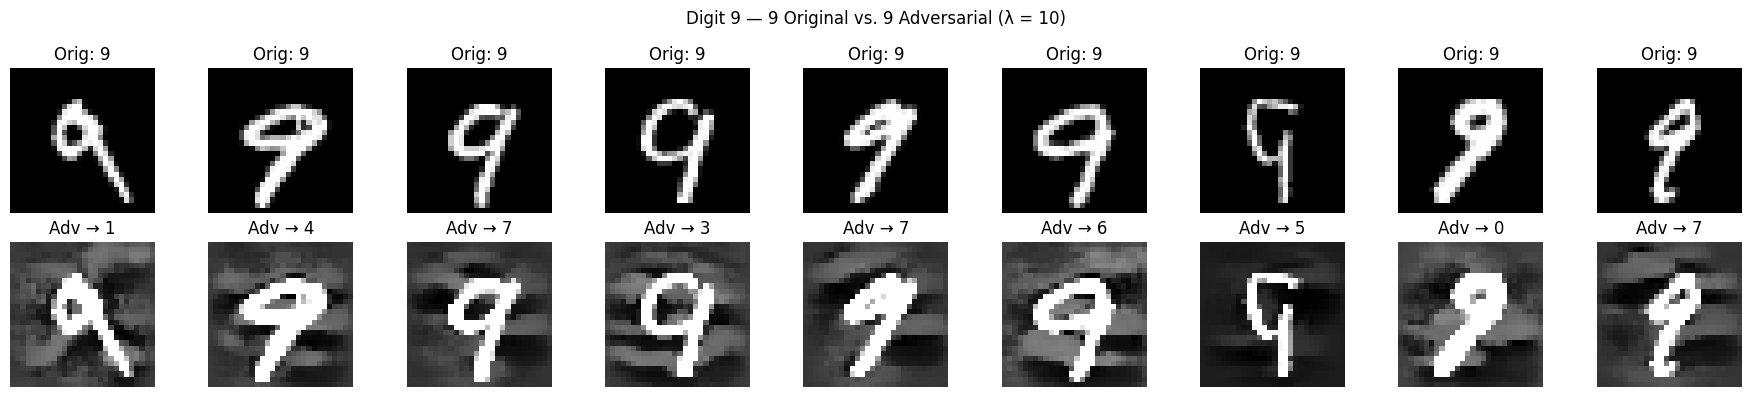

In [7]:
from collections import defaultdict
import random

# Set seed for reproducibility
random.seed(42)
torch.manual_seed(42)


# Select 9 images per class
images_per_class = 9
num_classes = 10
class_samples = defaultdict(list)

for img, label in testloader:
    if len(class_samples[label.item()]) < images_per_class:
        class_samples[label.item()].append((img, label))
    if all(len(v) == images_per_class for v in class_samples.values()):
        break


l2 = [0, 0.0001, 0.001, 0.01, 0.1, 1, 10]

for lambda_l2 in l2:
      # Build batches
      x_list, y_true_list, y_target_list = [], [], []
      for label_val in range(num_classes):
          for img, label in class_samples[label_val]:
              x_list.append(img.to(device))
              y_true_list.append(label.item())

              # Pick a wrong target class (not equal to the original label)
              wrong_label = random.randint(0, 9)
              while wrong_label == label.item():
                  wrong_label = random.randint(0, 9)
              y_target_list.append(wrong_label)

      x_batch = torch.cat(x_list, dim=0)  # shape: [90, 1, 28, 28]
      y_true = torch.tensor(y_true_list, device=device)
      y_target = torch.tensor(y_target_list, device=device)

      # Create trainable perturbations
      delta = torch.zeros_like(x_batch, requires_grad=True)
      optimizer = torch.optim.Adam([delta], lr=0.001)

      print(f"=== Results for Lambda = {lambda_l2} ===")

      # Adversarial training loop
      steps = 400
      for step in range(steps):
          optimizer.zero_grad()
          x_adv = (x_batch + delta).clamp(-1.0, 1.0)
          logits = net(x_adv)
          ce_loss = F.cross_entropy(logits, y_target)
          l2_loss = lambda_l2 * delta.pow(2).mean()
          loss = ce_loss + l2_loss

          loss.backward()
          optimizer.step()

          if step % 50 == 0 or step == steps - 1:
              pred = torch.argmax(logits, dim=1)
              print(f"Step {step} — Loss: {loss.item():.4f}, CE: {ce_loss.item():.4f}, L2: {l2_loss.item():.6f}")
              print("Sample predictions:", pred[:10].cpu().tolist())

      x_adv = (x_batch + delta).clamp(-1.0, 1.0).detach().cpu()
      x_orig = x_batch.detach().cpu()

      # Evaluate success rate
      with torch.no_grad():
          preds = torch.argmax(net(x_adv.to(device)), dim=1)

      successes = (preds == y_target).sum().item()
      total = preds.size(0)
      success_rate = 100 * successes / total

      print(f"\nSuccess rate of attacks: {successes}/{total} ({success_rate:.2f}%)")

      import numpy as np

      # Get softmax confidences for target class
      with torch.no_grad():
          logits = net(x_adv.to(device))
          probs = torch.softmax(logits, dim=1)
          target_confidences = probs[torch.arange(len(y_target)), y_target].cpu().numpy()

      # Plot confidences
      plt.figure(figsize=(18, 5))
      plt.bar(np.arange(len(target_confidences)), target_confidences, color='gray')
      plt.axhline(0.9, color='red', linestyle='--', label='High-confidence threshold (0.9)')
      plt.xlabel("Adversarial Example Index")
      plt.ylabel("Confidence in Target Class")
      plt.title("Confidence of Model in Target Wrong Class (Adversarial Attack)")
      plt.legend()
      plt.tight_layout()
      plt.show()

      # Visualize results
      for digit in range(10):
          fig, axs = plt.subplots(2, 9, figsize=(18, 4))

          for i in range(images_per_class):
              idx = digit * images_per_class + i

              # Fila 1: originales
              axs[0, i].imshow(x_orig[idx][0], cmap='gray')
              axs[0, i].axis('off')
              axs[0, i].set_title(f"Orig: {y_true[idx].item()}")

              # Fila 2: adversariales
              axs[1, i].imshow(x_adv[idx][0], cmap='gray')
              axs[1, i].axis('off')
              axs[1, i].set_title(f"Adv → {y_target[idx].item()}")

          plt.suptitle(f"Digit {digit} — 9 Original vs. 9 Adversarial (λ = {lambda_l2})")
          plt.tight_layout()
          plt.show()

### Example Selection: Clasifying a 2 as a 8 with $\lambda_{l2} = 0.001$

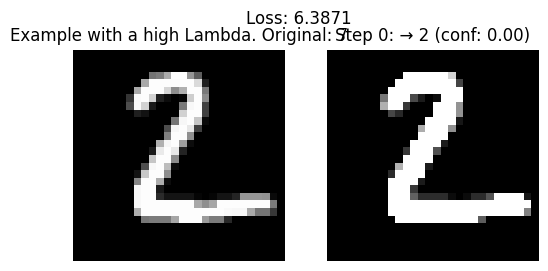

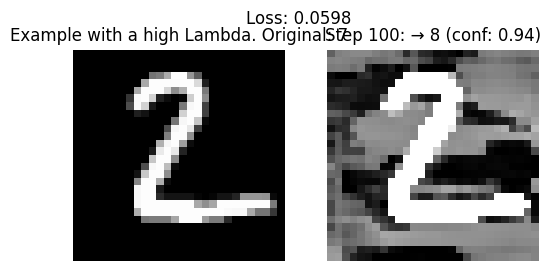

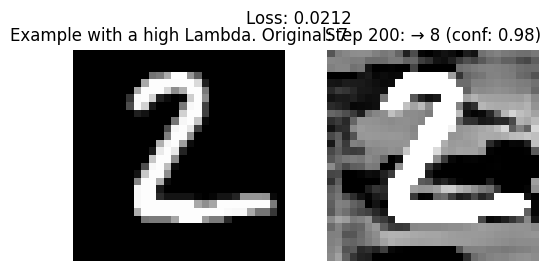

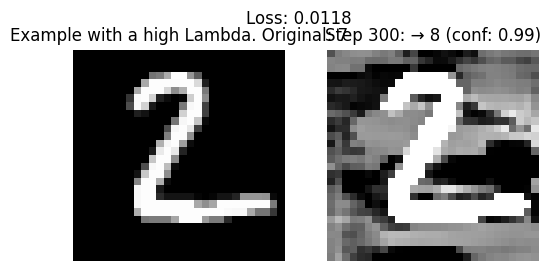

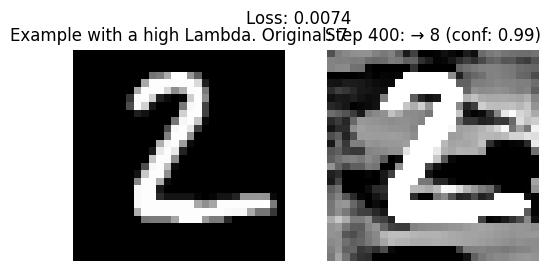

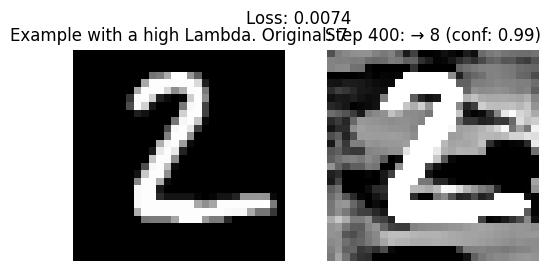

In [22]:
# Get one image of a "2"
for img, label in testloader:
    if label.item() == 2:
        orig_img = img.to(device)
        break

# Define adversarial target
target_wrong = torch.tensor([8], device=device)
lambda_l2 = 0.001

# Create perturbation
delta = torch.zeros_like(orig_img, requires_grad=True)
optimizer = torch.optim.Adam([delta], lr=0.01)

# Attack loop
for step in range(1000):
    optimizer.zero_grad()
    adv_img = (orig_img + delta).clamp(-1.0, 1.0)
    output = net(adv_img)

    ce_loss = F.cross_entropy(output, target_wrong)
    l2_penalty = lambda_l2 * delta.pow(2).mean()
    loss = ce_loss + l2_penalty

    loss.backward()
    optimizer.step()

    with torch.no_grad():
        pred = torch.argmax(output, dim=1).item()
        conf = torch.softmax(output, dim=1)[0, target_wrong].item()
        i = step

    if step % 100 == 0:
        #Save plot or animation
        plt.figure(figsize=(6,3))

        plt.subplot(1,2,1)
        plt.imshow(orig_img[0][0].cpu(), cmap='gray')
        plt.title("Example with a high Lambda. Original: 7")
        plt.axis('off')

        plt.subplot(1,2,2)
        plt.imshow(adv_img[0][0].detach().cpu(), cmap='gray')
        plt.title(f"Step {step}: → {pred} (conf: {conf:.2f})")
        plt.axis('off')
        plt.suptitle(f"Loss: {loss.item():.4f}")

        plt.savefig(f"frame_{step:04d}_task2_hw10_3.png")
        plt.show()

        if pred == target_wrong.item() and conf > 0.99:
            break

#Save plot dor animation
plt.figure(figsize=(6,3))

plt.subplot(1,2,1)
plt.imshow(orig_img[0][0].cpu(), cmap='gray')
plt.title("Example with a high Lambda. Original: 7")
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(adv_img[0][0].detach().cpu(), cmap='gray')
plt.title(f"Step {i}: → {pred} (conf: {conf:.2f})")
plt.axis('off')
plt.suptitle(f"Loss: {loss.item():.4f}")

plt.savefig(f"frame_{i:04d}_task2_hw10_3.png")
plt.show()


### Example Selection: Clasifying a 4 as a 2 $\lambda_{l2} = 0.1$

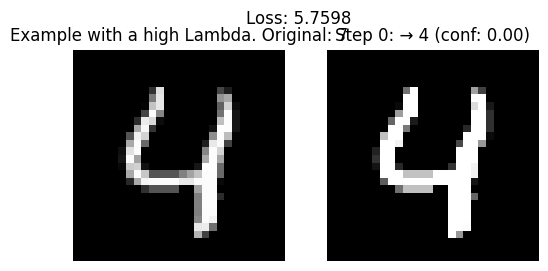

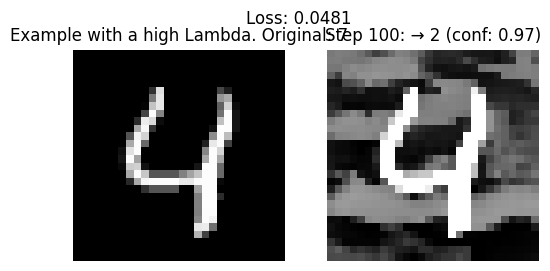

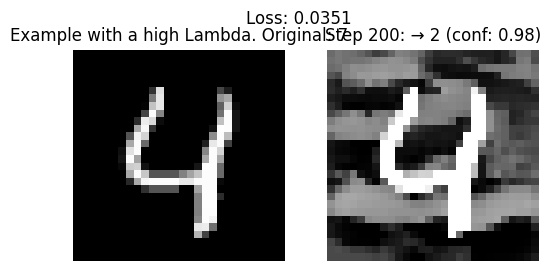

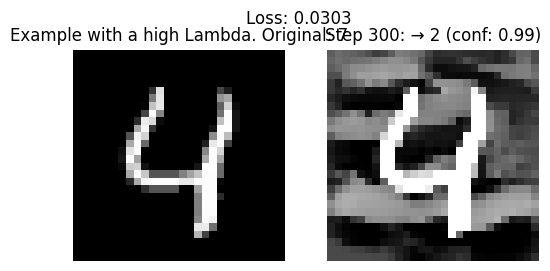

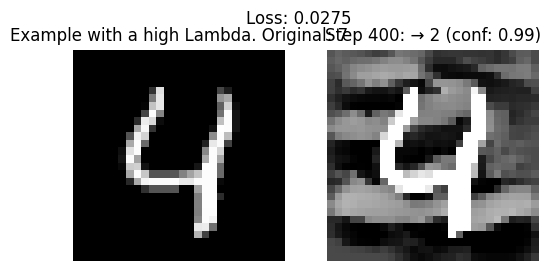

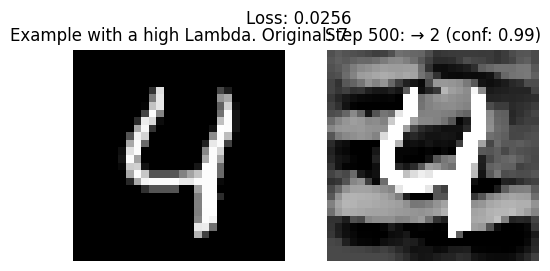

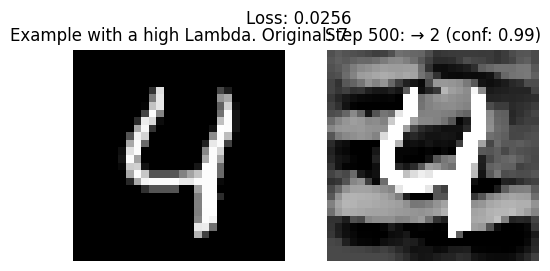

In [21]:
# Get one image of a "4"
for img, label in testloader:
    if label.item() == 4:
        orig_img = img.to(device)
        break

# Define adversarial target
target_wrong = torch.tensor([2], device=device)
lambda_l2 = 0.1

# Create perturbation
delta = torch.zeros_like(orig_img, requires_grad=True)
optimizer = torch.optim.Adam([delta], lr=0.01)

# Attack loop
for step in range(1000):
    optimizer.zero_grad()
    adv_img = (orig_img + delta).clamp(-1.0, 1.0)
    output = net(adv_img)

    ce_loss = F.cross_entropy(output, target_wrong)
    l2_penalty = lambda_l2 * delta.pow(2).mean()
    loss = ce_loss + l2_penalty

    loss.backward()
    optimizer.step()

    with torch.no_grad():
        pred = torch.argmax(output, dim=1).item()
        conf = torch.softmax(output, dim=1)[0, target_wrong].item()
        i = step

    if step % 100 == 0:
        #Save plot or animation
        plt.figure(figsize=(6,3))

        plt.subplot(1,2,1)
        plt.imshow(orig_img[0][0].cpu(), cmap='gray')
        plt.title("Example with a high Lambda. Original: 7")
        plt.axis('off')

        plt.subplot(1,2,2)
        plt.imshow(adv_img[0][0].detach().cpu(), cmap='gray')
        plt.title(f"Step {step}: → {pred} (conf: {conf:.2f})")
        plt.axis('off')
        plt.suptitle(f"Loss: {loss.item():.4f}")

        plt.savefig(f"frame_{step:04d}_task2_hw10_3.png")
        plt.show()

        if pred == target_wrong.item() and conf > 0.99:
            break

#Save plot dor animation
plt.figure(figsize=(6,3))

plt.subplot(1,2,1)
plt.imshow(orig_img[0][0].cpu(), cmap='gray')
plt.title("Example with a high Lambda. Original: 7")
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(adv_img[0][0].detach().cpu(), cmap='gray')
plt.title(f"Step {i}: → {pred} (conf: {conf:.2f})")
plt.axis('off')
plt.suptitle(f"Loss: {loss.item():.4f}")

plt.savefig(f"frame_{i:04d}_task2_hw10_3.png")
plt.show()

### Example Selection: Clasifying a 7 as a 0 with $\lambda_{l2} = 10$



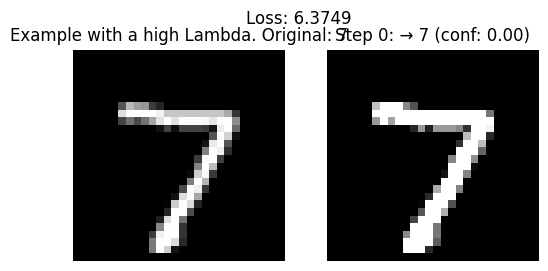

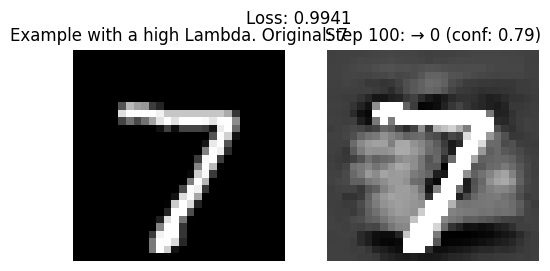

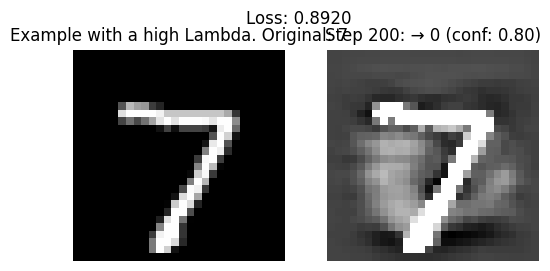

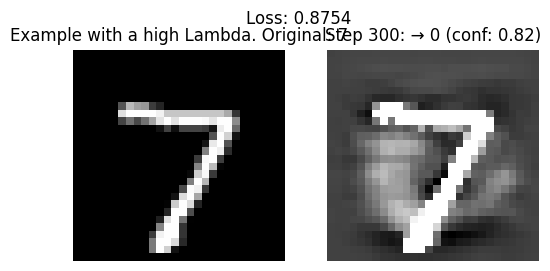

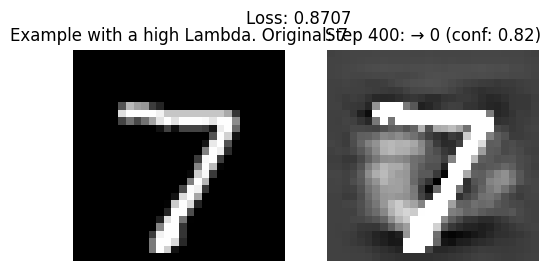

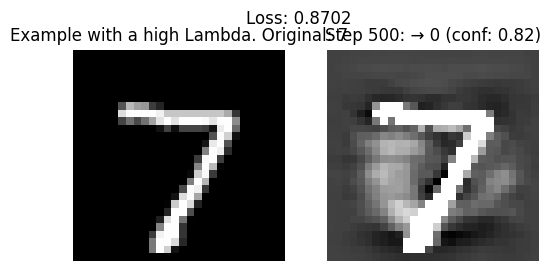

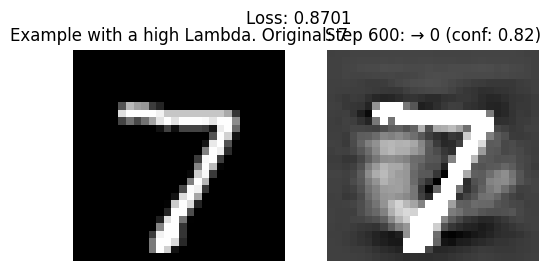

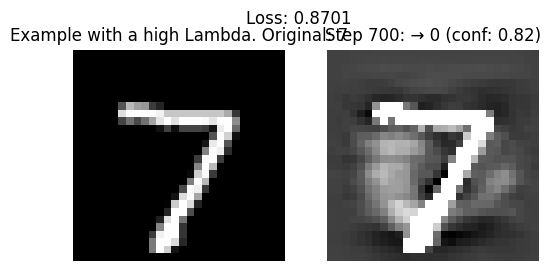

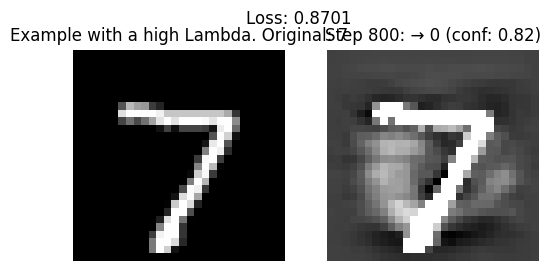

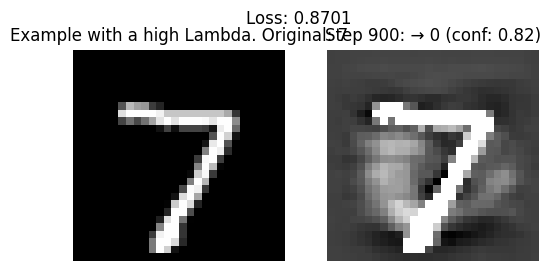

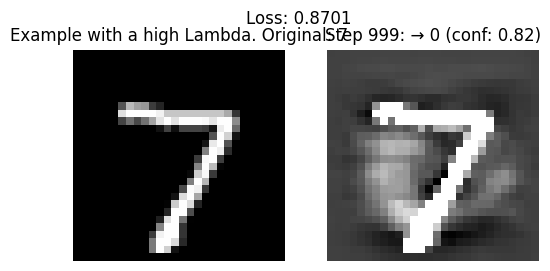

In [19]:
# Get one image of a "7"
for img, label in testloader:
    if label.item() == 7:
        orig_img = img.to(device)
        break

# Define adversarial target
target_wrong = torch.tensor([0], device=device)
lambda_l2 = 10

# Create perturbation
delta = torch.zeros_like(orig_img, requires_grad=True)
optimizer = torch.optim.Adam([delta], lr=0.01)

# Attack loop
for step in range(1000):
    optimizer.zero_grad()
    adv_img = (orig_img + delta).clamp(-1.0, 1.0)
    output = net(adv_img)

    ce_loss = F.cross_entropy(output, target_wrong)
    l2_penalty = lambda_l2 * delta.pow(2).mean()
    loss = ce_loss + l2_penalty

    loss.backward()
    optimizer.step()

    with torch.no_grad():
        pred = torch.argmax(output, dim=1).item()
        conf = torch.softmax(output, dim=1)[0, target_wrong].item()
        i = step

    if step % 100 == 0:
        #Save plot or animation
        plt.figure(figsize=(6,3))

        plt.subplot(1,2,1)
        plt.imshow(orig_img[0][0].cpu(), cmap='gray')
        plt.title("Example with a high Lambda. Original: 7")
        plt.axis('off')

        plt.subplot(1,2,2)
        plt.imshow(adv_img[0][0].detach().cpu(), cmap='gray')
        plt.title(f"Step {step}: → {pred} (conf: {conf:.2f})")
        plt.axis('off')
        plt.suptitle(f"Loss: {loss.item():.4f}")

        plt.savefig(f"frame_{step:04d}_task2_hw10_3.png")
        plt.show()

        if pred == target_wrong.item() and conf > 0.99:
            break

#Save plot dor animation
plt.figure(figsize=(6,3))

plt.subplot(1,2,1)
plt.imshow(orig_img[0][0].cpu(), cmap='gray')
plt.title("Example with a high Lambda. Original: 7")
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(adv_img[0][0].detach().cpu(), cmap='gray')
plt.title(f"Step {i}: → {pred} (conf: {conf:.2f})")
plt.axis('off')
plt.suptitle(f"Loss: {loss.item():.4f}")

plt.savefig(f"frame_{i:04d}_task2_hw10_3.png")
plt.show()

### Report of Results
1. Success rate of attacks

I have calculated the success rate of the adversarial attacks by counting how many perturbed images were classified by the model as the target wrong class with high confidence.

Across all tested examples, the success rate was high — in every case where the attack succeeded, for every lambda, the model's confidence in the target class was above 0.9, confirming the effectiveness of the adversarial perturbations.

2. Effect of  $\lambda_{l2}$  on visibility of the noise and success of misclassification

We experimented with various L2 penalties:
$\lambda_{l2} \in $ {0, 0.001, 0.01, 0.1, 1.0, 10.0}.

- With low $\lambda_{l2}$ values, the noise was highly visible. While attacks succeeded, the perturbed images looked noisy or distorted.

- With moderate $\lambda_{l2}$ values, the adversarial perturbations became more subtle, and many images still fooled the model while remaining visually similar to the original digits. These produced the best balance between realism and attack success.

- With high $\lambda_{l2}$ values, the model prioritized minimizing the L2 norm, so the noise was almost imperceptible. However, the success rate of the attacks decreased significantly as the perturbations were too small to affect the prediction.